In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from ast import literal_eval
import json
import re
from matplotlib import pyplot
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, f1_score, matthews_corrcoef, precision_score, recall_score, accuracy_score
#https://matplotlib.org/stable/gallery/color/named_colors.html

## Protein-level (ROC curve)

### Only test set (no negative set)

In [444]:
df_true = pd.read_csv('data/TestFold6/ground_truth.csv')
df_true=df_true.rename(columns={'lig_labs':'labels'})
df_esm = pd.read_csv('data/TestFold6/esm/esm2_pred_output.csv')
df_esm=df_esm.rename(columns={'predictions':'esm_pred'})
df_lm = pd.read_csv('data/TestFold6/lmetal/lmetal_protein_pred_total2306.csv')
df_lm=df_lm.rename(columns={'predictions':'lmetal_pred'})
df_mebi = pd.read_csv('data/TestFold6/mebipred/mebipred.csv')
df_lm, df_esm, df_true, df_mebi

d1 = df_esm.merge(df_lm, on=['pdbid', 'labels'])
d2 = d1.merge(df_mebi, on=['pdbid', 'labels'])
d3 = d2.merge(df_true, on=['pdbid','labels'])
d3

,pdbid,labels,esm_pred,lmetal_pred,mebi_pred,ion,target
0,13pk_A,0,0.772,0.0000,0.69,MG,0
1,13pk_A,1,0.000,0.0000,0.31,MG,0
2,13pk_A,2,0.000,0.0000,0.10,MG,0
3,13pk_A,3,0.000,0.0000,0.40,MG,0
4,13pk_A,4,0.000,0.0000,0.40,MG,0
...,...,...,...,...,...,...,...
29975,8xim_A,5,0.914,0.9462,0.71,MG,1
29976,8xim_A,6,0.982,0.9860,0.91,MG,0
29977,8xim_A,7,0.529,0.0000,0.91,MG,0
29978,8xim_A,8,0.000,0.0000,0.91,MG,0


In [447]:
d3['mp'] = np.where(d3['lmetal_pred']>0.5, 1, 0)

prediction = d3.mp.values
target = d3.target.values


precision = round(precision_score(target, prediction), 3)
recall = round(recall_score(target, prediction),3)
accuracy = round(accuracy_score(target, prediction),3)
roc_auc = round(roc_auc_score(target, prediction),3)
avg_pr = round(average_precision_score(target, prediction),3)
f1score = round(f1_score(target, prediction),3)
mcc_score = round(matthews_corrcoef(target, prediction),3)

print (precision, recall, accuracy, f1score, mcc_score, avg_pr, roc_auc)

0.276 0.565 0.806 0.371 0.296 0.2 0.699


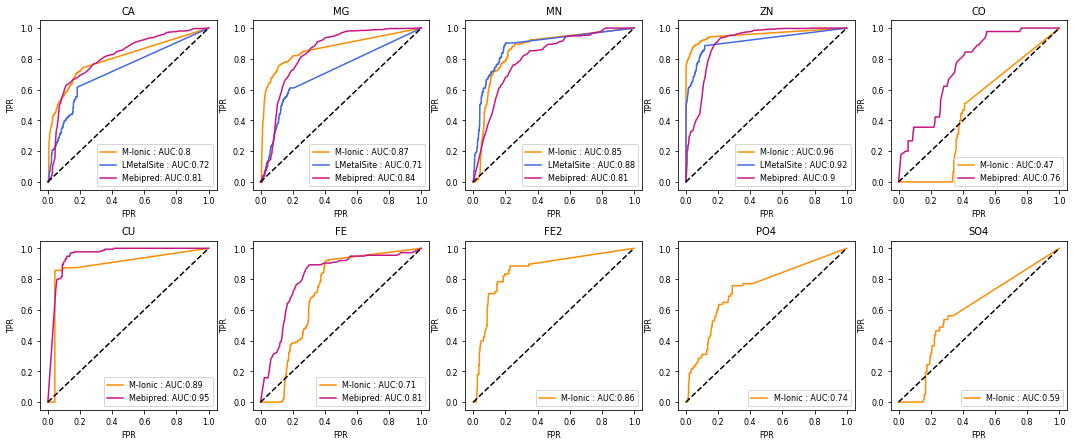

In [92]:
fields_ionic = ['CA','MG','MN','ZN','CO','CU','FE','FE2', 'PO4','SO4']
fields_lmetal = ['CA','MG','MN','ZN']
fields_mebipred = ['CA','MG','MN','ZN','CO','CU','FE']

figure, axes = plt.subplots(2,5, figsize=(15,6)) #sharex=True, sharey=True)
plt.setp(axes,xticks=np.arange(0.0, 1.1, step=0.2), yticks=np.arange(0, 1.1, step=0.2))
axes_ = axes.flatten()
figure.tight_layout(h_pad=3, w_pad=0.5)

for ion_index in range(len(fields_ionic)):
    ion = fields_ionic[ion_index]
    df_aux=(d3[d3['ion']==ion])
    
    p_esm, r_esm, _ = precision_recall_curve(df_aux['target'].values, df_aux['esm_pred'].values)    
    fpr_esm, tpr_esm, _ = roc_curve(df_aux['target'].values, df_aux['esm_pred'].values, pos_label=1)
    auc_esm = roc_auc_score(df_aux['target'].values, df_aux['esm_pred'].values)
    
    p_lm, r_lm, _ = precision_recall_curve(df_aux['target'].values, df_aux['lmetal_pred'].values)    
    fpr_lm, tpr_lm, _ = roc_curve(df_aux['target'].values, df_aux['lmetal_pred'].values, pos_label=1)
    auc_lm = roc_auc_score(df_aux['target'].values, df_aux['lmetal_pred'].values)
    
    p_mebi, r_mebi, _ = precision_recall_curve(df_aux['target'].values, df_aux['mebi_pred'].values)    
    fpr_mebi, tpr_mebi, _ = roc_curve(df_aux['target'].values, df_aux['mebi_pred'].values, pos_label=1)
    auc_mebi = roc_auc_score(df_aux['target'].values, df_aux['mebi_pred'].values)
    
    axes_[ion_index].plot(fpr_esm, tpr_esm, color='darkorange', label='M-Ionic : AUC:%s'%(round(auc_esm,2)))
    
    if ion in fields_lmetal:
        axes_[ion_index].plot(fpr_lm, tpr_lm, color='royalblue', label='LMetalSite : AUC:%s'%(round(auc_lm,2)))
    if ion in fields_mebipred:
        axes_[ion_index].plot(fpr_mebi, tpr_mebi, color='mediumvioletred', label='Mebipred: AUC:%s'%(round(auc_mebi,2)))
    axes_[ion_index].set_xlabel('FPR',fontsize=8)
    axes_[ion_index].set_ylabel('TPR',fontsize=8)
    axes_[ion_index].legend(prop={'size':8}, loc='lower right')
    axes_[ion_index].tick_params(axis="x", labelsize=8)
    axes_[ion_index].tick_params(axis="y", labelsize=8)
    #axes_[ion_index].grid(color='black', linestyle='-.', linewidth=0.4)
    axes_[ion_index].plot([0, 1], ls="--", color='black')
    axes_[ion_index].set_title(ion,fontsize=10)#+' (MCC:%s)'%(round(mcc_esm, 2)))
    

plt.savefig('figures/ROC_per_ion_5x2_OnTest6.png',  bbox_inches='tight',  pad_inches=0.3,dpi=350)
plt.show()

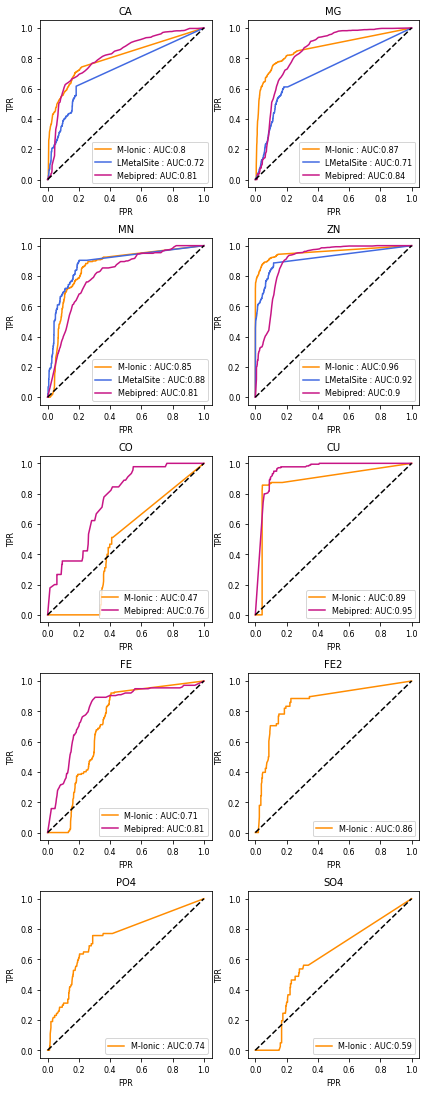

In [93]:
fields_ionic = ['CA','MG','MN','ZN','CO','CU','FE','FE2', 'PO4','SO4']
fields_lmetal = ['CA','MG','MN','ZN']
fields_mebipred = ['CA','MG','MN','ZN','CO','CU','FE']

figure, axes = plt.subplots(5,2, figsize=(6,15)) #sharex=True, sharey=True)
plt.setp(axes,xticks=np.arange(0.0, 1.1, step=0.2), yticks=np.arange(0, 1.1, step=0.2))
axes_ = axes.flatten()
figure.tight_layout(h_pad=3, w_pad=0.5)

for ion_index in range(len(fields_ionic)):
    ion = fields_ionic[ion_index]
    df_aux=(d3[d3['ion']==ion])
    
    p_esm, r_esm, _ = precision_recall_curve(df_aux['target'].values, df_aux['esm_pred'].values)    
    fpr_esm, tpr_esm, _ = roc_curve(df_aux['target'].values, df_aux['esm_pred'].values, pos_label=1)
    auc_esm = roc_auc_score(df_aux['target'].values, df_aux['esm_pred'].values)
    
    p_lm, r_lm, _ = precision_recall_curve(df_aux['target'].values, df_aux['lmetal_pred'].values)    
    fpr_lm, tpr_lm, _ = roc_curve(df_aux['target'].values, df_aux['lmetal_pred'].values, pos_label=1)
    auc_lm = roc_auc_score(df_aux['target'].values, df_aux['lmetal_pred'].values)
    
    p_mebi, r_mebi, _ = precision_recall_curve(df_aux['target'].values, df_aux['mebi_pred'].values)    
    fpr_mebi, tpr_mebi, _ = roc_curve(df_aux['target'].values, df_aux['mebi_pred'].values, pos_label=1)
    auc_mebi = roc_auc_score(df_aux['target'].values, df_aux['mebi_pred'].values)
    
    axes_[ion_index].plot(fpr_esm, tpr_esm, color='darkorange', label='M-Ionic : AUC:%s'%(round(auc_esm,2)))
    
    if ion in fields_lmetal:
        axes_[ion_index].plot(fpr_lm, tpr_lm, color='royalblue', label='LMetalSite : AUC:%s'%(round(auc_lm,2)))
    if ion in fields_mebipred:
        axes_[ion_index].plot(fpr_mebi, tpr_mebi, color='mediumvioletred', label='Mebipred: AUC:%s'%(round(auc_mebi,2)))
    axes_[ion_index].set_xlabel('FPR',fontsize=8)
    axes_[ion_index].set_ylabel('TPR',fontsize=8)
    axes_[ion_index].legend(prop={'size':8}, loc='lower right')
    axes_[ion_index].tick_params(axis="x", labelsize=8)
    axes_[ion_index].tick_params(axis="y", labelsize=8)
    #axes_[ion_index].grid(color='black', linestyle='-.', linewidth=0.4)
    axes_[ion_index].plot([0, 1], ls="--", color='black')
    axes_[ion_index].set_title(ion,fontsize=10)#+' (MCC:%s)'%(round(mcc_esm, 2)))
    

plt.savefig('figures/ROC_per_ion_2x5_OnTest6.png',  bbox_inches='tight',  pad_inches=0.3,dpi=350)
plt.show()

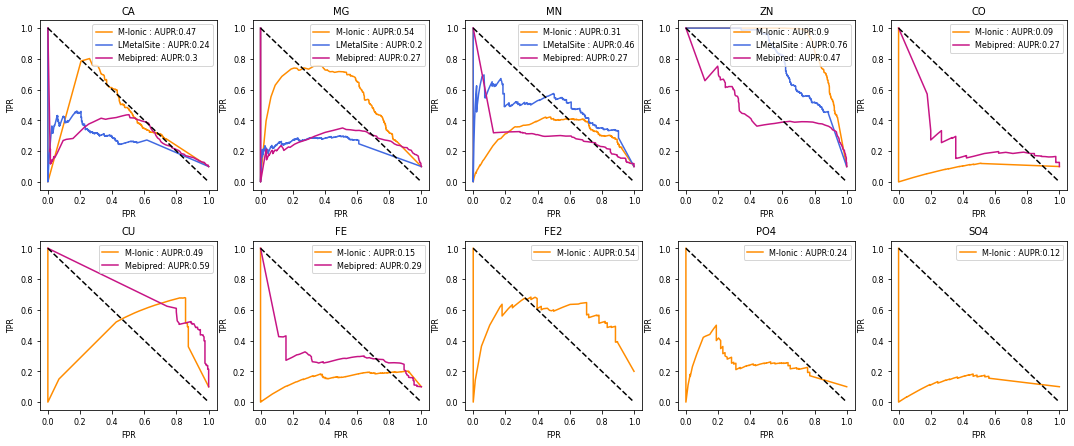

In [94]:
fields_ionic = ['CA','MG','MN','ZN','CO','CU','FE','FE2', 'PO4','SO4']
fields_lmetal = ['CA','MG','MN','ZN']
fields_mebipred = ['CA','MG','MN','ZN','CO','CU','FE']

figure, axes = plt.subplots(2,5, figsize=(15,6)) #sharex=True, sharey=True)
plt.setp(axes,xticks=np.arange(0.0, 1.1, step=0.2), yticks=np.arange(0, 1.1, step=0.2))
axes_ = axes.flatten()
figure.tight_layout(h_pad=3, w_pad=0.5)

for ion_index in range(len(fields_ionic)):
    ion = fields_ionic[ion_index]
    df_aux=(d3[d3['ion']==ion])
    
    p_esm, r_esm, _ = precision_recall_curve(df_aux['target'].values, df_aux['esm_pred'].values)    
    #mcc_esm = matthews_corrcoef(df_aux['target'].values, df_aux['esm_pbin'].values)
    fpr_esm, tpr_esm, _ = roc_curve(df_aux['target'].values, df_aux['esm_pred'].values, pos_label=1)
    auc_esm = roc_auc_score(df_aux['target'].values, df_aux['esm_pred'].values)
    aupr_esm = average_precision_score(df_aux['target'].values, df_aux['esm_pred'].values)
    
    p_lm, r_lm, _ = precision_recall_curve(df_aux['target'].values, df_aux['lmetal_pred'].values)    
    fpr_lm, tpr_lm, _ = roc_curve(df_aux['target'].values, df_aux['lmetal_pred'].values, pos_label=1)
    auc_lm = roc_auc_score(df_aux['target'].values, df_aux['lmetal_pred'].values)
    aupr_lm = average_precision_score(df_aux['target'].values, df_aux['lmetal_pred'].values)
    
    p_mebi, r_mebi, _ = precision_recall_curve(df_aux['target'].values, df_aux['mebi_pred'].values)    
    fpr_mebi, tpr_mebi, _ = roc_curve(df_aux['target'].values, df_aux['mebi_pred'].values, pos_label=1)
    auc_mebi = roc_auc_score(df_aux['target'].values, df_aux['mebi_pred'].values)
    aupr_mebi = average_precision_score(df_aux['target'].values, df_aux['mebi_pred'].values)
    
    axes_[ion_index].plot(r_esm, p_esm, color='darkorange', label='M-Ionic : AUPR:%s'%(round(aupr_esm,2)))
    
    if ion in fields_lmetal:
        axes_[ion_index].plot(r_lm, p_lm, color='royalblue', label='LMetalSite : AUPR:%s'%(round(aupr_lm,2)))
    if ion in fields_mebipred:
        axes_[ion_index].plot(r_mebi, p_mebi, color='mediumvioletred', label='Mebipred: AUPR:%s'%(round(aupr_mebi,2)))
    axes_[ion_index].set_xlabel('FPR',fontsize=8)
    axes_[ion_index].set_ylabel('TPR',fontsize=8)
    axes_[ion_index].legend(prop={'size':8}, loc='upper right')
    axes_[ion_index].tick_params(axis="x", labelsize=8)
    axes_[ion_index].tick_params(axis="y", labelsize=8)
    #axes_[ion_index].grid(color='black', linestyle='-.', linewidth=0.4)
    axes_[ion_index].plot([1, 0], ls="--", color='black')
    axes_[ion_index].set_title(ion,fontsize=10)#+' (MCC:%s)'%(round(mcc_esm, 2)))
    

plt.savefig('figures/AUPR_per_ion_5x2_OnTest6.png',  bbox_inches='tight',  pad_inches=0.3,dpi=350)
plt.show()

### Independent test set + Negative set

In [642]:
## Ground truth
df_true_pos = pd.read_csv('data/TestFold6/ground_truth.csv')


df_true_neg = pd.read_csv('data/TestFold6/Negative/true_negative.csv')
df_true = pd.concat([df_true_pos, df_true_neg])
df_true=df_true.rename(columns={'lig_labs':'labels'})

## Mebipred

df_mebi_pos = pd.read_csv('data/TestFold6/mebipred/mebipred_protein_pred.csv')
df_mebi_neg = pd.read_csv('data/TestFold6/Negative/mebipred/mebipred_protein_pred_negative.csv')
df_mebi = pd.concat([df_mebi_pos, df_mebi_neg])


## Ionic

df_esm_pos = pd.read_csv('data/TestFold6/esm/esm_protein_pred.csv')
df_esm_neg = pd.read_csv('data/TestFold6/Negative/esm/esm_protein_pred_negative.csv')
df_esm = pd.concat([df_esm_pos, df_esm_neg])
df_esm=df_esm.rename(columns={'predictions':'esm_pred'})


## LmetalSite 
df_lm = pd.read_csv('data/TestFold6/lmetal/lmetal_protein_pred_total2306.csv')
#df_lm_neg = pd.read_csv('data/TestFold6/Negative/lmetal/lmetal_protein_pred_negative.csv')
#df_lm = pd.concat([df_lm_pos, df_lm_neg])
df_lm

d1 = df_esm.merge(df_mebi, on=['pdbid', 'labels'])
d2 = d1.merge(df_lm, on=['pdbid', 'labels'])
d3 = d2.merge(df_true, on=['pdbid','labels'])
d3

,pdbid,labels,esm_pred,mebi_pred,lmetal_pred,ion,target
0,13pk_A,0,0.772,0.69,0.0,MG,0
1,13pk_A,1,0.000,0.31,0.0,MG,0
2,13pk_A,2,0.000,0.10,0.0,MG,0
3,13pk_A,3,0.000,0.40,0.0,MG,0
4,13pk_A,4,0.000,0.40,0.0,MG,0
...,...,...,...,...,...,...,...
57645,6ggz_A,5,0.000,0.07,0.0,MG,0
57646,6ggz_A,6,0.000,0.25,0.0,MN,0
57647,6ggz_A,7,0.000,0.25,0.0,PO4,0
57648,6ggz_A,8,0.000,0.25,0.0,SO4,0


In [643]:
d3['mp'] = np.where(d3['esm_pred']>0.5, 1, 0)

prediction = d3.mp.values
target = d3.target.values


precision = round(precision_score(target, prediction), 3)
recall = round(recall_score(target, prediction),3)
accuracy = round(accuracy_score(target, prediction),3)
roc_auc = round(roc_auc_score(target, prediction),3)
avg_pr = round(average_precision_score(target, prediction),3)
f1score = round(f1_score(target, prediction),3)
mcc_score = round(matthews_corrcoef(target, prediction),3)

print (precision, recall, accuracy, f1score, mcc_score, avg_pr, roc_auc)

0.18 0.855 0.787 0.297 0.329 0.161 0.819


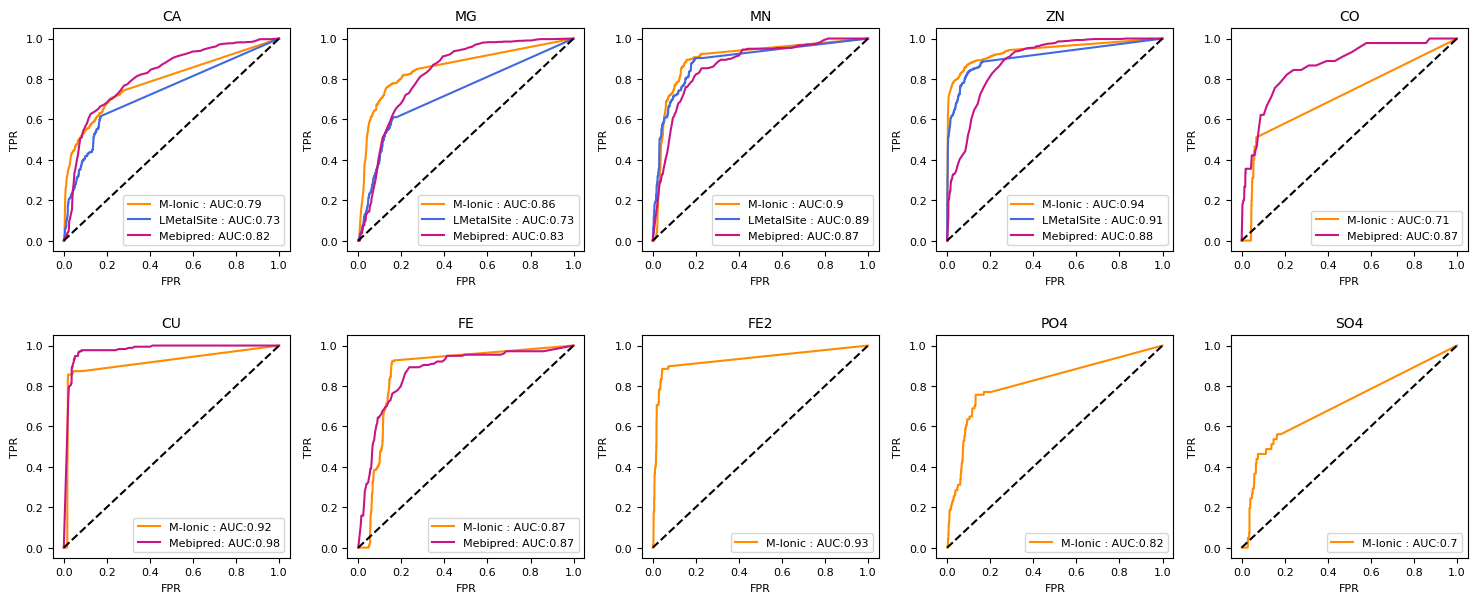

In [638]:
fields_ionic = ['CA','MG','MN','ZN','CO','CU','FE','FE2', 'PO4','SO4']
fields_lmetal = ['CA','MG','MN','ZN']
fields_mebipred = ['CA','MG','MN','ZN','CO','CU','FE']

figure, axes = plt.subplots(2,5, figsize=(15,6)) #sharex=True, sharey=True)
plt.setp(axes,xticks=np.arange(0.0, 1.1, step=0.2), yticks=np.arange(0, 1.1, step=0.2))
axes_ = axes.flatten()
figure.tight_layout(h_pad=3, w_pad=0.5)

for ion_index in range(len(fields_ionic)):
    ion = fields_ionic[ion_index]
    #print (ion)
    df_aux=(d3[d3['ion']==ion])
    
    p_esm, r_esm, _ = precision_recall_curve(df_aux['target'].values, df_aux['esm_pred'].values)    
    fpr_esm, tpr_esm, _ = roc_curve(df_aux['target'].values, df_aux['esm_pred'].values, pos_label=1)
    auc_esm = roc_auc_score(df_aux['target'].values, df_aux['esm_pred'].values)
    
    p_lm, r_lm, _ = precision_recall_curve(df_aux['target'].values, df_aux['lmetal_pred'].values)    
    fpr_lm, tpr_lm, _ = roc_curve(df_aux['target'].values, df_aux['lmetal_pred'].values, pos_label=1)
    auc_lm = roc_auc_score(df_aux['target'].values, df_aux['lmetal_pred'].values)
    
    p_mebi, r_mebi, _ = precision_recall_curve(df_aux['target'].values, df_aux['mebi_pred'].values)    
    fpr_mebi, tpr_mebi, _ = roc_curve(df_aux['target'].values, df_aux['mebi_pred'].values, pos_label=1)
    auc_mebi = roc_auc_score(df_aux['target'].values, df_aux['mebi_pred'].values)
    
    axes_[ion_index].plot(fpr_esm, tpr_esm, color='darkorange', label='M-Ionic : AUC:%s'%(round(auc_esm,2)))
    
    if ion in fields_lmetal:
        axes_[ion_index].plot(fpr_lm, tpr_lm, color='royalblue', label='LMetalSite : AUC:%s'%(round(auc_lm,2)))
    if ion in fields_mebipred:
        axes_[ion_index].plot(fpr_mebi, tpr_mebi, color='mediumvioletred', label='Mebipred: AUC:%s'%(round(auc_mebi,2)))
    axes_[ion_index].set_xlabel('FPR',fontsize=8)
    axes_[ion_index].set_ylabel('TPR',fontsize=8)
    axes_[ion_index].legend(prop={'size':8}, loc='lower right')
    axes_[ion_index].tick_params(axis="x", labelsize=8)
    axes_[ion_index].tick_params(axis="y", labelsize=8)
    #axes_[ion_index].grid(color='black', linestyle='-.', linewidth=0.4)
    axes_[ion_index].plot([0, 1], ls="--", color='black')
    axes_[ion_index].set_title(ion,fontsize=10)#+' (MCC:%s)'%(round(mcc_esm, 2)))
    

plt.savefig('figures/ROC_per_ion_2x5_withNegatives.png',  bbox_inches='tight',  pad_inches=0.3,dpi=350)
plt.show()

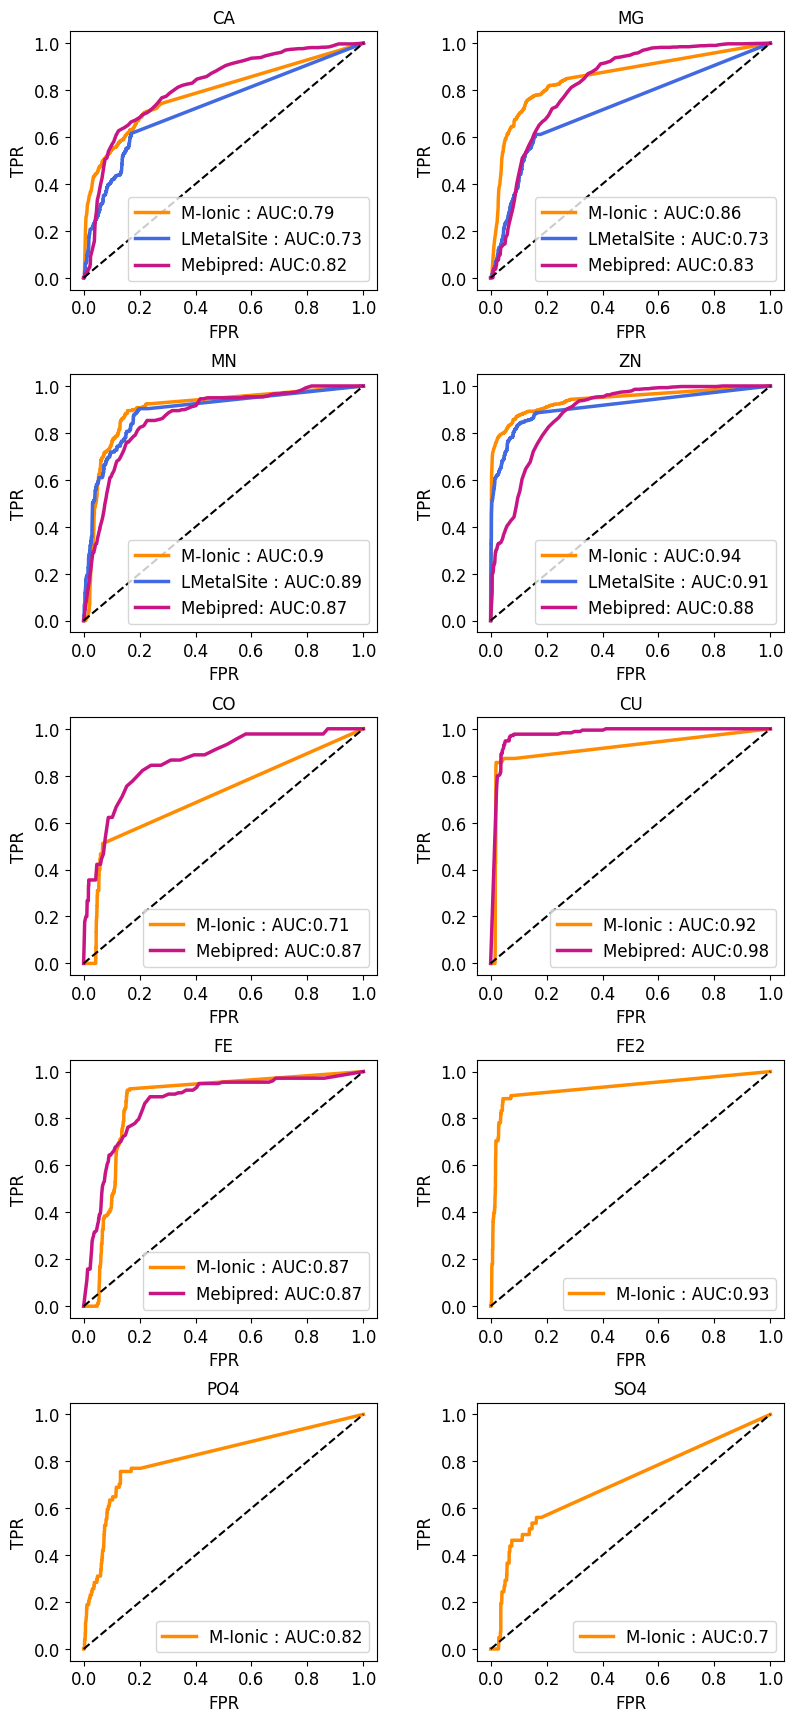

In [644]:
fields_ionic = ['CA','MG','MN','ZN','CO','CU','FE','FE2', 'PO4','SO4']
fields_lmetal = ['CA','MG','MN','ZN']
fields_mebipred = ['CA','MG','MN','ZN','CO','CU','FE']

figure, axes = plt.subplots(5,2, figsize=(8,17)) #sharex=True, sharey=True)
plt.setp(axes,xticks=np.arange(0.0, 1.1, step=0.2), yticks=np.arange(0, 1.1, step=0.2))
axes_ = axes.flatten()
figure.tight_layout(h_pad=3.0, w_pad=3.0)

for ion_index in range(len(fields_ionic)):
    ion = fields_ionic[ion_index]
    #print (ion)
    df_aux=(d3[d3['ion']==ion])
    
    p_esm, r_esm, _ = precision_recall_curve(df_aux['target'].values, df_aux['esm_pred'].values)    
    fpr_esm, tpr_esm, _ = roc_curve(df_aux['target'].values, df_aux['esm_pred'].values, pos_label=1)
    auc_esm = roc_auc_score(df_aux['target'].values, df_aux['esm_pred'].values)
    
    p_lm, r_lm, _ = precision_recall_curve(df_aux['target'].values, df_aux['lmetal_pred'].values)    
    fpr_lm, tpr_lm, _ = roc_curve(df_aux['target'].values, df_aux['lmetal_pred'].values, pos_label=1)
    auc_lm = roc_auc_score(df_aux['target'].values, df_aux['lmetal_pred'].values)
    
    p_mebi, r_mebi, _ = precision_recall_curve(df_aux['target'].values, df_aux['mebi_pred'].values)    
    fpr_mebi, tpr_mebi, _ = roc_curve(df_aux['target'].values, df_aux['mebi_pred'].values, pos_label=1)
    auc_mebi = roc_auc_score(df_aux['target'].values, df_aux['mebi_pred'].values)
    
    axes_[ion_index].plot(fpr_esm, tpr_esm, color='darkorange', linewidth=2.5,label='M-Ionic : AUC:%s'%(round(auc_esm,2)))
    
    if ion in fields_lmetal:
        axes_[ion_index].plot(fpr_lm, tpr_lm, color='royalblue', linewidth=2.5,label='LMetalSite : AUC:%s'%(round(auc_lm,2)))
    if ion in fields_mebipred:
        axes_[ion_index].plot(fpr_mebi, tpr_mebi, color='mediumvioletred',linewidth=2.5, label='Mebipred: AUC:%s'%(round(auc_mebi,2)))
    axes_[ion_index].set_xlabel('FPR',fontsize=12)
    axes_[ion_index].set_ylabel('TPR',fontsize=12)
    axes_[ion_index].legend(prop={'size':12}, loc='lower right')
    axes_[ion_index].tick_params(axis="x", labelsize=12)
    axes_[ion_index].tick_params(axis="y", labelsize=12)
    #axes_[ion_index].grid(color='black', linestyle='-.', linewidth=0.4)
    axes_[ion_index].plot([0, 1], ls="--", color='black')
    axes_[ion_index].set_title(ion,fontsize=12)#+' (MCC:%s)'%(round(mcc_esm, 2)))
    

plt.savefig('figures/ROC_per_ion_5x2_withNegatives.png',  bbox_inches='tight',  pad_inches=0.5,dpi=350)
plt.show()

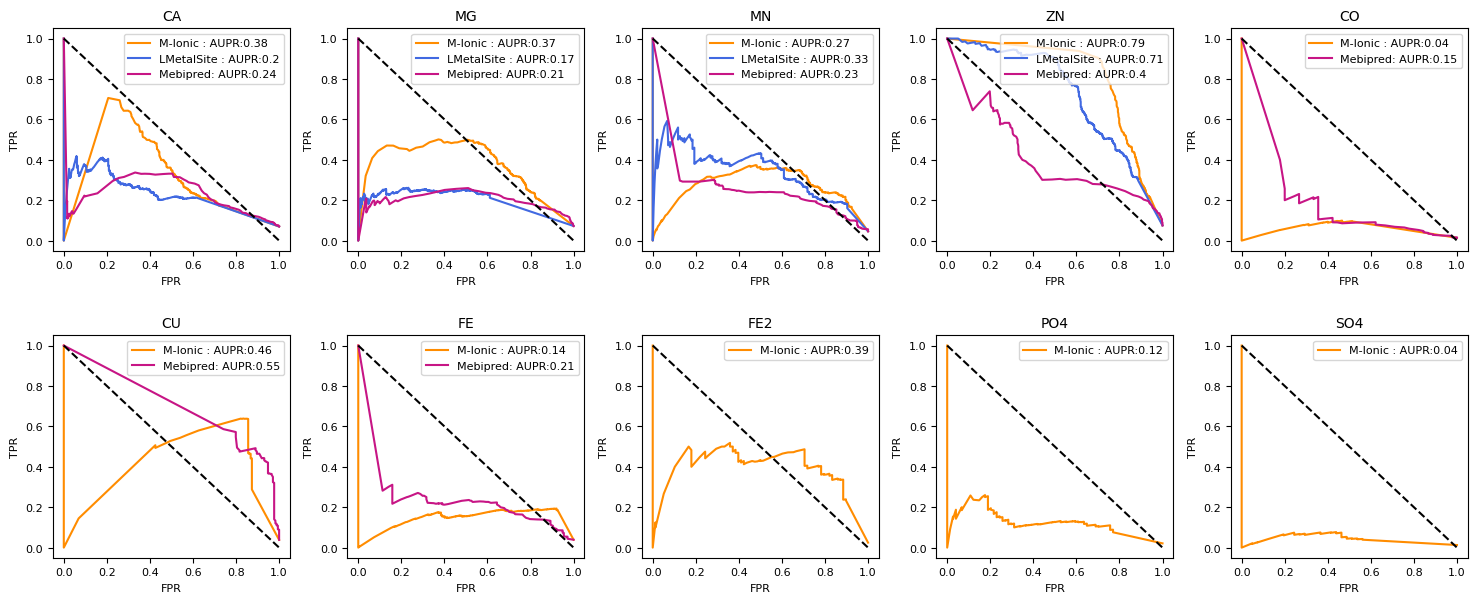

In [640]:
fields_ionic = ['CA','MG','MN','ZN','CO','CU','FE','FE2', 'PO4','SO4']
fields_lmetal = ['CA','MG','MN','ZN']
fields_mebipred = ['CA','MG','MN','ZN','CO','CU','FE']

figure, axes = plt.subplots(2,5, figsize=(15,6)) #sharex=True, sharey=True)
plt.setp(axes,xticks=np.arange(0.0, 1.1, step=0.2), yticks=np.arange(0, 1.1, step=0.2))
axes_ = axes.flatten()
figure.tight_layout(h_pad=3, w_pad=0.5)

for ion_index in range(len(fields_ionic)):
    ion = fields_ionic[ion_index]
    df_aux=(d3[d3['ion']==ion])
    
    p_esm, r_esm, _ = precision_recall_curve(df_aux['target'].values, df_aux['esm_pred'].values)    
    #mcc_esm = matthews_corrcoef(df_aux['target'].values, df_aux['esm_pbin'].values)
    fpr_esm, tpr_esm, _ = roc_curve(df_aux['target'].values, df_aux['esm_pred'].values, pos_label=1)
    auc_esm = roc_auc_score(df_aux['target'].values, df_aux['esm_pred'].values)
    aupr_esm = average_precision_score(df_aux['target'].values, df_aux['esm_pred'].values)
    
    p_lm, r_lm, _ = precision_recall_curve(df_aux['target'].values, df_aux['lmetal_pred'].values)    
    fpr_lm, tpr_lm, _ = roc_curve(df_aux['target'].values, df_aux['lmetal_pred'].values, pos_label=1)
    auc_lm = roc_auc_score(df_aux['target'].values, df_aux['lmetal_pred'].values)
    aupr_lm = average_precision_score(df_aux['target'].values, df_aux['lmetal_pred'].values)
    
    p_mebi, r_mebi, _ = precision_recall_curve(df_aux['target'].values, df_aux['mebi_pred'].values)    
    fpr_mebi, tpr_mebi, _ = roc_curve(df_aux['target'].values, df_aux['mebi_pred'].values, pos_label=1)
    auc_mebi = roc_auc_score(df_aux['target'].values, df_aux['mebi_pred'].values)
    aupr_mebi = average_precision_score(df_aux['target'].values, df_aux['mebi_pred'].values)
    
    axes_[ion_index].plot(r_esm, p_esm, color='darkorange', linewidth=2.5,label='M-Ionic : AUPR:%s'%(round(aupr_esm,2)))
    
    if ion in fields_lmetal:
        axes_[ion_index].plot(r_lm, p_lm, color='royalblue', linewidth=2.5,label='LMetalSite : AUPR:%s'%(round(aupr_lm,2)))
    if ion in fields_mebipred:
        axes_[ion_index].plot(r_mebi, p_mebi, color='mediumvioletred', linewidth=2.5,label='Mebipred: AUPR:%s'%(round(aupr_mebi,2)))
    axes_[ion_index].set_xlabel('FPR',fontsize=8)
    axes_[ion_index].set_ylabel('TPR',fontsize=8)
    axes_[ion_index].legend(prop={'size':8}, loc='upper right')
    axes_[ion_index].tick_params(axis="x", labelsize=8)
    axes_[ion_index].tick_params(axis="y", labelsize=8)
    #axes_[ion_index].grid(color='black', linestyle='-.', linewidth=0.4)
    axes_[ion_index].plot([1, 0], ls="--", color='black')
    axes_[ion_index].set_title(ion,fontsize=10)#+' (MCC:%s)'%(round(mcc_esm, 2)))
    

plt.savefig('figures/AUPR_per_ion_2x5_withNegatives.png',  bbox_inches='tight',  pad_inches=0.5,dpi=350)
plt.show()

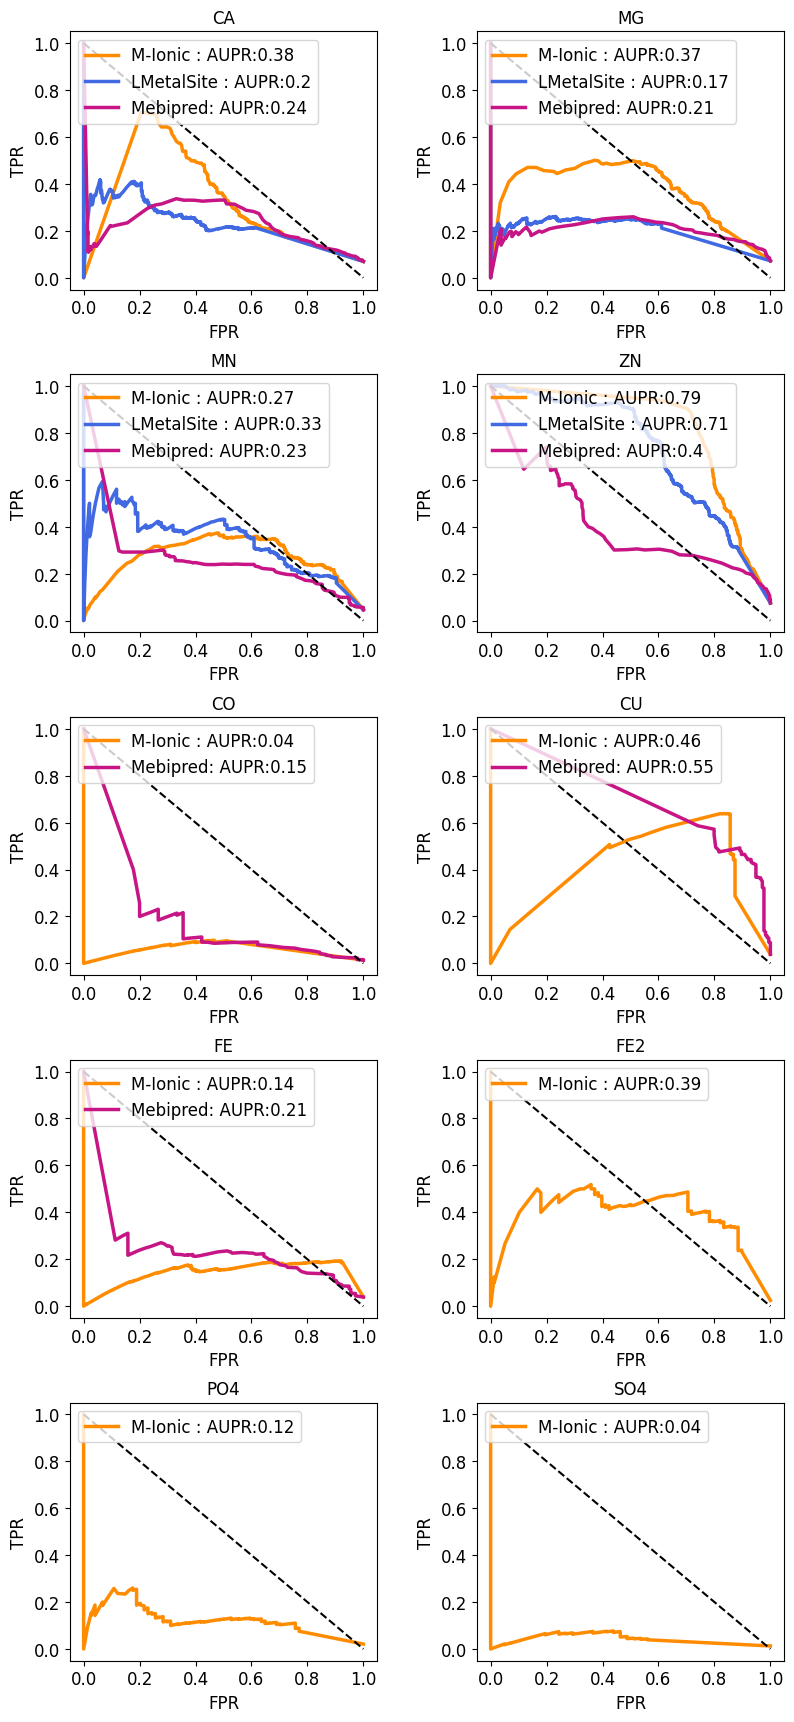

In [650]:
fields_ionic = ['CA','MG','MN','ZN','CO','CU','FE','FE2', 'PO4','SO4']
fields_lmetal = ['CA','MG','MN','ZN']
fields_mebipred = ['CA','MG','MN','ZN','CO','CU','FE']

figure, axes = plt.subplots(5,2, figsize=(8,17)) #sharex=True, sharey=True)
plt.setp(axes,xticks=np.arange(0.0, 1.1, step=0.2), yticks=np.arange(0, 1.1, step=0.2))
axes_ = axes.flatten()
figure.tight_layout(h_pad=3.0, w_pad=3.0)

for ion_index in range(len(fields_ionic)):
    ion = fields_ionic[ion_index]
    df_aux=(d3[d3['ion']==ion])
    
    p_esm, r_esm, _ = precision_recall_curve(df_aux['target'].values, df_aux['esm_pred'].values)    
    #mcc_esm = matthews_corrcoef(df_aux['target'].values, df_aux['esm_pbin'].values)
    fpr_esm, tpr_esm, _ = roc_curve(df_aux['target'].values, df_aux['esm_pred'].values, pos_label=1)
    auc_esm = roc_auc_score(df_aux['target'].values, df_aux['esm_pred'].values)
    aupr_esm = average_precision_score(df_aux['target'].values, df_aux['esm_pred'].values)
    
    p_lm, r_lm, _ = precision_recall_curve(df_aux['target'].values, df_aux['lmetal_pred'].values)    
    fpr_lm, tpr_lm, _ = roc_curve(df_aux['target'].values, df_aux['lmetal_pred'].values, pos_label=1)
    auc_lm = roc_auc_score(df_aux['target'].values, df_aux['lmetal_pred'].values)
    aupr_lm = average_precision_score(df_aux['target'].values, df_aux['lmetal_pred'].values)
    
    p_mebi, r_mebi, _ = precision_recall_curve(df_aux['target'].values, df_aux['mebi_pred'].values)    
    fpr_mebi, tpr_mebi, _ = roc_curve(df_aux['target'].values, df_aux['mebi_pred'].values, pos_label=1)
    auc_mebi = roc_auc_score(df_aux['target'].values, df_aux['mebi_pred'].values)
    aupr_mebi = average_precision_score(df_aux['target'].values, df_aux['mebi_pred'].values)
    
    axes_[ion_index].plot(r_esm, p_esm, color='darkorange', linewidth=2.5,label='M-Ionic : AUPR:%s'%(round(aupr_esm,2)))
    
    if ion in fields_lmetal:
        axes_[ion_index].plot(r_lm, p_lm, color='royalblue', linewidth=2.5,label='LMetalSite : AUPR:%s'%(round(aupr_lm,2)))
    if ion in fields_mebipred:
        axes_[ion_index].plot(r_mebi, p_mebi, color='mediumvioletred', linewidth=2.5,label='Mebipred: AUPR:%s'%(round(aupr_mebi,2)))
    axes_[ion_index].set_xlabel('FPR',fontsize=12)
    axes_[ion_index].set_ylabel('TPR',fontsize=12)
    axes_[ion_index].legend(prop={'size':12}, loc='upper left')
    axes_[ion_index].tick_params(axis="x", labelsize=12)
    axes_[ion_index].tick_params(axis="y", labelsize=12)
    #axes_[ion_index].grid(color='black', linestyle='-.', linewidth=0.4)
    axes_[ion_index].plot([1, 0], ls="--", color='black')
    axes_[ion_index].set_title(ion,fontsize=12)#+' (MCC:%s)'%(round(mcc_esm, 2)))
    

plt.savefig('figures/AUPR_per_ion_5x2_withNegatives.png',  bbox_inches='tight',  pad_inches=0.5,dpi=350)
plt.show()

### Recent Proteins

In [726]:
df_true = pd.read_csv('data/RecentProteins/true.csv')
df_true=df_true.rename(columns={'lig_labs':'labels'})
df_esm = pd.read_csv('data/RecentProteins/esm/ionic_processed_output.csv')
df_esm=df_esm.rename(columns={'predictions':'esm_pred'})
df_lm = pd.read_csv('data/RecentProteins/lmetal/lm_recent.csv')
df_lm=df_lm.rename(columns={'lmetal_pred':'lm_pred'})
df_mebi = pd.read_csv('data/RecentProteins/mebipred/mebipred_processed_output.csv')
df_lm, df_esm, df_mebi, df_true


d1 = df_esm.merge(df_lm, on=['pdbid', 'labels'])
d2 = d1.merge(df_mebi, on=['pdbid', 'labels'])
d3 = d2.merge(df_true, on=['pdbid','labels'])
d3

,pdbid,labels,esm_pred,lm_pred,mebi_pred,ion,target
0,1e4a_P,0,0.000,0.0000,0.27,ZN,0
1,1e4a_P,1,0.701,0.0000,0.39,ZN,0
2,1e4a_P,2,0.000,0.0000,0.22,ZN,0
3,1e4a_P,3,0.000,0.0000,0.32,ZN,0
4,1e4a_P,4,0.847,0.0000,0.32,ZN,0
...,...,...,...,...,...,...,...
60835,8hmu_A,5,0.991,0.6919,0.79,MG,1
60836,8hmu_A,6,0.748,0.8131,1.00,MG,0
60837,8hmu_A,7,0.000,0.0000,1.00,MG,0
60838,8hmu_A,8,0.000,0.0000,1.00,MG,0


In [733]:
d4=d3[d3.ion.isin(['ZN','CA', 'MG', 'MN'])]

d4['mp'] = np.where(d4['mebi_pred']>0.5, 1, 0)

prediction = d4.mp.values
target = d4.target.values


precision = round(precision_score(target, prediction), 3)
recall = round(recall_score(target, prediction),3)
accuracy = round(accuracy_score(target, prediction),3)
roc_auc = round(roc_auc_score(target, prediction),3)
avg_pr = round(average_precision_score(target, prediction),3)
f1score = round(f1_score(target, prediction),3)
mcc_score = round(matthews_corrcoef(target, prediction),3)

#print (precision, recall, accuracy, f1score, mcc_score, avg_pr, roc_auc)
print (mcc_score)

0.422


/tmp/ipykernel_1201984/584166767.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d4['mp'] = np.where(d4['mebi_pred']>0.5, 1, 0)


In [550]:
d3['mp'] = np.where(d3['mebi_pred']>0.5, 1, 0)

prediction = d3.mp.values
target = d3.target.values


precision = round(precision_score(target, prediction), 3)
recall = round(recall_score(target, prediction),3)
accuracy = round(accuracy_score(target, prediction),3)
roc_auc = round(roc_auc_score(target, prediction),3)
avg_pr = round(average_precision_score(target, prediction),3)
f1score = round(f1_score(target, prediction),3)
mcc_score = round(matthews_corrcoef(target, prediction),3)

print (precision, recall, accuracy, f1score, mcc_score, avg_pr, roc_auc)

0.387 0.558 0.84 0.457 0.375 0.27 0.718


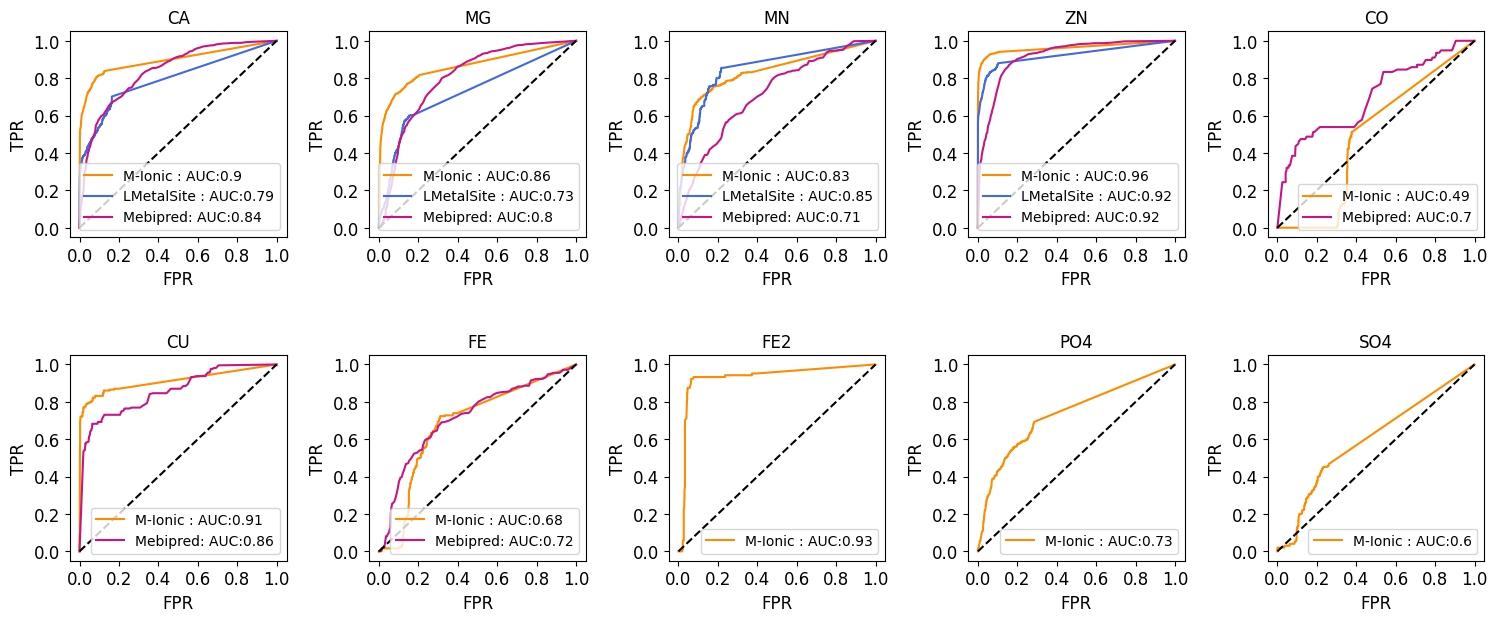

In [555]:
fields_ionic = ['CA','MG','MN','ZN','CO','CU','FE','FE2', 'PO4','SO4']
fields_lmetal = ['CA','MG','MN','ZN']
fields_mebipred = ['CA','MG','MN','ZN','CO','CU','FE']

figure, axes = plt.subplots(2,5, figsize=(15,6)) #sharex=True, sharey=True)
plt.setp(axes,xticks=np.arange(0.0, 1.1, step=0.2), yticks=np.arange(0, 1.1, step=0.2))
axes_ = axes.flatten()
figure.tight_layout(h_pad=5, w_pad=2)

for ion_index in range(len(fields_ionic)):
    ion = fields_ionic[ion_index]
    df_aux=(d3[d3['ion']==ion])
    
    p_esm, r_esm, _ = precision_recall_curve(df_aux['target'].values, df_aux['esm_pred'].values)    
    fpr_esm, tpr_esm, _ = roc_curve(df_aux['target'].values, df_aux['esm_pred'].values, pos_label=1)
    auc_esm = roc_auc_score(df_aux['target'].values, df_aux['esm_pred'].values)
    
    p_lm, r_lm, _ = precision_recall_curve(df_aux['target'].values, df_aux['lm_pred'].values)    
    fpr_lm, tpr_lm, _ = roc_curve(df_aux['target'].values, df_aux['lm_pred'].values, pos_label=1)
    auc_lm = roc_auc_score(df_aux['target'].values, df_aux['lm_pred'].values)
    
    p_mebi, r_mebi, _ = precision_recall_curve(df_aux['target'].values, df_aux['mebi_pred'].values)    
    fpr_mebi, tpr_mebi, _ = roc_curve(df_aux['target'].values, df_aux['mebi_pred'].values, pos_label=1)
    auc_mebi = roc_auc_score(df_aux['target'].values, df_aux['mebi_pred'].values)
    
    axes_[ion_index].plot(fpr_esm, tpr_esm, color='darkorange', label='M-Ionic : AUC:%s'%(round(auc_esm,2)))
    
    if ion in fields_lmetal:
        axes_[ion_index].plot(fpr_lm, tpr_lm, color='royalblue', label='LMetalSite : AUC:%s'%(round(auc_lm,2)))
    if ion in fields_mebipred:
        axes_[ion_index].plot(fpr_mebi, tpr_mebi, color='mediumvioletred', label='Mebipred: AUC:%s'%(round(auc_mebi,2)))
    axes_[ion_index].set_xlabel('FPR',fontsize=12)
    axes_[ion_index].set_ylabel('TPR',fontsize=12)
    axes_[ion_index].legend(prop={'size':10}, loc='lower right')
    axes_[ion_index].tick_params(axis="x", labelsize=12)
    axes_[ion_index].tick_params(axis="y", labelsize=12)
    #axes_[ion_index].grid(color='black', linestyle='-.', linewidth=0.4)
    axes_[ion_index].plot([0, 1], ls="--", color='black')
    axes_[ion_index].set_title(ion,fontsize=12)#+' (MCC:%s)'%(round(mcc_esm, 2)))
    

plt.savefig('figures/Only_Recent_ROC_per_ion_2x5.png',  bbox_inches='tight',  pad_inches=0.3,dpi=350)
plt.show()

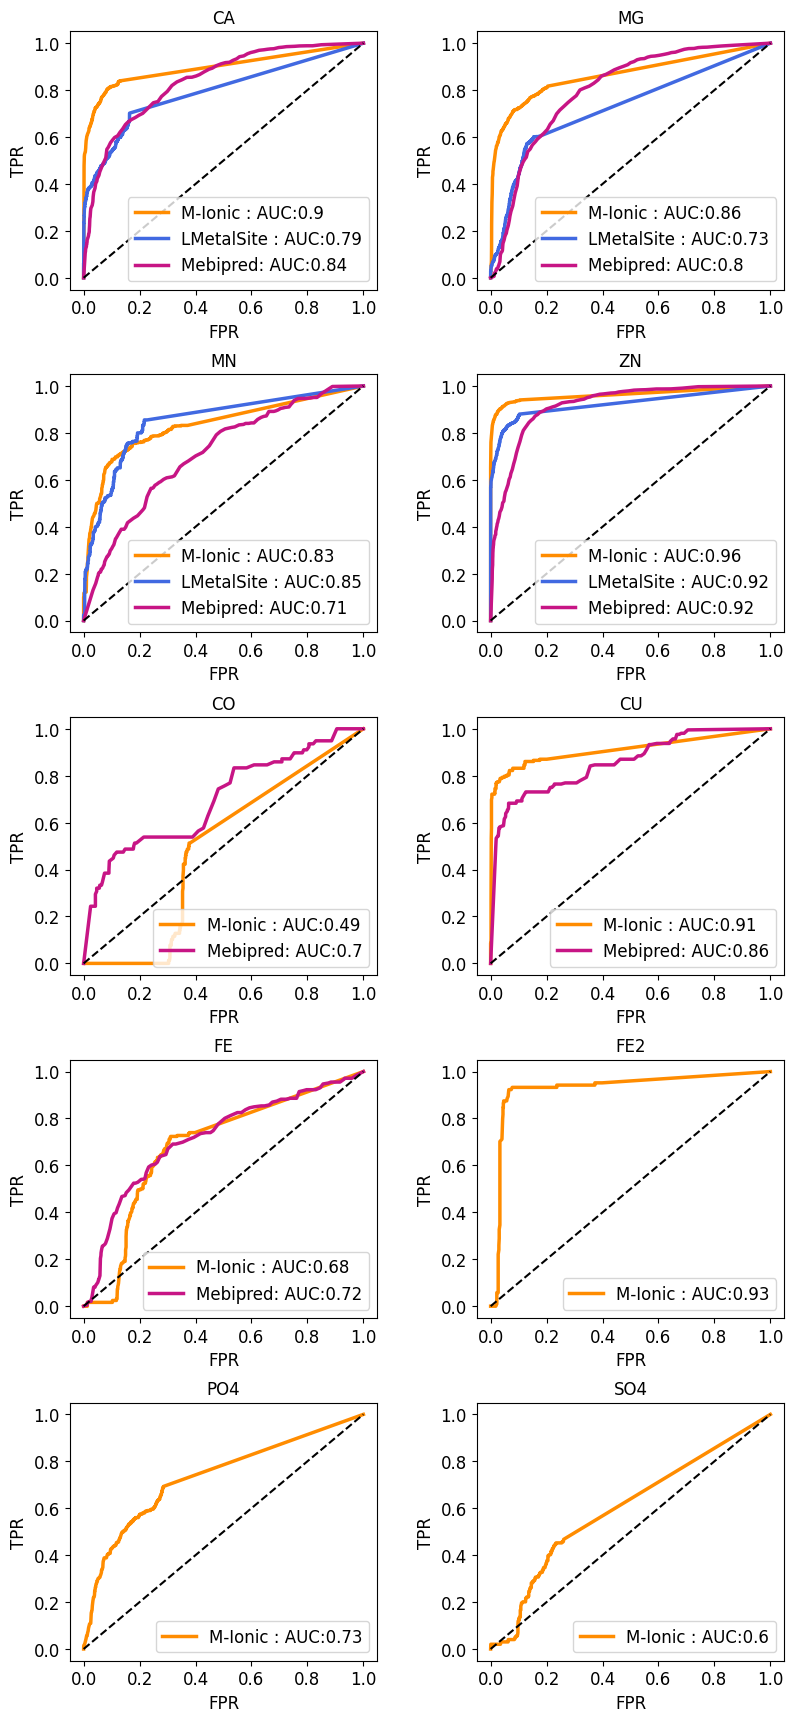

In [580]:
fields_ionic = ['CA','MG','MN','ZN','CO','CU','FE','FE2', 'PO4','SO4']
fields_lmetal = ['CA','MG','MN','ZN']
fields_mebipred = ['CA','MG','MN','ZN','CO','CU','FE']

figure, axes = plt.subplots(5,2, figsize=(8,17)) #sharex=True, sharey=True)
plt.setp(axes,xticks=np.arange(0.0, 1.1, step=0.2), yticks=np.arange(0, 1.1, step=0.2))
axes_ = axes.flatten()
figure.tight_layout(h_pad=3.0, w_pad=3.0)

for ion_index in range(len(fields_ionic)):
    ion = fields_ionic[ion_index]
    df_aux=(d3[d3['ion']==ion])
    
    p_esm, r_esm, _ = precision_recall_curve(df_aux['target'].values, df_aux['esm_pred'].values)    
    fpr_esm, tpr_esm, _ = roc_curve(df_aux['target'].values, df_aux['esm_pred'].values, pos_label=1)
    auc_esm = roc_auc_score(df_aux['target'].values, df_aux['esm_pred'].values)
    
    p_lm, r_lm, _ = precision_recall_curve(df_aux['target'].values, df_aux['lm_pred'].values)    
    fpr_lm, tpr_lm, _ = roc_curve(df_aux['target'].values, df_aux['lm_pred'].values, pos_label=1)
    auc_lm = roc_auc_score(df_aux['target'].values, df_aux['lm_pred'].values)
    
    p_mebi, r_mebi, _ = precision_recall_curve(df_aux['target'].values, df_aux['mebi_pred'].values)    
    fpr_mebi, tpr_mebi, _ = roc_curve(df_aux['target'].values, df_aux['mebi_pred'].values, pos_label=1)
    auc_mebi = roc_auc_score(df_aux['target'].values, df_aux['mebi_pred'].values)
    
    axes_[ion_index].plot(fpr_esm, tpr_esm, color='darkorange', linewidth=2.5,label='M-Ionic : AUC:%s'%(round(auc_esm,2)))
    
    if ion in fields_lmetal:
        axes_[ion_index].plot(fpr_lm, tpr_lm, color='royalblue', linewidth=2.5, label='LMetalSite : AUC:%s'%(round(auc_lm,2)))
    if ion in fields_mebipred:
        axes_[ion_index].plot(fpr_mebi, tpr_mebi, color='mediumvioletred', linewidth=2.5, label='Mebipred: AUC:%s'%(round(auc_mebi,2)))
    axes_[ion_index].set_xlabel('FPR',fontsize=12)
    axes_[ion_index].set_ylabel('TPR',fontsize=12)
    axes_[ion_index].legend(prop={'size':12}, loc='lower right')
    axes_[ion_index].tick_params(axis="x", labelsize=12)
    axes_[ion_index].tick_params(axis="y", labelsize=12)
    #axes_[ion_index].grid(color='black', linestyle='-.', linewidth=0.4)
    axes_[ion_index].plot([0, 1], ls="--", color='black')
    axes_[ion_index].set_title(ion,fontsize=12)#+' (MCC:%s)'%(round(mcc_esm, 2)))
    

plt.savefig('figures/Only_Recent_ROC_per_ion_5x2.png',  bbox_inches='tight',  pad_inches=0.5,dpi=350)
plt.show()

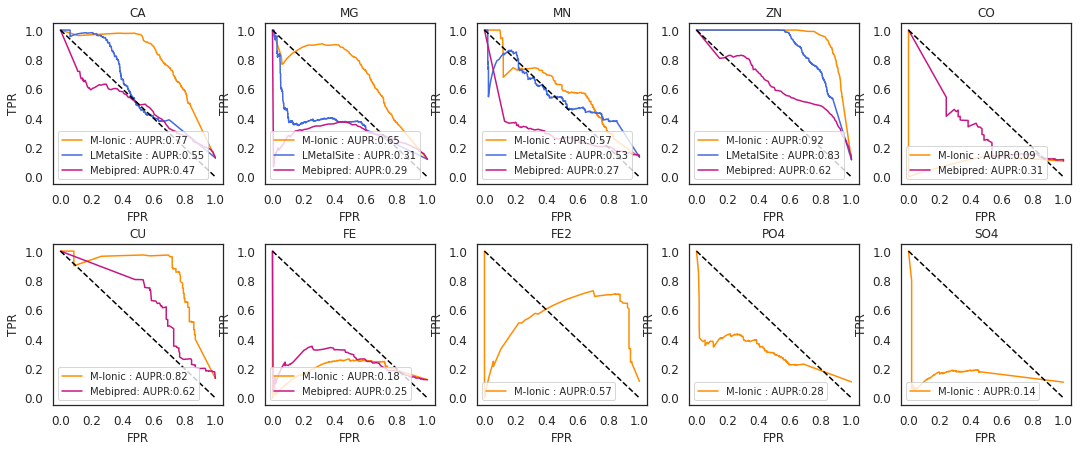

In [477]:
fields_ionic = ['CA','MG','MN','ZN','CO','CU','FE','FE2', 'PO4','SO4']
fields_lmetal = ['CA','MG','MN','ZN']
fields_mebipred = ['CA','MG','MN','ZN','CO','CU','FE']

figure, axes = plt.subplots(2,5, figsize=(15,6)) #sharex=True, sharey=True)
plt.setp(axes,xticks=np.arange(0.0, 1.1, step=0.2), yticks=np.arange(0, 1.1, step=0.2))
axes_ = axes.flatten()
figure.tight_layout(h_pad=3, w_pad=0.5)

for ion_index in range(len(fields_ionic)):
    ion = fields_ionic[ion_index]
    df_aux=(d3[d3['ion']==ion])
    
    p_esm, r_esm, _ = precision_recall_curve(df_aux['target'].values, df_aux['esm_pred'].values)    
    #mcc_esm = matthews_corrcoef(df_aux['target'].values, df_aux['esm_pbin'].values)
    fpr_esm, tpr_esm, _ = roc_curve(df_aux['target'].values, df_aux['esm_pred'].values, pos_label=1)
    auc_esm = roc_auc_score(df_aux['target'].values, df_aux['esm_pred'].values)
    aupr_esm = average_precision_score(df_aux['target'].values, df_aux['esm_pred'].values)
    
    p_lm, r_lm, _ = precision_recall_curve(df_aux['target'].values, df_aux['lm_pred'].values)    
    fpr_lm, tpr_lm, _ = roc_curve(df_aux['target'].values, df_aux['lm_pred'].values, pos_label=1)
    auc_lm = roc_auc_score(df_aux['target'].values, df_aux['lm_pred'].values)
    aupr_lm = average_precision_score(df_aux['target'].values, df_aux['lm_pred'].values)
    
    p_mebi, r_mebi, _ = precision_recall_curve(df_aux['target'].values, df_aux['mebi_pred'].values)    
    fpr_mebi, tpr_mebi, _ = roc_curve(df_aux['target'].values, df_aux['mebi_pred'].values, pos_label=1)
    auc_mebi = roc_auc_score(df_aux['target'].values, df_aux['mebi_pred'].values)
    aupr_mebi = average_precision_score(df_aux['target'].values, df_aux['mebi_pred'].values)
    
    axes_[ion_index].plot(r_esm, p_esm, color='darkorange', label='M-Ionic : AUPR:%s'%(round(aupr_esm,2)))
    
    if ion in fields_lmetal:
        axes_[ion_index].plot(r_lm, p_lm, color='royalblue', label='LMetalSite : AUPR:%s'%(round(aupr_lm,2)))
    if ion in fields_mebipred:
        axes_[ion_index].plot(r_mebi, p_mebi, color='mediumvioletred', label='Mebipred: AUPR:%s'%(round(aupr_mebi,2)))
    axes_[ion_index].set_xlabel('FPR',fontsize=12)
    axes_[ion_index].set_ylabel('TPR',fontsize=12)
    axes_[ion_index].legend(prop={'size':10}, loc='lower left')
    axes_[ion_index].tick_params(axis="x", labelsize=12)
    axes_[ion_index].tick_params(axis="y", labelsize=12)
    #axes_[ion_index].grid(color='black', linestyle='-.', linewidth=0.4)
    axes_[ion_index].plot([1, 0], ls="--", color='black')
    axes_[ion_index].set_title(ion,fontsize=12)#+' (MCC:%s)'%(round(mcc_esm, 2)))
    

plt.savefig('figures/Only_Recent_AUPR_per_ion_2x5.png',  bbox_inches='tight',  pad_inches=0.3,dpi=350)
plt.show()

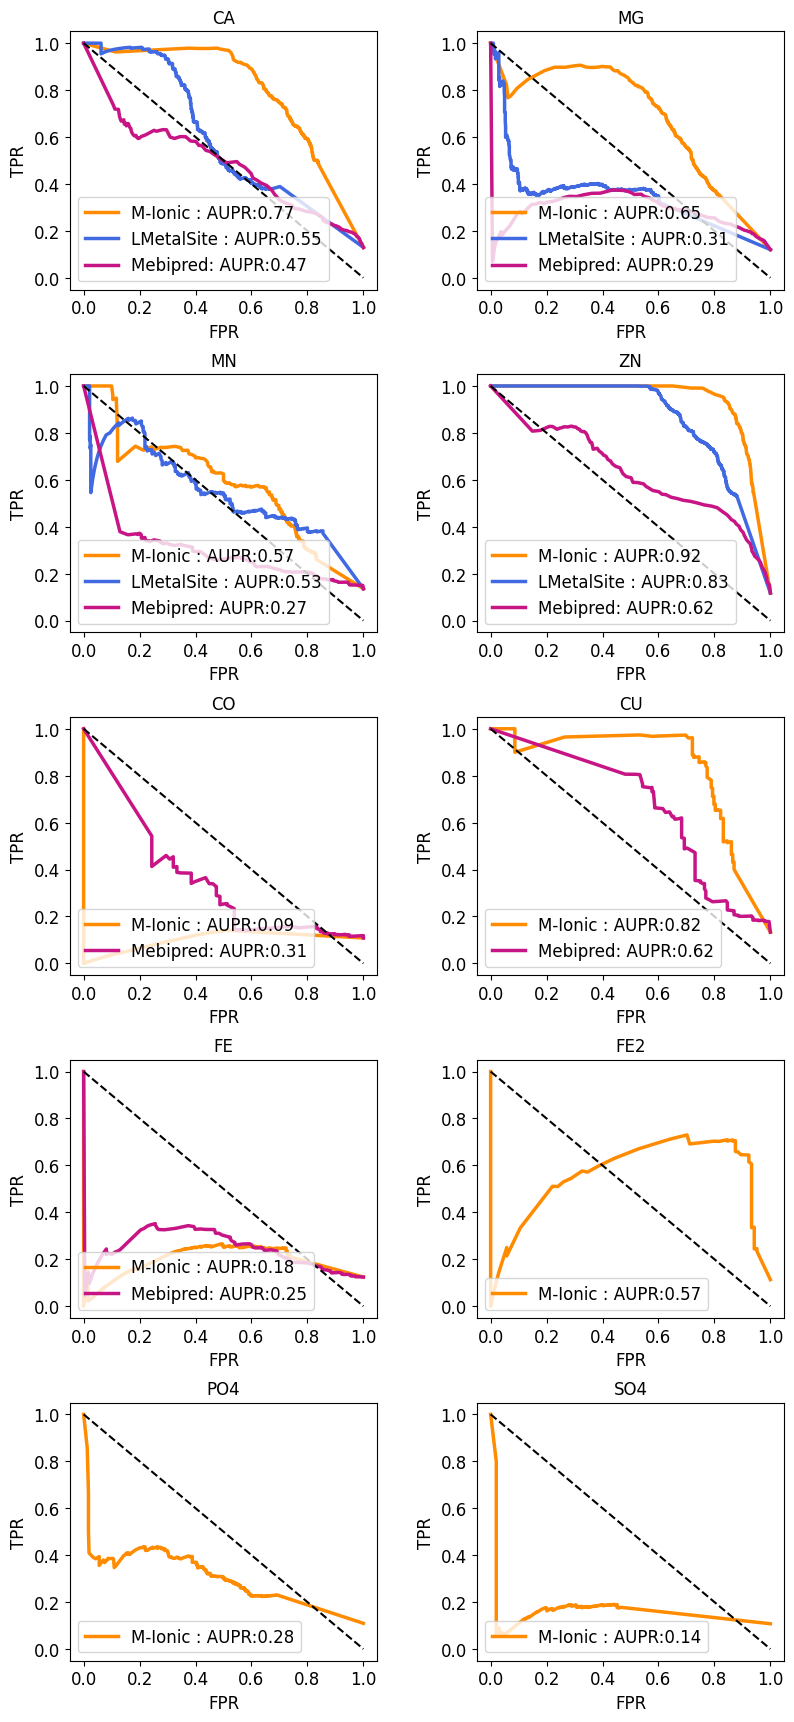

In [579]:
fields_ionic = ['CA','MG','MN','ZN','CO','CU','FE','FE2', 'PO4','SO4']
fields_lmetal = ['CA','MG','MN','ZN']
fields_mebipred = ['CA','MG','MN','ZN','CO','CU','FE']

figure, axes = plt.subplots(5,2, figsize=(8,17)) #sharex=True, sharey=True
plt.setp(axes,xticks=np.arange(0.0, 1.1, step=0.2), yticks=np.arange(0, 1.1, step=0.2))
axes_ = axes.flatten()
figure.tight_layout(h_pad=3, w_pad=3)


for ion_index in range(len(fields_ionic)):
    ion = fields_ionic[ion_index]
    df_aux=(d3[d3['ion']==ion])
    
    p_esm, r_esm, _ = precision_recall_curve(df_aux['target'].values, df_aux['esm_pred'].values)    
    #mcc_esm = matthews_corrcoef(df_aux['target'].values, df_aux['esm_pbin'].values)
    fpr_esm, tpr_esm, _ = roc_curve(df_aux['target'].values, df_aux['esm_pred'].values, pos_label=1)
    auc_esm = roc_auc_score(df_aux['target'].values, df_aux['esm_pred'].values)
    aupr_esm = average_precision_score(df_aux['target'].values, df_aux['esm_pred'].values)
    
    p_lm, r_lm, _ = precision_recall_curve(df_aux['target'].values, df_aux['lm_pred'].values)    
    fpr_lm, tpr_lm, _ = roc_curve(df_aux['target'].values, df_aux['lm_pred'].values, pos_label=1)
    auc_lm = roc_auc_score(df_aux['target'].values, df_aux['lm_pred'].values)
    aupr_lm = average_precision_score(df_aux['target'].values, df_aux['lm_pred'].values)
    
    p_mebi, r_mebi, _ = precision_recall_curve(df_aux['target'].values, df_aux['mebi_pred'].values)    
    fpr_mebi, tpr_mebi, _ = roc_curve(df_aux['target'].values, df_aux['mebi_pred'].values, pos_label=1)
    auc_mebi = roc_auc_score(df_aux['target'].values, df_aux['mebi_pred'].values)
    aupr_mebi = average_precision_score(df_aux['target'].values, df_aux['mebi_pred'].values)
    
    axes_[ion_index].plot(r_esm, p_esm, color='darkorange', linewidth=2.5, label='M-Ionic : AUPR:%s'%(round(aupr_esm,2)))
    
    if ion in fields_lmetal:
        axes_[ion_index].plot(r_lm, p_lm, color='royalblue', linewidth=2.5, label='LMetalSite : AUPR:%s'%(round(aupr_lm,2)))
    if ion in fields_mebipred:
        axes_[ion_index].plot(r_mebi, p_mebi, color='mediumvioletred',linewidth=2.5,  label='Mebipred: AUPR:%s'%(round(aupr_mebi,2)))
    axes_[ion_index].set_xlabel('FPR',fontsize=12)
    axes_[ion_index].set_ylabel('TPR',fontsize=12)
    axes_[ion_index].legend(prop={'size':12}, loc='lower left')
    axes_[ion_index].tick_params(axis="x", labelsize=12)
    axes_[ion_index].tick_params(axis="y", labelsize=12)
    #axes_[ion_index].grid(color='black', linestyle='-.', linewidth=0.4)
    axes_[ion_index].plot([1, 0], ls="--", color='black')
    axes_[ion_index].set_title(ion,fontsize=12)#+' (MCC:%s)'%(round(mcc_esm, 2)))
    

plt.savefig('figures/Only_Recent_AUPR_per_ion_5x2.png',  bbox_inches='tight',  pad_inches=0.5,dpi=350)
plt.show()

## Residue-level (MCC)

### Independent test set

In [628]:
# Ionic (esm2 batch128)
df_esm = pd.read_csv('data/ResidueLevel/esm/esm2_t33_650M_UR50D_pred_df.csv')

df1=df_esm[['sigmoid', 'binarized', 'labels']]
columns=list(df1)
print (columns)

for i in columns:
    df_esm[i] = df_esm[i].apply(lambda x: [(_.replace('[','').replace(']','')) for _ in x.split( )])#.apply(lambda x: list(filter(None, x)))#.apply(lambda x: _ for _ in x)
print (len(df_esm))

df_esm.head(4)

d_id=['CA','CO','CU','FE','FE2','MG','MN','PO4','SO4','ZN']

def flatten(l):
    return [int(item) for sublist in l for item in sublist]


df_esm1 = df_esm.groupby(['ion']).agg(list).reset_index()
df_esm1['true'] = df_esm1['labels'].apply(flatten)
df_esm1['pred'] = df_esm1['binarized'].apply(flatten)

df_esm1=df_esm1.drop(['pdbid', 'sigmoid', 'binarized','labels'], axis=1)
pid=[]
lid=[]
rocauc=[]
avgpr=[]
pre = []
rec =[]
f1=[]
mcc=[]

for i in df_esm1['ion']:
    
    prediction = df_esm1[df_esm1['ion']==i]['pred'].values[0]
    target = df_esm1[df_esm1['ion']==i]['true'].values[0]
    #fpr, tpr, threshold = roc_curve(target, prediction)
    #precision, recall, thresholds = precision_recall_curve(target, prediction)
    
    precision = precision_score(target, prediction)
    recall = recall_score(target, prediction)
    roc_auc = roc_auc_score(target, prediction)
    avg_pr = average_precision_score(target, prediction)
    f1score = f1_score(target, prediction, average='binary')
    mcc_score = matthews_corrcoef(target, prediction)
    #print (i, roc_auc, avg_pr, f1score, mcc_score)
            
    #pid.append(i)
    lid.append(i)
    rocauc.append(roc_auc)
    avgpr.append(avg_pr)
    f1.append(f1score)
    mcc.append(mcc_score)
    pre.append(precision)
    rec.append(recall)

b = pd.Series(lid)
c = pd.Series(rocauc)
d = pd.Series(avgpr)
e = pd.Series(f1)
f = pd.Series(mcc)
g = pd.Series(pre)
h = pd.Series(rec)

out_df = pd.DataFrame({'Ligand Type':b, 'ROC-AUC':c, 'Avg_P':d, 'F1':e, 'MCC':f, 'Precision':g, 'Recall':h})
out_df=out_df.rename(columns={"ROC-AUC": "ROC-AUC Score", "Avg_P": "Average Precision", "F1":"F1-score", "LIG":"Ligand Type"})
out_df['Method']='M-Ionic (ESM-2)'
out_df

['sigmoid', 'binarized', 'labels']
3294


,Ligand Type,ROC-AUC Score,Average Precision,F1-score,MCC,Precision,Recall,Method
0,CA,0.769989,0.297115,0.537722,0.529477,0.527178,0.548695,M-Ionic (ESM-2)
1,CO,0.631624,0.223175,0.397351,0.455517,0.800000,0.264317,M-Ionic (ESM-2)
2,CU,0.914701,0.594896,0.767049,0.765606,0.709384,0.834917,M-Ionic (ESM-2)
3,FE,0.927863,0.653364,0.804668,0.801891,0.754520,0.861957,M-Ionic (ESM-2)
4,FE2,0.844451,0.555974,0.740741,0.739125,0.797546,0.691489,M-Ionic (ESM-2)
5,MG,0.714089,0.215860,0.456503,0.450772,0.481536,0.433943,M-Ionic (ESM-2)
6,MN,0.861716,0.570897,0.752607,0.749821,0.780952,0.726248,M-Ionic (ESM-2)
7,PO4,0.669183,0.162438,0.385201,0.377128,0.432763,0.347059,M-Ionic (ESM-2)
8,SO4,0.624754,0.147681,0.342711,0.357992,0.527559,0.253788,M-Ionic (ESM-2)
9,ZN,0.932272,0.644633,0.799056,0.798444,0.739389,0.869199,M-Ionic (ESM-2)


In [629]:
## Ionic ProtT5
df_prott5 = pd.read_csv('data/ResidueLevel/ProtT5/ProtT5_XL_UniRef50_pred_df.csv',  index_col=0,)# converters={'COLUMN_NAME': pd.eval})
df1=df_prott5[['sigmoid', 'binarized', 'labels']]
columns=list(df1)
print (columns)

for i in columns:
    df_prott5[i] = df_prott5[i].apply(lambda x: [(_.replace('[','').replace(']','')) for _ in x.split( )])#.apply(lambda x: list(filter(None, x)))#.apply(lambda x: _ for _ in x)
df_prott5.head(4)

d_id=['CA','CO','CU','FE','FE2','MG','MN','PO4','SO4','ZN']

def flatten(l):
    return [int(item) for sublist in l for item in sublist]


df_prott51 = df_prott5.groupby(['ion']).agg(list).reset_index()
df_prott51['true'] = df_prott5['labels'].apply(flatten)
df_prott51['pred'] = df_prott5['binarized'].apply(flatten)

df_prott51=df_prott51.drop(['pdbid', 'sigmoid', 'binarized','labels'], axis=1)

df_prott51

pid=[]
lid=[]
rocauc=[]
avgpr=[]
f1=[]
mcc=[]
pre = []
rec =[]

for i in df_prott51['ion']:
    
    prediction = df_prott51[df_prott51['ion']==i]['pred'].values[0]
    target = df_prott51[df_prott51['ion']==i]['true'].values[0]
    #fpr, tpr, threshold = roc_curve(target, prediction)
    #precision, recall, thresholds = precision_recall_curve(target, prediction)
    
    precision = precision_score(target, prediction, zero_division=0)
    recall = recall_score(target, prediction, zero_division=0)
    roc_auc = roc_auc_score(target, prediction)
    avg_pr = average_precision_score(target, prediction)
    f1score = f1_score(target, prediction, average='binary')
    mcc_score = matthews_corrcoef(target, prediction)
    #print (i, roc_auc, avg_pr, f1score, mcc_score)
        
    lid.append(i)
    rocauc.append(roc_auc)
    avgpr.append(avg_pr)
    f1.append(f1score)
    mcc.append(mcc_score)
    pre.append(precision)
    rec.append(recall)

b = pd.Series(lid)
c = pd.Series(rocauc)
d = pd.Series(avgpr)
e = pd.Series(f1)
f = pd.Series(mcc)
g = pd.Series(pre)
h = pd.Series(rec)

out_df_p = pd.DataFrame({'Ligand Type':b, 'ROC-AUC':c, 'Avg_P':d, 'F1':e, 'MCC':f, 'Precision':g, 'Recall':h})
out_df_p=out_df_p.rename(columns={"ROC-AUC": "ROC-AUC Score", "Avg_P": "Average Precision", "F1":"F1-score", "LIG":"Ligand Type"})
out_df_p['Method']='M-Ionic (ProtT5-XL)'
out_df_p

['sigmoid', 'binarized', 'labels']


,Ligand Type,ROC-AUC Score,Average Precision,F1-score,MCC,Precision,Recall,Method
0,CA,0.498789,0.004819,0.000000,-0.003420,0.000000,0.000000,M-Ionic (ProtT5-XL)
1,CO,0.995775,0.400000,0.571429,0.629778,0.400000,1.000000,M-Ionic (ProtT5-XL)
2,CU,0.872101,0.452865,0.666667,0.666602,0.600000,0.750000,M-Ionic (ProtT5-XL)
3,FE,0.665266,0.233242,0.444444,0.465491,0.666667,0.333333,M-Ionic (ProtT5-XL)
4,FE2,0.993421,0.888889,0.941176,0.936586,0.888889,1.000000,M-Ionic (ProtT5-XL)
5,MG,0.700000,0.409524,0.571429,0.629417,1.000000,0.400000,M-Ionic (ProtT5-XL)
6,MN,0.742424,0.264706,0.500000,0.484848,0.500000,0.500000,M-Ionic (ProtT5-XL)
7,PO4,0.500000,0.004566,0.000000,0.000000,0.000000,0.000000,M-Ionic (ProtT5-XL)
8,SO4,0.500000,0.020202,0.000000,0.000000,0.000000,0.000000,M-Ionic (ProtT5-XL)
9,ZN,0.597423,0.149777,0.300000,0.333215,0.600000,0.200000,M-Ionic (ProtT5-XL)


In [630]:
# Ionic (esm_msa batch128)
df_esm1b = pd.read_csv('data/ResidueLevel/esm_msa/pred_esm_msa1b_t12_100M_UR50S_batch128_CV_fold1.csv')
df_esm1b.head(4)

df1=df_esm1b[['target', 'predictions']]
columns=list(df1)
print (columns)

for i in columns:
    df_esm1b[i] = df_esm1b[i].apply(lambda x: [ (_.replace('[','').replace(']','')) for _ in x.split(', ')]).apply(lambda x: [float(x1) for x1 in x])#.apply(lambda x: _ for _ in x)
print (len(df_esm1b))
df_esm1b.head(4)

d_id=['CA','CO','CU','FE','FE2','MG','MN','PO4','SO4','ZN']

def flatten(l):
    return [(item) for sublist in l for item in sublist]


df_esm1 = df_esm1b.groupby(['ions']).agg(list).reset_index()
df_esm1['true'] = df_esm1['target'].apply(flatten)
df_esm1['pred'] = df_esm1['predictions'].apply(flatten)

df_esm1=df_esm1.drop(['pdbid', 'target', 'predictions'], axis=1)
df_esm1

pid=[]
lid=[]
rocauc=[]
avgpr=[]
f1=[]
mcc=[]
pre = []
rec =[]

for i in df_esm1['ions']:
    
    prediction = df_esm1[df_esm1['ions']==i]['pred'].values[0]
    target = df_esm1[df_esm1['ions']==i]['true'].values[0]
    #print (i,prediction, target)
    #fpr, tpr, threshold = roc_curve(target, prediction)
    #precision, recall, thresholds = precision_recall_curve(target, prediction)
            
    precision = precision_score(target, prediction, zero_division=0)
    recall = recall_score(target, prediction, zero_division=0)
    roc_auc = roc_auc_score(target, prediction)
    avg_pr = average_precision_score(target, prediction)
    f1score = f1_score(target, prediction, average='binary')
    mcc_score = matthews_corrcoef(target, prediction)
    #print (i, roc_auc, avg_pr, f1score, mcc_score)
        
    lid.append(i)
    rocauc.append(roc_auc)
    avgpr.append(avg_pr)
    f1.append(f1score)
    mcc.append(mcc_score)
    pre.append(precision)
    rec.append(recall)

b = pd.Series(lid)
c = pd.Series(rocauc)
d = pd.Series(avgpr)
e = pd.Series(f1)
f = pd.Series(mcc)
g = pd.Series(pre)
h = pd.Series(rec)


out_df_esm_msa_b128 = pd.DataFrame({'Ligand Type':b, 'ROC-AUC':c, 'Avg_P':d, 'F1':e, 'MCC':f, 'Precision':g, 'Recall':h})
out_df_esm_msa_b128=out_df_esm_msa_b128.rename(columns={"ROC-AUC": "ROC-AUC Score", "Avg_P": "Average Precision", "F1":"F1-score", "LIG":"Ligand Type"})
out_df_esm_msa_b128['Method']='M-Ionic (ESM-MSA-1b)'
out_df_esm_msa_b128

['target', 'predictions']
3293


,Ligand Type,ROC-AUC Score,Average Precision,F1-score,MCC,Precision,Recall,Method
0,CA,0.706922,0.125859,0.330682,0.325865,0.266709,0.435030,M-Ionic (ESM-MSA-1b)
1,CO,0.526253,0.052405,0.098361,0.190448,0.705882,0.052863,M-Ionic (ESM-MSA-1b)
2,CU,0.890308,0.462433,0.669688,0.671644,0.581294,0.789786,M-Ionic (ESM-MSA-1b)
3,FE,0.690411,0.300355,0.507184,0.528820,0.747881,0.383696,M-Ionic (ESM-MSA-1b)
4,FE2,0.897134,0.613552,0.781250,0.778133,0.765306,0.797872,M-Ionic (ESM-MSA-1b)
5,MG,0.661088,0.150207,0.373151,0.370206,0.433671,0.327454,M-Ionic (ESM-MSA-1b)
6,MN,0.795974,0.439161,0.655142,0.654297,0.728797,0.595008,M-Ionic (ESM-MSA-1b)
7,PO4,0.590421,0.088993,0.253333,0.262295,0.395833,0.186275,M-Ionic (ESM-MSA-1b)
8,SO4,0.548386,0.067875,0.165605,0.220689,0.520000,0.098485,M-Ionic (ESM-MSA-1b)
9,ZN,0.910041,0.590169,0.764443,0.762733,0.712057,0.825149,M-Ionic (ESM-MSA-1b)


In [631]:
## LmetalSite

df1 = pd.read_csv('data/ResidueLevel/lmetal/split_test_1_predictions.csv')
df2 = pd.read_csv('data/ResidueLevel/lmetal/split_test_2_predictions.csv')
df3 = pd.read_csv('data/ResidueLevel/lmetal/split_test_3_predictions.csv')
df4 = pd.read_csv('data/ResidueLevel/lmetal/split_test_4_predictions.csv')
df5 = pd.read_csv('data/ResidueLevel/lmetal/split_test_5_predictions.csv')
df6 = pd.read_csv('data/ResidueLevel/lmetal/split_test_6_predictions.csv')
df7 = pd.read_csv('data/ResidueLevel/lmetal/split_test_7_predictions.csv')
df8 = pd.read_csv('data/ResidueLevel/lmetal/split_test_8_predictions.csv')

result = [df1,df2,df3,df4,df5,df6,df7,df8]
df = pd.concat(result, ignore_index=True)
print (len(df))

df1=df[['ZN_pred','CA_pred', 'MG_pred', 'MN_pred']]
columns=list(df1)
print (columns)

for i in columns:
    df[i] = df[i].apply(lambda x: x.split(',')).apply(lambda x: [float(x1) for x1 in x])
    
df = df.drop(['ZN_prob','CA_prob', 'MG_prob', 'MN_prob', 'Sequence'], axis=1)
pred_list = ['ZN', 'CA', 'MG', 'MN']
df.head(5)

df=df.rename(columns={"ID": "pdbid"})

dfm = df_esm1b.merge(df, on='pdbid')
dfm = dfm.drop(['predictions'], axis=1)

pdb_lst = []
ion_lst = []
target_lst = []
prediction_lst=[]
for i in dfm['pdbid']:
    ion = dfm[dfm['pdbid']==i]['ions'].values[0]
    
    if ion in pred_list:
        col_name = '{}_pred'.format(ion)
        prediction = dfm[dfm['pdbid']==i][col_name].values[0]
        #print (i, ion, col_name, prediction)
        pdb_lst.append(i)
        ion_lst.append(ion)
        target_lst.append(dfm[dfm['pdbid']==i]['target'].values[0])
        prediction_lst.append(prediction)
        
dfm1=pd.DataFrame()
dfm1['pdbid']=pdb_lst
dfm1['ions']=ion_lst
dfm1['target']=target_lst
dfm1['predictions']=prediction_lst
dfm1['tlen'] = dfm1.target.str.len()
dfm1['plen'] = dfm1.predictions.str.len()

dfm1.head(4)

d_id=['CA','CO','CU','FE','FE2','MG','MN','PO4','SO4','ZN']

def flatten(l):
    return [(item) for sublist in l for item in sublist]


df_esm1 = dfm1.groupby(['ions']).agg(list).reset_index()
df_esm1['true'] = df_esm1['target'].apply(flatten)
df_esm1['pred'] = df_esm1['predictions'].apply(flatten)

df_esm1=df_esm1.drop(['pdbid', 'target', 'predictions'], axis=1)
df_esm1

pid=[]
lid=[]
rocauc=[]
avgpr=[]
f1=[]
mcc=[]
pre = []
rec =[]

for i in df_esm1['ions']:
    
    prediction = df_esm1[df_esm1['ions']==i]['pred'].values[0]
    target = df_esm1[df_esm1['ions']==i]['true'].values[0]
    #print (i,prediction, target)
    #fpr, tpr, threshold = roc_curve(target, prediction)
    #precision, recall, thresholds = precision_recall_curve(target, prediction)
    precision = precision_score(target, prediction, zero_division=0)
    recall = recall_score(target, prediction, zero_division=0)
    
    roc_auc = roc_auc_score(target, prediction)
    avg_pr = average_precision_score(target, prediction)
    f1score = f1_score(target, prediction, average='binary')
    mcc_score = matthews_corrcoef(target, prediction)
    #print (i, roc_auc, avg_pr, f1score, mcc_score)
            
    lid.append(i)
    rocauc.append(roc_auc)
    avgpr.append(avg_pr)
    f1.append(f1score)
    mcc.append(mcc_score)
    pre.append(precision)
    rec.append(recall)

b = pd.Series(lid)
c = pd.Series(rocauc)
d = pd.Series(avgpr)
e = pd.Series(f1)
f = pd.Series(mcc)
g = pd.Series(pre)
h = pd.Series(rec)

out_df_lmetal = pd.DataFrame({'Ligand Type':b, 'ROC-AUC':c, 'Avg_P':d, 'F1':e, 'MCC':f, 'Precision':g, 'Recall':h})
out_df_lmetal=out_df_lmetal.rename(columns={"ROC-AUC": "ROC-AUC Score", "Avg_P": "Average Precision", "F1":"F1-score", "LIG":"Ligand Type"})
out_df_lmetal['Method']='LMetalSite'
out_df_lmetal

3002
['ZN_pred', 'CA_pred', 'MG_pred', 'MN_pred']


,Ligand Type,ROC-AUC Score,Average Precision,F1-score,MCC,Precision,Recall,Method
0,CA,0.681415,0.307820,0.503528,0.540173,0.815161,0.364269,LMetalSite
1,MG,0.639635,0.214168,0.405731,0.449762,0.732950,0.280503,LMetalSite
2,MN,0.856500,0.597814,0.768452,0.767614,0.830447,0.715071,LMetalSite
3,ZN,0.888830,0.670530,0.815906,0.814068,0.855619,0.779716,LMetalSite


In [632]:
# Ionic (esm2 batch128)
df_esm1b = pd.read_csv('../../benchmark/DSSP/pred_dssp_batch128_CV_fold1.csv')

df1=df_esm1b[['target', 'predictions']]
columns=list(df1)
print (columns)

for i in columns:
    df_esm1b[i] = df_esm1b[i].apply(lambda x: [ (_.replace('[','').replace(']','')) for _ in x.split(', ')]).apply(lambda x: [float(x1) for x1 in x])#.apply(lambda x: _ for _ in x)
print (len(df_esm1b))
df_esm1b.head(4)

d_id=['CA','CO','CU','FE','FE2','MG','MN','PO4','SO4','ZN']

def flatten(l):
    return [(item) for sublist in l for item in sublist]


df_esm1 = df_esm1b.groupby(['ions']).agg(list).reset_index()
df_esm1['true'] = df_esm1['target'].apply(flatten)
df_esm1['pred'] = df_esm1['predictions'].apply(flatten)

df_esm1=df_esm1.drop(['pdbid', 'target', 'predictions'], axis=1)
df_esm1

pid=[]
lid=[]
rocauc=[]
avgpr=[]
f1=[]
mcc=[]
pre = []
rec =[]

for i in df_esm1['ions']:
    
    prediction = df_esm1[df_esm1['ions']==i]['pred'].values[0]
    target = df_esm1[df_esm1['ions']==i]['true'].values[0]
    #print (i,prediction, target)
    #fpr, tpr, threshold = roc_curve(target, prediction)
    #precision, recall, thresholds = precision_recall_curve(target, prediction)
            
    precision = precision_score(target, prediction, zero_division=0)
    recall = recall_score(target, prediction, zero_division=0)
    roc_auc = roc_auc_score(target, prediction)
    avg_pr = average_precision_score(target, prediction)
    f1score = f1_score(target, prediction, average='binary')
    mcc_score = matthews_corrcoef(target, prediction)
    #print (i, roc_auc, avg_pr, f1score, mcc_score)
        
    lid.append(i)
    rocauc.append(roc_auc)
    avgpr.append(avg_pr)
    f1.append(f1score)
    mcc.append(mcc_score)
    pre.append(precision)
    rec.append(recall)

b = pd.Series(lid)
c = pd.Series(rocauc)
d = pd.Series(avgpr)
e = pd.Series(f1)
f = pd.Series(mcc)
g = pd.Series(pre)
h = pd.Series(rec)

out_df_dssp= pd.DataFrame({'Ligand Type':b, 'ROC-AUC':c, 'Avg_P':d, 'F1':e, 'MCC':f, 'Precision':g, 'Recall':h})
out_df_dssp=out_df_dssp.rename(columns={"ROC-AUC": "ROC-AUC Score", "Avg_P": "Average Precision", "F1":"F1-score", "LIG":"Ligand Type"})
out_df_dssp['Method']='DSSP'
out_df_dssp

['target', 'predictions']
2776


,Ligand Type,ROC-AUC Score,Average Precision,F1-score,MCC,Precision,Recall,Method
0,CA,0.515938,0.020850,0.055445,0.053389,0.106383,0.037493,DSSP
1,CO,0.500000,0.016239,0.000000,0.000000,0.000000,0.000000,DSSP
2,CU,0.500000,0.015699,0.000000,0.000000,0.000000,0.000000,DSSP
3,FE,0.500000,0.021809,0.000000,0.000000,0.000000,0.000000,DSSP
4,FE2,0.500000,0.014817,0.000000,0.000000,0.000000,0.000000,DSSP
5,MG,0.503806,0.013285,0.015664,0.028750,0.120879,0.008375,DSSP
6,MN,0.500000,0.013482,0.000000,0.000000,0.000000,0.000000,DSSP
7,PO4,0.500000,0.019219,0.000000,0.000000,0.000000,0.000000,DSSP
8,SO4,0.500000,0.017911,0.000000,0.000000,0.000000,0.000000,DSSP
9,ZN,0.517405,0.021058,0.062135,0.078165,0.189567,0.037157,DSSP


In [633]:
# Ionic (esm2 +dssp)
df_esm1b = pd.read_csv('../../benchmark/DSSP/pred_dssp_esm_batch128_CV_fold1.csv')

df1=df_esm1b[['target', 'predictions']]
columns=list(df1)
print (columns)

for i in columns:
    df_esm1b[i] = df_esm1b[i].apply(lambda x: [ (_.replace('[','').replace(']','')) for _ in x.split(', ')]).apply(lambda x: [float(x1) for x1 in x])#.apply(lambda x: _ for _ in x)
print (len(df_esm1b))
df_esm1b.head(4)

d_id=['CA','CO','CU','FE','FE2','MG','MN','PO4','SO4','ZN']

def flatten(l):
    return [(item) for sublist in l for item in sublist]


df_esm1 = df_esm1b.groupby(['ions']).agg(list).reset_index()
df_esm1['true'] = df_esm1['target'].apply(flatten)
df_esm1['pred'] = df_esm1['predictions'].apply(flatten)

df_esm1=df_esm1.drop(['pdbid', 'target', 'predictions'], axis=1)
df_esm1

pid=[]
lid=[]
rocauc=[]
avgpr=[]
f1=[]
mcc=[]
pre = []
rec =[]

for i in df_esm1['ions']:
    
    prediction = df_esm1[df_esm1['ions']==i]['pred'].values[0]
    target = df_esm1[df_esm1['ions']==i]['true'].values[0]
    #print (i,prediction, target)
    #fpr, tpr, threshold = roc_curve(target, prediction)
    #precision, recall, thresholds = precision_recall_curve(target, prediction)
            
    precision = precision_score(target, prediction, zero_division=0)
    recall = recall_score(target, prediction, zero_division=0)
    roc_auc = roc_auc_score(target, prediction)
    avg_pr = average_precision_score(target, prediction)
    f1score = f1_score(target, prediction, average='binary')
    mcc_score = matthews_corrcoef(target, prediction)
    #print (i, roc_auc, avg_pr, f1score, mcc_score)
        
    lid.append(i)
    rocauc.append(roc_auc)
    avgpr.append(avg_pr)
    f1.append(f1score)
    mcc.append(mcc_score)
    pre.append(precision)
    rec.append(recall)

b = pd.Series(lid)
c = pd.Series(rocauc)
d = pd.Series(avgpr)
e = pd.Series(f1)
f = pd.Series(mcc)
g = pd.Series(pre)
h = pd.Series(rec)

out_df_dssp_esm= pd.DataFrame({'Ligand Type':b, 'ROC-AUC':c, 'Avg_P':d, 'F1':e, 'MCC':f, 'Precision':g, 'Recall':h})
out_df_dssp_esm=out_df_dssp_esm.rename(columns={"ROC-AUC": "ROC-AUC Score", "Avg_P": "Average Precision", "F1":"F1-score", "LIG":"Ligand Type"})
out_df_dssp_esm['Method']='ESM2+DSSP'
out_df_dssp_esm

['target', 'predictions']
2776


,Ligand Type,ROC-AUC Score,Average Precision,F1-score,MCC,Precision,Recall,Method
0,CA,0.709252,0.178641,0.410234,0.399672,0.391862,0.430414,ESM2+DSSP
1,CO,0.518499,0.038637,0.070485,0.148959,0.615385,0.037383,ESM2+DSSP
2,CU,0.849970,0.366390,0.593248,0.594168,0.509022,0.710875,ESM2+DSSP
3,FE,0.804006,0.483116,0.684142,0.682903,0.775632,0.611958,ESM2+DSSP
4,FE2,0.875230,0.552519,0.740741,0.736899,0.727273,0.754717,ESM2+DSSP
5,MG,0.665669,0.153785,0.378610,0.374747,0.432129,0.336886,ESM2+DSSP
6,MN,0.789909,0.449876,0.660480,0.662615,0.762926,0.582291,ESM2+DSSP
7,PO4,0.618454,0.114494,0.305772,0.306038,0.410042,0.243781,ESM2+DSSP
8,SO4,0.560471,0.064458,0.188925,0.213280,0.391892,0.124464,ESM2+DSSP
9,ZN,0.896330,0.544295,0.733333,0.731571,0.678178,0.798254,ESM2+DSSP


In [634]:
#result1 = [out_df, out_df_p, out_df_esm_msa_b128, out_df_dssp, out_df_dssp_esm,out_df_lmetal]
result1 = [out_df_lmetal, out_df]
df_out = pd.concat(result1, ignore_index=True)
#df_out=df_out.sort_values(['Method','Ligand Type'], ascending=False)
df_out

df_out = df_out.reset_index(drop=True)
df_out
#df_out.to_csv('dssp_compare.csv', index=False)

,Ligand Type,ROC-AUC Score,Average Precision,F1-score,MCC,Precision,Recall,Method
0,CA,0.681415,0.307820,0.503528,0.540173,0.815161,0.364269,LMetalSite
1,MG,0.639635,0.214168,0.405731,0.449762,0.732950,0.280503,LMetalSite
2,MN,0.856500,0.597814,0.768452,0.767614,0.830447,0.715071,LMetalSite
3,ZN,0.888830,0.670530,0.815906,0.814068,0.855619,0.779716,LMetalSite
4,CA,0.769989,0.297115,0.537722,0.529477,0.527178,0.548695,M-Ionic (ESM-2)
5,CO,0.631624,0.223175,0.397351,0.455517,0.800000,0.264317,M-Ionic (ESM-2)
6,CU,0.914701,0.594896,0.767049,0.765606,0.709384,0.834917,M-Ionic (ESM-2)
7,FE,0.927863,0.653364,0.804668,0.801891,0.754520,0.861957,M-Ionic (ESM-2)
8,FE2,0.844451,0.555974,0.740741,0.739125,0.797546,0.691489,M-Ionic (ESM-2)
9,MG,0.714089,0.215860,0.456503,0.450772,0.481536,0.433943,M-Ionic (ESM-2)


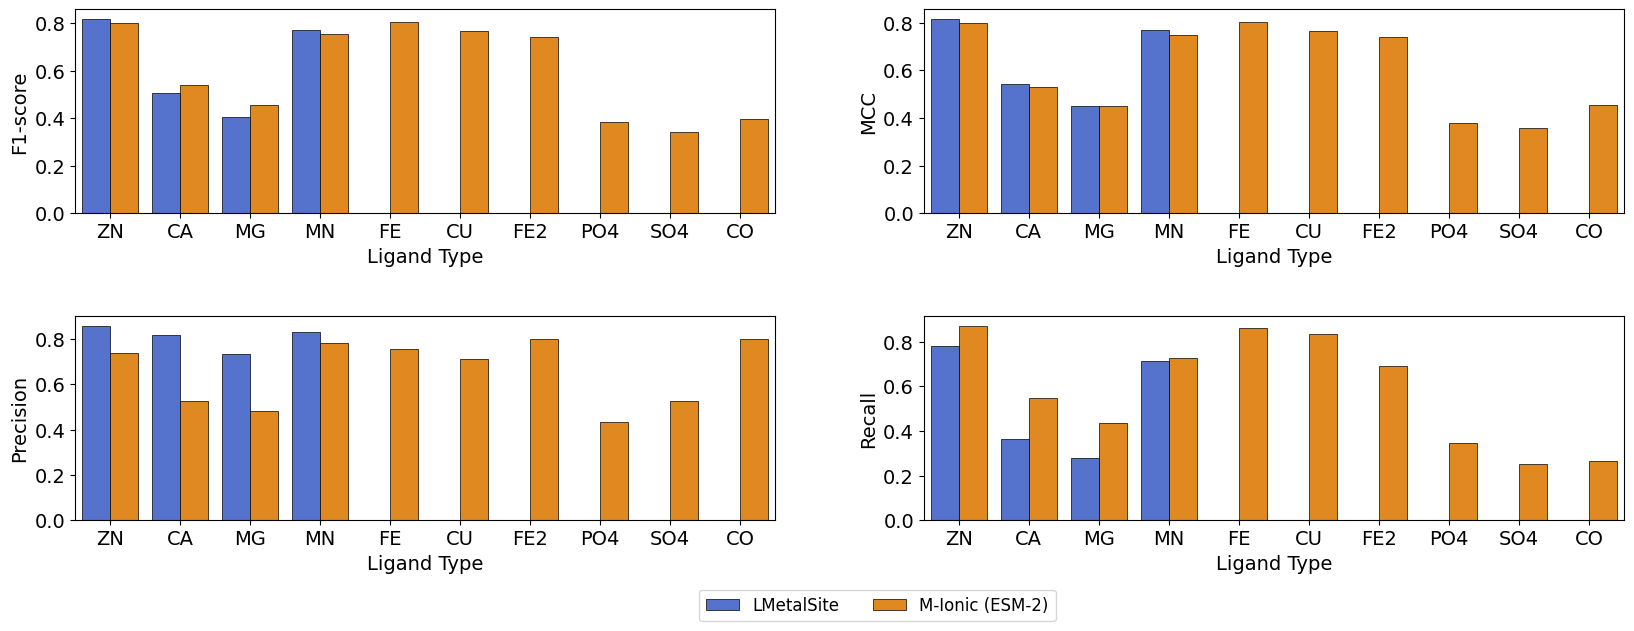

In [635]:
import matplotlib 

figure, axes = plt.subplots(2,2, figsize=(16.5,6))
matplotlib.rc('font', size=14)
matplotlib.rc('axes', titlesize=14)

order=['ZN','CA','MG','MN','FE','CU','FE2','PO4','SO4','CO']
matplotlib.rc('font', size=12)
matplotlib.rc('axes', titlesize=12)
matplotlib.rc('axes', titlesize=12)

#'darkorange','royalblue','seagreen','crimson'
sns.barplot(data=df_out, y='F1-score', x='Ligand Type',  hue='Method',palette=['royalblue','darkorange'], linewidth=0.5, edgecolor="0",order=order, ax=axes[0,0])
sns.barplot(data=df_out, y='MCC', x='Ligand Type',  hue='Method',palette=['royalblue','darkorange'], linewidth=0.5, edgecolor="0",order=order, ax=axes[0,1])
sns.barplot(data=df_out, y='Precision', x='Ligand Type', hue='Method', palette=['royalblue','darkorange'], linewidth=0.5, edgecolor="0",ax=axes[1,0],order=order)
sns.barplot(data=df_out, y='Recall', x='Ligand Type',  hue='Method', palette=['royalblue','darkorange'], linewidth=0.5, edgecolor="0",ax=axes[1,1],order=order)
figure.tight_layout(h_pad=3, w_pad=5)

axes[0,0].legend([],[], frameon=False)
axes[0,1].legend([],[], frameon=False)
axes[1,0].legend([],[], frameon=False)
axes[1,1].legend([],[], frameon=False)
#plt.legend()
#plt.legend(bbox_to_anchor=(1,1.5))
#plt.legend(bbox_to_anchor=(-0.5,-0.3), ncol=3)
#axes.tick_params(axis='x', labelsize=20)
plt.legend(bbox_to_anchor=(0.2,-0.3), ncol=2)
#plt.legend(loc='lower right',bbox_to_anchor=(0.3,-0.1))

plt.savefig('figures/TestFold6_precision_recall_f1_mcc_esm2_lmetal_2x2.png', bbox_inches='tight',  pad_inches=0.6, dpi=350)
#plt.savefig('figures/TestFold6_DSSP_precision_recall_f1_mcc_esm2_lmetal_2x2.png',  bbox_inches='tight',  pad_inches=0.3,dpi=350)
plt.show()

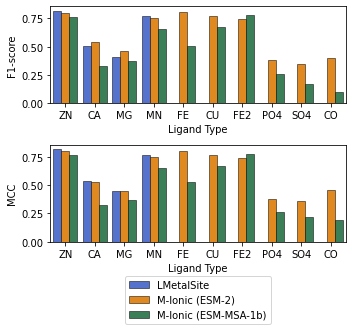

In [67]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
figure, axes = plt.subplots(2,1, figsize=(5,4))
#plt.figure(figsize=(6, 4))
order=['ZN','CA','MG','MN','FE','CU','FE2','PO4','SO4','CO']


sns.barplot(data=df_out, y='F1-score', x='Ligand Type',  hue='Method',palette=['royalblue','darkorange','seagreen'], linewidth=0.5, edgecolor="0",order=order, ax=axes[0])
sns.barplot(data=df_out, y='MCC', x='Ligand Type',  hue='Method',palette=['royalblue','darkorange','seagreen'], linewidth=0.5, edgecolor="0",order=order, ax=axes[1])
#sns.barplot(data=df_out, y='Precision', x='Ligand Type', hue='Method', palette=['royalblue','darkorange','seagreen'], linewidth=0.5, edgecolor="0",ax=axes[2],order=order)
#sns.barplot(data=df_out, y='Recall', x='Ligand Type',  hue='Method', palette=['royalblue','darkorange','seagreen'], linewidth=0.5, edgecolor="0",ax=axes[3],order=order)
figure.tight_layout()

axes[0].legend([],[], frameon=False)
axes[1].legend([],[], frameon=False)
#axes[2].legend([],[], frameon=False)
#axes[3].legend([],[], frameon=False)
#plt.legend()
#plt.legend(bbox_to_anchor=(1,1.5))
plt.legend(loc='lower center',bbox_to_anchor=(0.5,-0.9))
#plt.legend(loc='lower right',bbox_to_anchor=(0.3,-0.1))

#plt.savefig('figures/TestFold6_precision_recall_f1_mcc_esm2_lmetal_2x1.png',  bbox_inches='tight',  pad_inches=0.3,dpi=350)
plt.show()

### Recent Proteins

In [2]:
# Ionic (esm2)
df_esm1b = pd.read_csv('data/RecentProteins/fig1/pred_esm2_t33_650M_UR50D_batch128_CV_fold5.csv')
df_esm1b.head(4)

df1=df_esm1b[['target', 'predictions']]
columns=list(df1)
print (columns)

for i in columns:
    df_esm1b[i] = df_esm1b[i].apply(lambda x: [ (_.replace('[','').replace(']','')) for _ in x.split(', ')]).apply(lambda x: [float(x1) for x1 in x])#.apply(lambda x: _ for _ in x)
print (len(df_esm1b))
df_esm1b.head(4)

d_id=['CA','CO','CU','FE','FE2','MG','MN','PO4','SO4','ZN']

def flatten(l):
    return [(item) for sublist in l for item in sublist]


df_esm1 = df_esm1b.groupby(['ions']).agg(list).reset_index()
df_esm1['true'] = df_esm1['target'].apply(flatten)
df_esm1['pred'] = df_esm1['predictions'].apply(flatten)

df_esm1=df_esm1.drop(['pdbid', 'target', 'predictions'], axis=1)
df_esm1

pid=[]
lid=[]
rocauc=[]
avgpr=[]
f1=[]
mcc=[]
pre = []
rec =[]

for i in df_esm1['ions']:
    
    prediction = df_esm1[df_esm1['ions']==i]['pred'].values[0]
    target = df_esm1[df_esm1['ions']==i]['true'].values[0]
    #print (i,prediction, target)
    #fpr, tpr, threshold = roc_curve(target, prediction)
    #precision, recall, thresholds = precision_recall_curve(target, prediction)
            
    precision = precision_score(target, prediction, zero_division=0)
    recall = recall_score(target, prediction, zero_division=0)
    roc_auc = roc_auc_score(target, prediction)
    avg_pr = average_precision_score(target, prediction)
    f1score = f1_score(target, prediction, average='binary')
    mcc_score = matthews_corrcoef(target, prediction)
    #print (i, roc_auc, avg_pr, f1score, mcc_score)
        
    lid.append(i)
    rocauc.append(roc_auc)
    avgpr.append(avg_pr)
    f1.append(f1score)
    mcc.append(mcc_score)
    pre.append(precision)
    rec.append(recall)

b = pd.Series(lid)
c = pd.Series(rocauc)
d = pd.Series(avgpr)
e = pd.Series(f1)
f = pd.Series(mcc)
g = pd.Series(pre)
h = pd.Series(rec)


out_df = pd.DataFrame({'Ligand Type':b, 'ROC-AUC':c, 'Avg_P':d, 'F1':e, 'MCC':f, 'Precision':g, 'Recall':h})
out_df=out_df.rename(columns={"ROC-AUC": "ROC-AUC Score", "Avg_P": "Average Precision", "F1":"F1-score", "LIG":"Ligand Type"})
out_df['Method']='M-Ionic (ESM-2)'
out_df

['target', 'predictions']
5673


,Ligand Type,ROC-AUC Score,Average Precision,F1-score,MCC,Precision,Recall,Method
0,CA,0.855355,0.384710,0.606858,0.604870,0.521207,0.726196,M-Ionic (ESM-2)
1,CO,0.731581,0.432009,0.616092,0.649683,0.917808,0.463668,M-Ionic (ESM-2)
2,CU,0.938373,0.585570,0.756149,0.760236,0.660934,0.883415,M-Ionic (ESM-2)
3,FE,0.786623,0.479855,0.677659,0.685527,0.825301,0.574825,M-Ionic (ESM-2)
4,FE2,0.923981,0.738533,0.858476,0.857154,0.867925,0.849231,M-Ionic (ESM-2)
5,MG,0.740376,0.170221,0.400083,0.400468,0.338282,0.489512,M-Ionic (ESM-2)
6,MN,0.838827,0.526932,0.722066,0.720564,0.769770,0.679929,M-Ionic (ESM-2)
7,PO4,0.595394,0.086049,0.256439,0.260277,0.368760,0.196567,M-Ionic (ESM-2)
8,SO4,0.570659,0.093419,0.225166,0.262429,0.507463,0.144681,M-Ionic (ESM-2)
9,ZN,0.954132,0.702688,0.833811,0.833000,0.765980,0.914822,M-Ionic (ESM-2)


## Confusion matrix

In [25]:
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix

df_esm1b = pd.read_csv('data/RecentProteins/fig1/pred_esm2_t33_650M_UR50D_batch128_CV_fold5.csv')
df_esm1b.head(4)

df1=df_esm1b[['target', 'predictions']]
columns=list(df1)
print (columns)

for i in columns:
    df_esm1b[i] = df_esm1b[i].apply(lambda x: [ (_.replace('[','').replace(']','')) for _ in x.split(', ')]).apply(lambda x: [float(x1) for x1 in x])#.apply(lambda x: _ for _ in x)
print (len(df_esm1b))
df_esm1b.head(4)

['target', 'predictions']
5673


,pdbid,ions,target,predictions
0,1a1t_A,ZN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1a7i_A,ZN,"[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
2,1aa9_A,MG,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1aaf_A,ZN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


['target', 'predictions']
5673


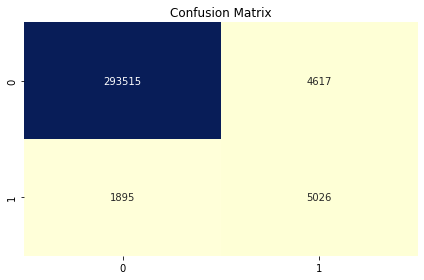

In [27]:
# Ionic (esm2)
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix

df_esm1b = pd.read_csv('data/RecentProteins/fig1/pred_esm2_t33_650M_UR50D_batch128_CV_fold5.csv')
df_esm1b.head(4)

df1=df_esm1b[['target', 'predictions']]
columns=list(df1)
print (columns)

for i in columns:
    df_esm1b[i] = df_esm1b[i].apply(lambda x: [ (_.replace('[','').replace(']','')) for _ in x.split(', ')]).apply(lambda x: [float(x1) for x1 in x])#.apply(lambda x: _ for _ in x)
print (len(df_esm1b))
df_esm1b.head(4)

d_id=['CA','CO','CU','FE','FE2','MG','MN','PO4','SO4','ZN']

def flatten(l):
    return [(item) for sublist in l for item in sublist]


df_esm1 = df_esm1b.groupby(['ions']).agg(list).reset_index()
df_esm1['true'] = df_esm1['target'].apply(flatten)
df_esm1['pred'] = df_esm1['predictions'].apply(flatten)

df_esm1=df_esm1.drop(['pdbid', 'target', 'predictions'], axis=1)
df_esm1

pid=[]
lid=[]
rocauc=[]
avgpr=[]
f1=[]
mcc=[]
pre = []
rec =[]

p_all = []
t_all= []

for i in df_esm1['ions']:
    
    prediction = df_esm1[df_esm1['ions']==i]['pred'].values[0]
    target = df_esm1[df_esm1['ions']==i]['true'].values[0]
    
    cm =confusion_matrix(target, prediction)
    dataframe = pd.DataFrame(cm, index=[0,1], columns=[0,1])
    
    sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")
    plt.title("Confusion Matrix"), plt.tight_layout()
    break

In [717]:
# Ionic (esm_msa batch128)
df_esm1b = pd.read_csv('data/RecentProteins/fig1/pred_esm_msa1b_t12_100M_UR50S_batch128_CV_fold5.csv')
df_esm1b.head(4)

df1=df_esm1b[['target', 'predictions']]
columns=list(df1)
print (columns)

for i in columns:
    df_esm1b[i] = df_esm1b[i].apply(lambda x: [ (_.replace('[','').replace(']','')) for _ in x.split(', ')]).apply(lambda x: [float(x1) for x1 in x])#.apply(lambda x: _ for _ in x)
print (len(df_esm1b))
df_esm1b.head(4)

d_id=['CA','CO','CU','FE','FE2','MG','MN','PO4','SO4','ZN']

def flatten(l):
    return [(item) for sublist in l for item in sublist]


df_esm1 = df_esm1b.groupby(['ions']).agg(list).reset_index()
df_esm1['true'] = df_esm1['target'].apply(flatten)
df_esm1['pred'] = df_esm1['predictions'].apply(flatten)

df_esm1=df_esm1.drop(['pdbid', 'target', 'predictions'], axis=1)
df_esm1

pid=[]
lid=[]
rocauc=[]
avgpr=[]
f1=[]
mcc=[]
pre = []
rec =[]

for i in df_esm1['ions']:
    
    prediction = df_esm1[df_esm1['ions']==i]['pred'].values[0]
    target = df_esm1[df_esm1['ions']==i]['true'].values[0]
    #print (i,prediction, target)
    #fpr, tpr, threshold = roc_curve(target, prediction)
    #precision, recall, thresholds = precision_recall_curve(target, prediction)
            
    precision = precision_score(target, prediction, zero_division=0)
    recall = recall_score(target, prediction, zero_division=0)
    roc_auc = roc_auc_score(target, prediction)
    avg_pr = average_precision_score(target, prediction)
    f1score = f1_score(target, prediction, average='binary')
    mcc_score = matthews_corrcoef(target, prediction)
    #print (i, roc_auc, avg_pr, f1score, mcc_score)
        
    lid.append(i)
    rocauc.append(roc_auc)
    avgpr.append(avg_pr)
    f1.append(f1score)
    mcc.append(mcc_score)
    pre.append(precision)
    rec.append(recall)

b = pd.Series(lid)
c = pd.Series(rocauc)
d = pd.Series(avgpr)
e = pd.Series(f1)
f = pd.Series(mcc)
g = pd.Series(pre)
h = pd.Series(rec)

out_df_esm_msa_b128 = pd.DataFrame({'Ligand Type':b, 'ROC-AUC':c, 'Avg_P':d, 'F1':e, 'MCC':f, 'Precision':g, 'Recall':h})
out_df_esm_msa_b128=out_df_esm_msa_b128.rename(columns={"ROC-AUC": "ROC-AUC Score", "Avg_P": "Average Precision", "F1":"F1-score", "LIG":"Ligand Type"})
out_df_esm_msa_b128['Method']='M-Ionic (ESM-MSA-1b)'
out_df_esm_msa_b128

['target', 'predictions']
5673


,Ligand Type,ROC-AUC Score,Average Precision,F1-score,MCC,Precision,Recall,Method
0,CA,0.828257,0.276353,0.500186,0.504583,0.395351,0.680682,M-Ionic (ESM-MSA-1b)
1,CO,0.638408,0.285515,0.433604,0.523833,1.000000,0.276817,M-Ionic (ESM-MSA-1b)
2,CU,0.926673,0.553877,0.734923,0.738613,0.641371,0.860427,M-Ionic (ESM-MSA-1b)
3,FE,0.714713,0.354619,0.561531,0.585733,0.806283,0.430769,M-Ionic (ESM-MSA-1b)
4,FE2,0.855730,0.535296,0.729560,0.727144,0.745981,0.713846,M-Ionic (ESM-MSA-1b)
5,MG,0.699736,0.158207,0.390654,0.385138,0.376761,0.405610,M-Ionic (ESM-MSA-1b)
6,MN,0.819510,0.461750,0.675663,0.673177,0.713163,0.641910,M-Ionic (ESM-MSA-1b)
7,PO4,0.557674,0.055516,0.176732,0.193836,0.340686,0.119313,M-Ionic (ESM-MSA-1b)
8,SO4,0.547117,0.073380,0.163413,0.221799,0.543269,0.096170,M-Ionic (ESM-MSA-1b)
9,ZN,0.953589,0.722218,0.846404,0.844891,0.788931,0.912909,M-Ionic (ESM-MSA-1b)


In [718]:
# Ionic (esm_msa batch128 + ESM2)
df_esm1b = pd.read_csv('data/RecentProteins/fig1/pred_esm2_t33_650M_UR50D_esm_msa1b_t12_100M_UR50S_batch128_CV_fold5.csv')
df_esm1b.head(4)

df1=df_esm1b[['target', 'predictions']]
columns=list(df1)
print (columns)

for i in columns:
    df_esm1b[i] = df_esm1b[i].apply(lambda x: [ (_.replace('[','').replace(']','')) for _ in x.split(', ')]).apply(lambda x: [float(x1) for x1 in x])#.apply(lambda x: _ for _ in x)
print (len(df_esm1b))
df_esm1b.head(4)

d_id=['CA','CO','CU','FE','FE2','MG','MN','PO4','SO4','ZN']

def flatten(l):
    return [(item) for sublist in l for item in sublist]


df_esm1 = df_esm1b.groupby(['ions']).agg(list).reset_index()
df_esm1['true'] = df_esm1['target'].apply(flatten)
df_esm1['pred'] = df_esm1['predictions'].apply(flatten)

df_esm1=df_esm1.drop(['pdbid', 'target', 'predictions'], axis=1)
df_esm1

pid=[]
lid=[]
rocauc=[]
avgpr=[]
f1=[]
mcc=[]
pre = []
rec =[]

for i in df_esm1['ions']:
    
    prediction = df_esm1[df_esm1['ions']==i]['pred'].values[0]
    target = df_esm1[df_esm1['ions']==i]['true'].values[0]
    #print (i,prediction, target)
    #fpr, tpr, threshold = roc_curve(target, prediction)
    #precision, recall, thresholds = precision_recall_curve(target, prediction)
            
    precision = precision_score(target, prediction, zero_division=0)
    recall = recall_score(target, prediction, zero_division=0)
    roc_auc = roc_auc_score(target, prediction)
    avg_pr = average_precision_score(target, prediction)
    f1score = f1_score(target, prediction, average='binary')
    mcc_score = matthews_corrcoef(target, prediction)
    #print (i, roc_auc, avg_pr, f1score, mcc_score)
        
    lid.append(i)
    rocauc.append(roc_auc)
    avgpr.append(avg_pr)
    f1.append(f1score)
    mcc.append(mcc_score)
    pre.append(precision)
    rec.append(recall)

b = pd.Series(lid)
c = pd.Series(rocauc)
d = pd.Series(avgpr)
e = pd.Series(f1)
f = pd.Series(mcc)
g = pd.Series(pre)
h = pd.Series(rec)

out_df_esm_msa_b128_esm = pd.DataFrame({'Ligand Type':b, 'ROC-AUC':c, 'Avg_P':d, 'F1':e, 'MCC':f, 'Precision':g, 'Recall':h})
out_df_esm_msa_b128_esm=out_df_esm_msa_b128_esm.rename(columns={"ROC-AUC": "ROC-AUC Score", "Avg_P": "Average Precision", "F1":"F1-score", "LIG":"Ligand Type"})
out_df_esm_msa_b128_esm['Method']='M-Ionic (ESM2 + ESM-MSA-1b)'
out_df_esm_msa_b128_esm

['target', 'predictions']
5673


,Ligand Type,ROC-AUC Score,Average Precision,F1-score,MCC,Precision,Recall,Method
0,CA,0.852968,0.376427,0.599580,0.597787,0.512726,0.721861,M-Ionic (ESM2 + ESM-MSA-1b)
1,CO,0.672863,0.331250,0.505051,0.566018,0.934579,0.346021,M-Ionic (ESM2 + ESM-MSA-1b)
2,CU,0.937938,0.608005,0.772662,0.775051,0.687580,0.881773,M-Ionic (ESM2 + ESM-MSA-1b)
3,FE,0.768522,0.453666,0.653650,0.665858,0.831533,0.538462,M-Ionic (ESM2 + ESM-MSA-1b)
4,FE2,0.921688,0.635534,0.794798,0.794155,0.749319,0.846154,M-Ionic (ESM2 + ESM-MSA-1b)
5,MG,0.738285,0.146013,0.363654,0.368715,0.289988,0.487491,M-Ionic (ESM2 + ESM-MSA-1b)
6,MN,0.823457,0.509032,0.707811,0.707814,0.778367,0.648983,M-Ionic (ESM2 + ESM-MSA-1b)
7,PO4,0.582823,0.082619,0.239203,0.254024,0.403670,0.169957,M-Ionic (ESM2 + ESM-MSA-1b)
8,SO4,0.571926,0.095077,0.228534,0.265562,0.510324,0.147234,M-Ionic (ESM2 + ESM-MSA-1b)
9,ZN,0.959324,0.732700,0.852367,0.851347,0.790757,0.924387,M-Ionic (ESM2 + ESM-MSA-1b)


In [719]:
# PSSM
df_esm1b = pd.read_csv('data/RecentProteins/fig1/pred_PSSM_batch128_CV_fold5.csv')
df_esm1b.head(4)

df1=df_esm1b[['target', 'predictions']]
columns=list(df1)
print (columns)

for i in columns:
    df_esm1b[i] = df_esm1b[i].apply(lambda x: [ (_.replace('[','').replace(']','')) for _ in x.split(', ')]).apply(lambda x: [float(x1) for x1 in x])#.apply(lambda x: _ for _ in x)
print (len(df_esm1b))
df_esm1b.head(4)

d_id=['CA','CO','CU','FE','FE2','MG','MN','PO4','SO4','ZN']

def flatten(l):
    return [(item) for sublist in l for item in sublist]


df_esm1 = df_esm1b.groupby(['ions']).agg(list).reset_index()
df_esm1['true'] = df_esm1['target'].apply(flatten)
df_esm1['pred'] = df_esm1['predictions'].apply(flatten)

df_esm1=df_esm1.drop(['pdbid', 'target', 'predictions'], axis=1)
df_esm1

pid=[]
lid=[]
rocauc=[]
avgpr=[]
f1=[]
mcc=[]
pre = []
rec =[]

for i in df_esm1['ions']:
    
    prediction = df_esm1[df_esm1['ions']==i]['pred'].values[0]
    target = df_esm1[df_esm1['ions']==i]['true'].values[0]
    #print (i,prediction, target)
    #fpr, tpr, threshold = roc_curve(target, prediction)
    #precision, recall, thresholds = precision_recall_curve(target, prediction)
            
    precision = precision_score(target, prediction, zero_division=0)
    recall = recall_score(target, prediction, zero_division=0)
    roc_auc = roc_auc_score(target, prediction)
    avg_pr = average_precision_score(target, prediction)
    f1score = f1_score(target, prediction, average='binary')
    mcc_score = matthews_corrcoef(target, prediction)
    #print (i, roc_auc, avg_pr, f1score, mcc_score)
        
    lid.append(i)
    rocauc.append(roc_auc)
    avgpr.append(avg_pr)
    f1.append(f1score)
    mcc.append(mcc_score)
    pre.append(precision)
    rec.append(recall)

b = pd.Series(lid)
c = pd.Series(rocauc)
d = pd.Series(avgpr)
e = pd.Series(f1)
f = pd.Series(mcc)
g = pd.Series(pre)
h = pd.Series(rec)

out_df_pssm = pd.DataFrame({'Ligand Type':b, 'ROC-AUC':c, 'Avg_P':d, 'F1':e, 'MCC':f, 'Precision':g, 'Recall':h})
out_df_pssm=out_df_pssm.rename(columns={"ROC-AUC": "ROC-AUC Score", "Avg_P": "Average Precision", "F1":"F1-score", "LIG":"Ligand Type"})
out_df_pssm['Method']='M-Ionic (PSSM)'
out_df_pssm

['target', 'predictions']
5673


,Ligand Type,ROC-AUC Score,Average Precision,F1-score,MCC,Precision,Recall,Method
0,CA,0.562870,0.061678,0.186786,0.193381,0.317284,0.132351,M-Ionic (PSSM)
1,CO,0.500000,0.012028,0.000000,0.000000,0.000000,0.000000,M-Ionic (PSSM)
2,CU,0.651972,0.191761,0.404324,0.420461,0.591772,0.307061,M-Ionic (PSSM)
3,FE,0.587794,0.148475,0.287671,0.368181,0.782609,0.176224,M-Ionic (PSSM)
4,FE2,0.671991,0.296571,0.489083,0.536161,0.842105,0.344615,M-Ionic (PSSM)
5,MG,0.641893,0.071679,0.253082,0.247677,0.222649,0.293151,M-Ionic (PSSM)
6,MN,0.629581,0.148005,0.351335,0.369242,0.534296,0.261715,M-Ionic (PSSM)
7,PO4,0.500000,0.016882,0.000000,0.000000,0.000000,0.000000,M-Ionic (PSSM)
8,SO4,0.500000,0.023382,0.000000,0.000000,0.000000,0.000000,M-Ionic (PSSM)
9,ZN,0.902466,0.484646,0.683714,0.684905,0.587074,0.818439,M-Ionic (PSSM)


In [720]:
# PSSM + ESM2
df_esm1b = pd.read_csv('data/RecentProteins/fig1/pred_PSSM_esm2_t33_650M_UR50D_batch128_CV_fold5.csv')
df_esm1b.head(4)

df1=df_esm1b[['target', 'predictions']]
columns=list(df1)
print (columns)

for i in columns:
    df_esm1b[i] = df_esm1b[i].apply(lambda x: [ (_.replace('[','').replace(']','')) for _ in x.split(', ')]).apply(lambda x: [float(x1) for x1 in x])#.apply(lambda x: _ for _ in x)
print (len(df_esm1b))
df_esm1b.head(4)

d_id=['CA','CO','CU','FE','FE2','MG','MN','PO4','SO4','ZN']

def flatten(l):
    return [(item) for sublist in l for item in sublist]


df_esm1 = df_esm1b.groupby(['ions']).agg(list).reset_index()
df_esm1['true'] = df_esm1['target'].apply(flatten)
df_esm1['pred'] = df_esm1['predictions'].apply(flatten)

df_esm1=df_esm1.drop(['pdbid', 'target', 'predictions'], axis=1)
df_esm1

pid=[]
lid=[]
rocauc=[]
avgpr=[]
f1=[]
mcc=[]
pre = []
rec =[]

for i in df_esm1['ions']:
    
    prediction = df_esm1[df_esm1['ions']==i]['pred'].values[0]
    target = df_esm1[df_esm1['ions']==i]['true'].values[0]
    #print (i,prediction, target)
    #fpr, tpr, threshold = roc_curve(target, prediction)
    #precision, recall, thresholds = precision_recall_curve(target, prediction)
            
    precision = precision_score(target, prediction, zero_division=0)
    recall = recall_score(target, prediction, zero_division=0)
    roc_auc = roc_auc_score(target, prediction)
    avg_pr = average_precision_score(target, prediction)
    f1score = f1_score(target, prediction, average='binary')
    mcc_score = matthews_corrcoef(target, prediction)
    #print (i, roc_auc, avg_pr, f1score, mcc_score)
        
    lid.append(i)
    rocauc.append(roc_auc)
    avgpr.append(avg_pr)
    f1.append(f1score)
    mcc.append(mcc_score)
    pre.append(precision)
    rec.append(recall)

b = pd.Series(lid)
c = pd.Series(rocauc)
d = pd.Series(avgpr)
e = pd.Series(f1)
f = pd.Series(mcc)
g = pd.Series(pre)
h = pd.Series(rec)

out_df_pssm_esm = pd.DataFrame({'Ligand Type':b, 'ROC-AUC':c, 'Avg_P':d, 'F1':e, 'MCC':f, 'Precision':g, 'Recall':h})
out_df_pssm_esm=out_df_pssm_esm.rename(columns={"ROC-AUC": "ROC-AUC Score", "Avg_P": "Average Precision", "F1":"F1-score", "LIG":"Ligand Type"})
out_df_pssm_esm['Method']='M-Ionic (PSSM + ESM2)'
out_df_pssm_esm

['target', 'predictions']
5673


,Ligand Type,ROC-AUC Score,Average Precision,F1-score,MCC,Precision,Recall,Method
0,CA,0.856579,0.374204,0.596481,0.595950,0.504343,0.729808,M-Ionic (PSSM + ESM2)
1,CO,0.688160,0.326179,0.521531,0.561375,0.844961,0.377163,M-Ionic (PSSM + ESM2)
2,CU,0.947886,0.583040,0.751880,0.758695,0.644028,0.903120,M-Ionic (PSSM + ESM2)
3,FE,0.793361,0.467752,0.673062,0.676548,0.785448,0.588811,M-Ionic (PSSM + ESM2)
4,FE2,0.935821,0.696386,0.832845,0.832062,0.795518,0.873846,M-Ionic (PSSM + ESM2)
5,MG,0.742045,0.158710,0.382433,0.385694,0.311951,0.494061,M-Ionic (PSSM + ESM2)
6,MN,0.844808,0.517223,0.716377,0.713755,0.742180,0.692308,M-Ionic (PSSM + ESM2)
7,PO4,0.601823,0.101052,0.278830,0.287875,0.420415,0.208584,M-Ionic (PSSM + ESM2)
8,SO4,0.575269,0.098765,0.236911,0.272377,0.512748,0.154043,M-Ionic (PSSM + ESM2)
9,ZN,0.955225,0.698173,0.830707,0.830250,0.759065,0.917282,M-Ionic (PSSM + ESM2)


In [721]:
## LmetalSite

df1 = pd.read_csv('data/RecentProteins/lmetal/split_100_recent_predictions.csv')
df2 = pd.read_csv('data/RecentProteins/lmetal/split_101_recent_predictions.csv')
df3 = pd.read_csv('data/RecentProteins/lmetal/split_102_recent_predictions.csv')
df4 = pd.read_csv('data/RecentProteins/lmetal/split_103_recent_predictions.csv')
df5 = pd.read_csv('data/RecentProteins/lmetal/split_104_recent_predictions.csv')
df6 = pd.read_csv('data/RecentProteins/lmetal/split_105_recent_predictions.csv')
df7 = pd.read_csv('data/RecentProteins/lmetal/split_106_recent_predictions.csv')
df8 = pd.read_csv('data/RecentProteins/lmetal/split_107_recent_predictions.csv')
df9 = pd.read_csv('data/RecentProteins/lmetal/split_108_recent_predictions.csv')
df10 = pd.read_csv('data/RecentProteins/lmetal/split_109_recent_predictions.csv')
df11 = pd.read_csv('data/RecentProteins/lmetal/split_110_recent_predictions.csv')

result = [df1,df2,df3,df4,df5,df6,df7,df8, df9, df10, df11]
df = pd.concat(result, ignore_index=True)
print (len(df))

df1=df[['ZN_pred','CA_pred', 'MG_pred', 'MN_pred']]
columns=list(df1)
print (columns)

for i in columns:
    df[i] = df[i].apply(lambda x: x.split(',')).apply(lambda x: [float(x1) for x1 in x])
    
df = df.drop(['ZN_prob','CA_prob', 'MG_prob', 'MN_prob', 'Sequence'], axis=1)
pred_list = ['ZN', 'CA', 'MG', 'MN']
df.head(5)

df=df.rename(columns={"ID": "pdbid"})

df_esm = pd.read_csv('data/RecentProteins/esm/ionic_predictions.csv')
df1=df_esm[['labels', 'sigmoid', 'binarized']]
columns=list(df1)
for i in columns:
    df_esm[i] = df_esm[i].apply(lambda x: [(_.replace('[','').replace(']','')) for _ in x.split(',')])#.apply(lambda x: list(filter(None, x)))#.apply(lambda x: _ for _ in x)
#print (len(df_esm))

dfm = df_esm.merge(df, on='pdbid')
#dfm = dfm.drop(['binarized', 'sigmoid'], axis=1)
#print (dfm.head(4))

pdb_lst = []
ion_lst = []
target_lst = []
prediction_lst=[]
for i in dfm['pdbid']:
    ion = dfm[dfm['pdbid']==i]['ion'].values[0]
    
    if ion in pred_list:
        col_name = '{}_pred'.format(ion)
        prediction = dfm[dfm['pdbid']==i][col_name].values[0]
        #print (i, ion, col_name, prediction)
        pdb_lst.append(i)
        ion_lst.append(ion)
        target_lst.append(dfm[dfm['pdbid']==i]['labels'].values[0])
        prediction_lst.append(prediction)
        
dfm1=pd.DataFrame()
dfm1['pdbid']=pdb_lst
dfm1['ions']=ion_lst
dfm1['target']=target_lst
dfm1['predictions']=prediction_lst
dfm1['tlen'] = dfm1.target.str.len()
dfm1['plen'] = dfm1.predictions.str.len()

dfm1.head(4)

d_id=['CA','CO','CU','FE','FE2','MG','MN','PO4','SO4','ZN']

def flatten(l):
    return [float(item) for sublist in l for item in sublist]

df_esm1 = dfm1.groupby(['ions']).agg(list).reset_index()
df_esm1['true'] = df_esm1['target'].apply(flatten)
df_esm1['pred'] = df_esm1['predictions'].apply(flatten)

df_esm1=df_esm1.drop(['pdbid', 'target', 'predictions'], axis=1)
df_esm1

pid=[]
lid=[]
rocauc=[]
avgpr=[]
f1=[]
mcc=[]
pre = []
rec =[]

for i in df_esm1['ions']:
    
    prediction = df_esm1[df_esm1['ions']==i]['pred'].values[0]
    target = df_esm1[df_esm1['ions']==i]['true'].values[0]
    #print (i,prediction[:15], target[:15])
    #break
    #fpr, tpr, threshold = roc_curve(target, prediction)
    #precision, recall, thresholds = precision_recall_curve(target, prediction)
            
    
    precision = precision_score(target, prediction, zero_division=0)
    recall = recall_score(target, prediction, zero_division=0)
    roc_auc = roc_auc_score(target, prediction)
    avg_pr = average_precision_score(target, prediction)
    f1score = f1_score(target, prediction, average='binary')
    mcc_score = matthews_corrcoef(target, prediction)
    #print (i, roc_auc, avg_pr, f1score, mcc_score)
        
    lid.append(i)
    rocauc.append(roc_auc)
    avgpr.append(avg_pr)
    f1.append(f1score)
    mcc.append(mcc_score)
    pre.append(precision)
    rec.append(recall)

b = pd.Series(lid)
c = pd.Series(rocauc)
d = pd.Series(avgpr)
e = pd.Series(f1)
f = pd.Series(mcc)
g = pd.Series(pre)

out_df_lmetal = pd.DataFrame({'Ligand Type':b, 'ROC-AUC':c, 'Avg_P':d, 'F1':e,  'MCC':f, 'Precision':g, 'Recall':h})
out_df_lmetal=out_df_lmetal.rename(columns={"ROC-AUC": "ROC-AUC Score", "Avg_P": "Average Precision", "F1":"F1-score", "LIG":"Ligand Type"})
out_df_lmetal['Method']='LMetalSite'
out_df_lmetal

5367
['ZN_pred', 'CA_pred', 'MG_pred', 'MN_pred']


,Ligand Type,ROC-AUC Score,Average Precision,F1-score,MCC,Precision,Recall,Method
0,CA,0.767784,0.429484,0.637030,0.641766,0.778917,0.729808,LMetalSite
1,MG,0.660131,0.244043,0.448112,0.484873,0.740304,0.377163,LMetalSite
2,MN,0.858588,0.565620,0.749263,0.747083,0.781538,0.903120,LMetalSite
3,ZN,0.942447,0.777425,0.880086,0.877005,0.872068,0.588811,LMetalSite
4,NaN,NaN,NaN,NaN,NaN,NaN,0.873846,LMetalSite
5,NaN,NaN,NaN,NaN,NaN,NaN,0.494061,LMetalSite
6,NaN,NaN,NaN,NaN,NaN,NaN,0.692308,LMetalSite
7,NaN,NaN,NaN,NaN,NaN,NaN,0.208584,LMetalSite
8,NaN,NaN,NaN,NaN,NaN,NaN,0.154043,LMetalSite
9,NaN,NaN,NaN,NaN,NaN,NaN,0.917282,LMetalSite


In [722]:
#result1 = [out_df, out_df_pssm, out_df_pssm_esm, out_df_esm_msa_b128, out_df_esm_msa_b128_esm, out_df_lmetal]
#result1 = [out_df, out_df_lmetal]
#result1 = [out_df, out_df_esm_msa_b128, out_df_pssm]
result1 = [out_df_lmetal, out_df,out_df_esm_msa_b128 ]
df_out = pd.concat(result1, ignore_index=True)
#df_out=df_out.sort_values(['Method','Ligand Type'], ascending=False)
df_out
df_out = df_out.reset_index(drop=True)
#df_out.to_csv('evo.csv', index=False)
df_out

,Ligand Type,ROC-AUC Score,Average Precision,F1-score,MCC,Precision,Recall,Method
0,CA,0.767784,0.429484,0.637030,0.641766,0.778917,0.729808,LMetalSite
1,MG,0.660131,0.244043,0.448112,0.484873,0.740304,0.377163,LMetalSite
2,MN,0.858588,0.565620,0.749263,0.747083,0.781538,0.903120,LMetalSite
3,ZN,0.942447,0.777425,0.880086,0.877005,0.872068,0.588811,LMetalSite
4,NaN,NaN,NaN,NaN,NaN,NaN,0.873846,LMetalSite
5,NaN,NaN,NaN,NaN,NaN,NaN,0.494061,LMetalSite
6,NaN,NaN,NaN,NaN,NaN,NaN,0.692308,LMetalSite
7,NaN,NaN,NaN,NaN,NaN,NaN,0.208584,LMetalSite
8,NaN,NaN,NaN,NaN,NaN,NaN,0.154043,LMetalSite
9,NaN,NaN,NaN,NaN,NaN,NaN,0.917282,LMetalSite


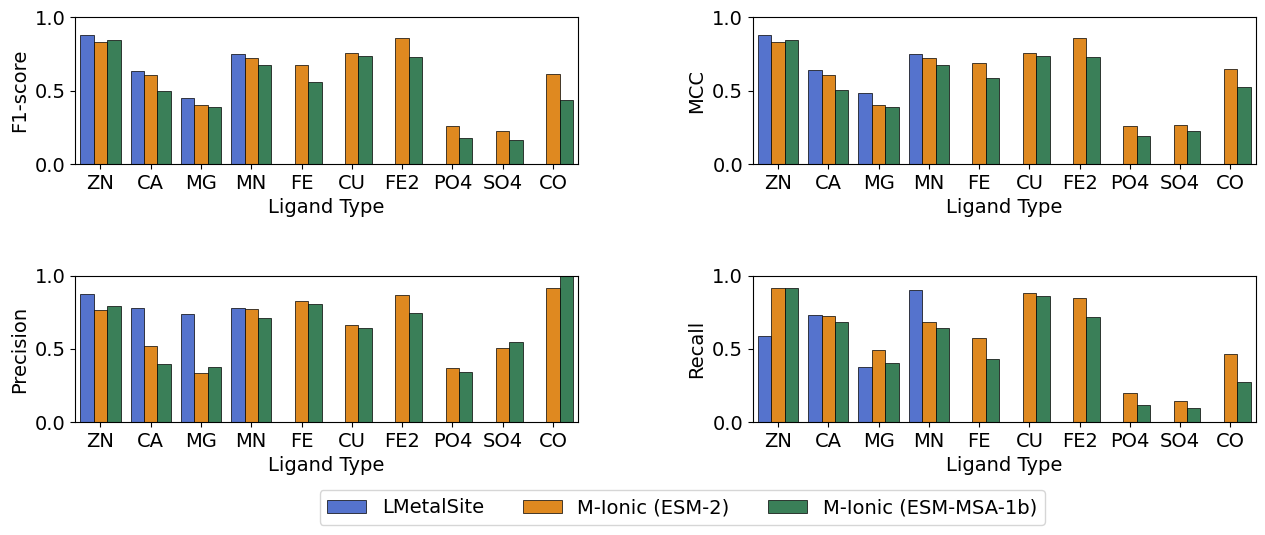

In [725]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
figure, axes = plt.subplots(2,2, figsize=(13,5))
#plt.figure(figsize=(6, 4))
order=['ZN','CA','MG','MN','FE','CU','FE2','PO4','SO4','CO']
matplotlib.rc('font', size=14)
matplotlib.rc('axes', titlesize=14)

#palette=['royalblue','darkorange','seagreen']
sns.barplot(data=df_out, y='F1-score', x='Ligand Type',  palette=['royalblue','darkorange','seagreen'], hue='Method',linewidth=0.5, edgecolor="0",order=order, ax=axes[0,0])
sns.barplot(data=df_out, y='MCC', x='Ligand Type',  palette=['royalblue','darkorange','seagreen'], hue='Method', linewidth=0.5, edgecolor="0",order=order, ax=axes[0,1])
sns.barplot(data=df_out, y='Precision', x='Ligand Type', palette=['royalblue','darkorange','seagreen'], hue='Method', linewidth=0.5, edgecolor="0",ax=axes[1,0],order=order)
sns.barplot(data=df_out, y='Recall', x='Ligand Type',  palette=['royalblue','darkorange','seagreen'], hue='Method', linewidth=0.5, edgecolor="0",ax=axes[1,1],order=order)
figure.tight_layout(h_pad=3, w_pad=5)

#figure.tight_layout(h_pad=0, w_pad=2)

axes[0,0].legend([],[], frameon=False)
axes[0,1].legend([],[], frameon=False)
axes[1,0].legend([],[], frameon=False)
axes[1,1].legend([],[], frameon=False)
#plt.legend()

axes[0,0].set_ylim([0, 1])
axes[0,1].set_ylim([0, 1])
axes[1,0].set_ylim([0, 1])
axes[1,1].set_ylim([0, 1])
#plt.legend(bbox_to_anchor=(1,1.5))
#axes.tick_params(axis='x', labelsize=12)
plt.legend(bbox_to_anchor=(0.6,-0.4), ncol=3)
#plt.legend(loc='lower right',bbox_to_anchor=(0.3,-0.1))


#plt.savefig('talk/residue_evo_2x2.png', bbox_inches='tight',  pad_inches=0.3,dpi=350)
plt.savefig('figures/OnlyRecent_precision_recall_f1_mcc_esm2_lmetal_msa_2x2.png', bbox_inches='tight', pad_inches=0.6,dpi=350)
plt.show()

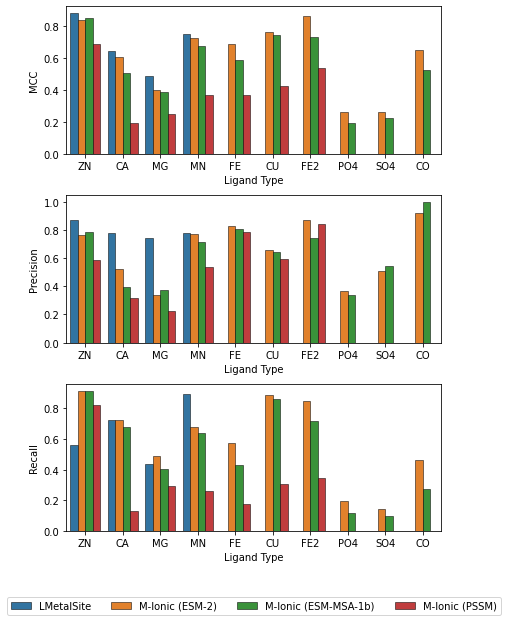

In [156]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
figure, axes = plt.subplots(3,1, figsize=(6,8))
#plt.figure(figsize=(6, 4))
order=['ZN','CA','MG','MN','FE','CU','FE2','PO4','SO4','CO']


sns.barplot(data=df_out, y='MCC', x='Ligand Type',  hue='Method',linewidth=0.5, edgecolor="0",order=order, ax=axes[0])
sns.barplot(data=df_out, y='Precision', x='Ligand Type',  hue='Method',linewidth=0.5, edgecolor="0",order=order, ax=axes[1])
sns.barplot(data=df_out, y='Recall', x='Ligand Type', hue='Method', linewidth=0.5, edgecolor="0",ax=axes[2],order=order)
#sns.barplot(data=df_out, y='Recall', x='Ligand Type',  hue='Method', palette=['royalblue','darkorange','seagreen'], linewidth=0.5, edgecolor="0",ax=axes[3],order=order)
figure.tight_layout(pad=1.0)

axes[0].legend([],[], frameon=False)
axes[1].legend([],[], frameon=False)
axes[2].legend([],[], frameon=False)
#axes[3].legend([],[], frameon=False)
#plt.legend()
#plt.legend(bbox_to_anchor=(1,1.5))
plt.legend(loc='lower center',bbox_to_anchor=(0.5,-0.6),ncol=4)
#plt.legend(loc='lower right',bbox_to_anchor=(0.3,-0.1))
plt.savefig('figures/poster_OnlyRecent_f1_mcc_roc_pre_esm2_lmetal_2x1.png', bbox_inches='tight',  pad_inches=0.3,dpi=350)
plt.show()

## Comparison other runs

In [298]:
df = pd.read_csv('data/supp/processed_metal_ion_min1000.csv')
df = df.dropna()

df['pdbchain']=df['pdbid']+'_'+df['chain']

df_g = df.groupby(['pdbchain'])['LigID'].agg(list).reset_index()
uniq_lst = []
len_g = []
for i in df_g['pdbchain']:
    g = list(set(df_g[df_g['pdbchain']==i]['LigID'].values[0]))
    len_g.append(len(g))
    uniq_lst.append(g)
df_g['multiple_ions'] = uniq_lst
df_g['Num_ions'] = len_g

LigID_map=df_g
LigID_map.head(4)

KeyboardInterrupt: 

In [666]:
# Ionic (esm2 batch128)
df_esm1b = pd.read_csv('data/supp/pred_esm2_t33_650M_UR50D_batch128_CV_fold1.csv')
df_esm1b.head(4)

df1=df_esm1b[['target', 'predictions']]
columns=list(df1)
print (columns)

for i in columns:
    df_esm1b[i] = df_esm1b[i].apply(lambda x: [ (_.replace('[','').replace(']','')) for _ in x.split(', ')]).apply(lambda x: [float(x1) for x1 in x])#.apply(lambda x: _ for _ in x)
print (len(df_esm1b))
df_esm1b.head(4)

d_id=['CA','CO','CU','FE','FE2','MG','MN','PO4','SO4','ZN']

def flatten(l):
    return [(item) for sublist in l for item in sublist]


df_esm1 = df_esm1b.groupby(['ions']).agg(list).reset_index()
df_esm1['true'] = df_esm1['target'].apply(flatten)
df_esm1['pred'] = df_esm1['predictions'].apply(flatten)

df_esm1=df_esm1.drop(['pdbid', 'target', 'predictions'], axis=1)
df_esm1

pid=[]
lid=[]
rocauc=[]
avgpr=[]
f1=[]
mcc=[]
pre = []
rec =[]

for i in df_esm1['ions']:
    
    prediction = df_esm1[df_esm1['ions']==i]['pred'].values[0]
    target = df_esm1[df_esm1['ions']==i]['true'].values[0]
    #print (i,prediction, target)
    #fpr, tpr, threshold = roc_curve(target, prediction)
    #precision, recall, thresholds = precision_recall_curve(target, prediction)
            
    precision = precision_score(target, prediction, zero_division=0)
    recall = recall_score(target, prediction, zero_division=0)
    roc_auc = roc_auc_score(target, prediction)
    avg_pr = average_precision_score(target, prediction)
    f1score = f1_score(target, prediction, average='binary')
    mcc_score = matthews_corrcoef(target, prediction)
    #print (i, roc_auc, avg_pr, f1score, mcc_score)
        
    lid.append(i)
    rocauc.append(roc_auc)
    avgpr.append(avg_pr)
    f1.append(f1score)
    mcc.append(mcc_score)
    pre.append(precision)
    rec.append(recall)

b = pd.Series(lid)
c = pd.Series(rocauc)
d = pd.Series(avgpr)
e = pd.Series(f1)
f = pd.Series(mcc)
g = pd.Series(pre)
h = pd.Series(rec)

out_df_esm2_b128 = pd.DataFrame({'Ligand Type':b, 'ROC-AUC':c, 'Avg_P':d, 'F1':e, 'MCC':f, 'Precision':g, 'Recall':h})
out_df_esm2_b128=out_df_esm2_b128.rename(columns={"ROC-AUC": "ROC-AUC Score", "Avg_P": "Average Precision", "F1":"F1-score", "LIG":"Ligand Type"})
out_df_esm2_b128['Method']='ESM-2 (Batch-128)'
out_df_esm2_b128

['target', 'predictions']
3294


,Ligand Type,ROC-AUC Score,Average Precision,F1-score,MCC,Precision,Recall,Method
0,CA,0.704095,0.220026,0.455912,0.449441,0.505184,0.415397,ESM-2 (Batch-128)
1,CO,0.528313,0.048860,0.104418,0.180581,0.590909,0.057269,ESM-2 (Batch-128)
2,CU,0.874302,0.557727,0.744131,0.740010,0.735499,0.752969,ESM-2 (Batch-128)
3,FE,0.722186,0.372752,0.575227,0.594480,0.807466,0.446739,ESM-2 (Batch-128)
4,FE2,0.855090,0.576091,0.754930,0.752890,0.802395,0.712766,ESM-2 (Batch-128)
5,MG,0.662230,0.167340,0.391597,0.392920,0.484076,0.328785,ESM-2 (Batch-128)
6,MN,0.748063,0.417406,0.620794,0.637125,0.825100,0.497585,ESM-2 (Batch-128)
7,PO4,0.576539,0.085142,0.231548,0.255387,0.441989,0.156863,ESM-2 (Batch-128)
8,SO4,0.536737,0.046221,0.126582,0.164316,0.384615,0.075758,ESM-2 (Batch-128)
9,ZN,0.886385,0.597580,0.770846,0.767360,0.765385,0.776386,ESM-2 (Batch-128)


In [667]:
## Ionic ProtT5
df_prott5 = pd.read_csv(r'data/supp/ProtT5_XL_UniRef50_pred_df.csv',  index_col=0,)# converters={'COLUMN_NAME': pd.eval})
df1=df_prott5[['sigmoid', 'binarized', 'labels']]
columns=list(df1)
print (columns)

for i in columns:
    df_prott5[i] = df_prott5[i].apply(lambda x: [(_.replace('[','').replace(']','')) for _ in x.split( )])#.apply(lambda x: list(filter(None, x)))#.apply(lambda x: _ for _ in x)
df_prott5.head(4)

d_id=['CA','CO','CU','FE','FE2','MG','MN','PO4','SO4','ZN']

def flatten(l):
    return [int(item) for sublist in l for item in sublist]


df_prott51 = df_prott5.groupby(['ion']).agg(list).reset_index()
df_prott51['true'] = df_prott5['labels'].apply(flatten)
df_prott51['pred'] = df_prott5['binarized'].apply(flatten)

df_prott51=df_prott51.drop(['pdbid', 'sigmoid', 'binarized','labels'], axis=1)

df_prott51

pid=[]
lid=[]
rocauc=[]
avgpr=[]
f1=[]
mcc=[]
pre = []
rec =[]

for i in df_prott51['ion']:
    
    prediction = df_prott51[df_prott51['ion']==i]['pred'].values[0]
    target = df_prott51[df_prott51['ion']==i]['true'].values[0]
    #fpr, tpr, threshold = roc_curve(target, prediction)
    #precision, recall, thresholds = precision_recall_curve(target, prediction)
            
    precision = precision_score(target, prediction, zero_division=0)
    recall = recall_score(target, prediction, zero_division=0)
    roc_auc = roc_auc_score(target, prediction)
    avg_pr = average_precision_score(target, prediction)
    f1score = f1_score(target, prediction, average='binary')
    mcc_score = matthews_corrcoef(target, prediction)
    #print (i, roc_auc, avg_pr, f1score, mcc_score)
        
    lid.append(i)
    rocauc.append(roc_auc)
    avgpr.append(avg_pr)
    f1.append(f1score)
    mcc.append(mcc_score)
    pre.append(precision)
    rec.append(recall)

b = pd.Series(lid)
c = pd.Series(rocauc)
d = pd.Series(avgpr)
e = pd.Series(f1)
f = pd.Series(mcc)
g = pd.Series(pre)
h = pd.Series(rec)

out_df_p = pd.DataFrame({'Ligand Type':b, 'ROC-AUC':c, 'Avg_P':d, 'F1':e, 'MCC':f, 'Precision':g, 'Recall':h})
out_df_p=out_df_p.rename(columns={"ROC-AUC": "ROC-AUC Score", "Avg_P": "Average Precision", "F1":"F1-score", "LIG":"Ligand Type"})
out_df_p['Method']='ProtT5_XL (Batch-128)'
out_df_p

['sigmoid', 'binarized', 'labels']


,Ligand Type,ROC-AUC Score,Average Precision,F1-score,MCC,Precision,Recall,Method
0,CA,0.498789,0.004819,0.000000,-0.003420,0.000000,0.000000,ProtT5_XL (Batch-128)
1,CO,0.995775,0.400000,0.571429,0.629778,0.400000,1.000000,ProtT5_XL (Batch-128)
2,CU,0.872101,0.452865,0.666667,0.666602,0.600000,0.750000,ProtT5_XL (Batch-128)
3,FE,0.665266,0.233242,0.444444,0.465491,0.666667,0.333333,ProtT5_XL (Batch-128)
4,FE2,0.993421,0.888889,0.941176,0.936586,0.888889,1.000000,ProtT5_XL (Batch-128)
5,MG,0.700000,0.409524,0.571429,0.629417,1.000000,0.400000,ProtT5_XL (Batch-128)
6,MN,0.742424,0.264706,0.500000,0.484848,0.500000,0.500000,ProtT5_XL (Batch-128)
7,PO4,0.500000,0.004566,0.000000,0.000000,0.000000,0.000000,ProtT5_XL (Batch-128)
8,SO4,0.500000,0.020202,0.000000,0.000000,0.000000,0.000000,ProtT5_XL (Batch-128)
9,ZN,0.597423,0.149777,0.300000,0.333215,0.600000,0.200000,ProtT5_XL (Batch-128)


In [668]:
# Ionic (esm2 batch1)
df_esm1b = pd.read_csv('data/supp/pred_esm2_t33_650M_UR50D_batch1_CV_fold1.csv')
df_esm1b.head(4)

df1=df_esm1b[['target', 'predictions']]
columns=list(df1)
print (columns)

for i in columns:
    df_esm1b[i] = df_esm1b[i].apply(lambda x: [ (_.replace('[','').replace(']','')) for _ in x.split(', ')]).apply(lambda x: [float(x1) for x1 in x])#.apply(lambda x: _ for _ in x)
print (len(df_esm1b))
df_esm1b.head(4)

d_id=['CA','CO','CU','FE','FE2','MG','MN','PO4','SO4','ZN']

def flatten(l):
    return [(item) for sublist in l for item in sublist]


df_esm1 = df_esm1b.groupby(['ions']).agg(list).reset_index()
df_esm1['true'] = df_esm1['target'].apply(flatten)
df_esm1['pred'] = df_esm1['predictions'].apply(flatten)

df_esm1=df_esm1.drop(['pdbid', 'target', 'predictions'], axis=1)
df_esm1

pid=[]
lid=[]
rocauc=[]
avgpr=[]
f1=[]
mcc=[]
pre = []
rec =[]

for i in df_esm1['ions']:
    
    prediction = df_esm1[df_esm1['ions']==i]['pred'].values[0]
    target = df_esm1[df_esm1['ions']==i]['true'].values[0]
    #print (i,prediction, target)
    #fpr, tpr, threshold = roc_curve(target, prediction)
    #precision, recall, thresholds = precision_recall_curve(target, prediction)
            
    precision = precision_score(target, prediction, zero_division=0)
    recall = recall_score(target, prediction, zero_division=0)
    roc_auc = roc_auc_score(target, prediction)
    avg_pr = average_precision_score(target, prediction)
    f1score = f1_score(target, prediction, average='binary')
    mcc_score = matthews_corrcoef(target, prediction)
    #print (i, roc_auc, avg_pr, f1score, mcc_score)
        
    lid.append(i)
    rocauc.append(roc_auc)
    avgpr.append(avg_pr)
    f1.append(f1score)
    mcc.append(mcc_score)
    pre.append(precision)
    rec.append(recall)

b = pd.Series(lid)
c = pd.Series(rocauc)
d = pd.Series(avgpr)
e = pd.Series(f1)
f = pd.Series(mcc)
g = pd.Series(pre)
h = pd.Series(rec)
out_df_esm2_b1 = pd.DataFrame({'Ligand Type':b, 'ROC-AUC':c, 'Avg_P':d, 'F1':e, 'MCC':f, 'Precision':g, 'Recall':h})
out_df_esm2_b1=out_df_esm2_b1.rename(columns={"ROC-AUC": "ROC-AUC Score", "Avg_P": "Average Precision", "F1":"F1-score", "LIG":"Ligand Type"})
out_df_esm2_b1['Method']='ESM-2 (Batch-1)'
out_df_esm2_b1

['target', 'predictions']
3294


,Ligand Type,ROC-AUC Score,Average Precision,F1-score,MCC,Precision,Recall,Method
0,CA,0.675837,0.204754,0.430530,0.432073,0.542173,0.357014,ESM-2 (Batch-1)
1,CO,0.524086,0.050696,0.090909,0.185999,0.733333,0.048458,ESM-2 (Batch-1)
2,CU,0.843193,0.524897,0.720397,0.716807,0.753567,0.690024,ESM-2 (Batch-1)
3,FE,0.735073,0.420952,0.611268,0.634526,0.868000,0.471739,ESM-2 (Batch-1)
4,FE2,0.841988,0.568353,0.747826,0.747554,0.821656,0.686170,ESM-2 (Batch-1)
5,MG,0.653134,0.169105,0.387917,0.395290,0.518663,0.309817,ESM-2 (Batch-1)
6,MN,0.744177,0.423816,0.621677,0.642205,0.851541,0.489533,ESM-2 (Batch-1)
7,PO4,0.552104,0.055752,0.166163,0.189615,0.361842,0.107843,ESM-2 (Batch-1)
8,SO4,0.537201,0.055933,0.132013,0.192043,0.512821,0.075758,ESM-2 (Batch-1)
9,ZN,0.860788,0.587580,0.762760,0.760458,0.805619,0.724230,ESM-2 (Batch-1)


In [669]:
# Ionic (esm_msa batch128)
df_esm1b = pd.read_csv('data/supp/pred_esm_msa1b_t12_100M_UR50S_batch128_CV_fold1.csv')
df_esm1b.head(4)

df1=df_esm1b[['target', 'predictions']]
columns=list(df1)
print (columns)

for i in columns:
    df_esm1b[i] = df_esm1b[i].apply(lambda x: [ (_.replace('[','').replace(']','')) for _ in x.split(', ')]).apply(lambda x: [float(x1) for x1 in x])#.apply(lambda x: _ for _ in x)
print (len(df_esm1b))
df_esm1b.head(4)

d_id=['CA','CO','CU','FE','FE2','MG','MN','PO4','SO4','ZN']

def flatten(l):
    return [(item) for sublist in l for item in sublist]


df_esm1 = df_esm1b.groupby(['ions']).agg(list).reset_index()
df_esm1['true'] = df_esm1['target'].apply(flatten)
df_esm1['pred'] = df_esm1['predictions'].apply(flatten)

df_esm1=df_esm1.drop(['pdbid', 'target', 'predictions'], axis=1)
df_esm1

pid=[]
lid=[]
rocauc=[]
avgpr=[]
f1=[]
mcc=[]
pre = []
rec =[]

for i in df_esm1['ions']:
    
    prediction = df_esm1[df_esm1['ions']==i]['pred'].values[0]
    target = df_esm1[df_esm1['ions']==i]['true'].values[0]
    #print (i,prediction, target)
    #fpr, tpr, threshold = roc_curve(target, prediction)
    #precision, recall, thresholds = precision_recall_curve(target, prediction)
    precision = precision_score(target, prediction, zero_division=0)
    recall = recall_score(target, prediction, zero_division=0)
    roc_auc = roc_auc_score(target, prediction)
    avg_pr = average_precision_score(target, prediction)
    f1score = f1_score(target, prediction, average='binary')
    mcc_score = matthews_corrcoef(target, prediction)
    #print (i, roc_auc, avg_pr, f1score, mcc_score)
        
    lid.append(i)
    rocauc.append(roc_auc)
    avgpr.append(avg_pr)
    f1.append(f1score)
    mcc.append(mcc_score)
    pre.append(precision)
    rec.append(recall)

b = pd.Series(lid)
c = pd.Series(rocauc)
d = pd.Series(avgpr)
e = pd.Series(f1)
f = pd.Series(mcc)
g = pd.Series(pre)
h = pd.Series(rec)

out_df_esm_msa_b128 = pd.DataFrame({'Ligand Type':b, 'ROC-AUC':c, 'Avg_P':d, 'F1':e, 'MCC':f, 'Precision':g, 'Recall':h})
out_df_esm_msa_b128=out_df_esm_msa_b128.rename(columns={"ROC-AUC": "ROC-AUC Score", "Avg_P": "Average Precision", "F1":"F1-score", "LIG":"Ligand Type"})
out_df_esm_msa_b128['Method']='ESM-MSA-1b (Batch-128)'
out_df_esm_msa_b128

['target', 'predictions']
3293


,Ligand Type,ROC-AUC Score,Average Precision,F1-score,MCC,Precision,Recall,Method
0,CA,0.706922,0.125859,0.330682,0.325865,0.266709,0.435030,ESM-MSA-1b (Batch-128)
1,CO,0.526253,0.052405,0.098361,0.190448,0.705882,0.052863,ESM-MSA-1b (Batch-128)
2,CU,0.890308,0.462433,0.669688,0.671644,0.581294,0.789786,ESM-MSA-1b (Batch-128)
3,FE,0.690411,0.300355,0.507184,0.528820,0.747881,0.383696,ESM-MSA-1b (Batch-128)
4,FE2,0.897134,0.613552,0.781250,0.778133,0.765306,0.797872,ESM-MSA-1b (Batch-128)
5,MG,0.661088,0.150207,0.373151,0.370206,0.433671,0.327454,ESM-MSA-1b (Batch-128)
6,MN,0.795974,0.439161,0.655142,0.654297,0.728797,0.595008,ESM-MSA-1b (Batch-128)
7,PO4,0.590421,0.088993,0.253333,0.262295,0.395833,0.186275,ESM-MSA-1b (Batch-128)
8,SO4,0.548386,0.067875,0.165605,0.220689,0.520000,0.098485,ESM-MSA-1b (Batch-128)
9,ZN,0.910041,0.590169,0.764443,0.762733,0.712057,0.825149,ESM-MSA-1b (Batch-128)


In [670]:
# Ionic (esm_msa batch64)
df_esm1b = pd.read_csv('data/supp/pred_esm_msa1b_t12_100M_UR50S_batch64_CV_fold1.csv')
df_esm1b.head(4)

df1=df_esm1b[['target', 'predictions']]
columns=list(df1)
print (columns)

for i in columns:
    df_esm1b[i] = df_esm1b[i].apply(lambda x: [ (_.replace('[','').replace(']','')) for _ in x.split(', ')]).apply(lambda x: [float(x1) for x1 in x])#.apply(lambda x: _ for _ in x)
print (len(df_esm1b))
df_esm1b.head(4)

d_id=['CA','CO','CU','FE','FE2','MG','MN','PO4','SO4','ZN']

def flatten(l):
    return [(item) for sublist in l for item in sublist]


df_esm1 = df_esm1b.groupby(['ions']).agg(list).reset_index()
df_esm1['true'] = df_esm1['target'].apply(flatten)
df_esm1['pred'] = df_esm1['predictions'].apply(flatten)

df_esm1=df_esm1.drop(['pdbid', 'target', 'predictions'], axis=1)
df_esm1

pid=[]
lid=[]
rocauc=[]
avgpr=[]
f1=[]
mcc=[]
pre = []
rec =[]

for i in df_esm1['ions']:
    
    prediction = df_esm1[df_esm1['ions']==i]['pred'].values[0]
    target = df_esm1[df_esm1['ions']==i]['true'].values[0]
    #print (i,prediction, target)
    #fpr, tpr, threshold = roc_curve(target, prediction)
    #precision, recall, thresholds = precision_recall_curve(target, prediction)
            
    precision = precision_score(target, prediction, zero_division=0)
    recall = recall_score(target, prediction, zero_division=0)
    roc_auc = roc_auc_score(target, prediction)
    avg_pr = average_precision_score(target, prediction)
    f1score = f1_score(target, prediction, average='binary')
    mcc_score = matthews_corrcoef(target, prediction)
    #print (i, roc_auc, avg_pr, f1score, mcc_score)
        
    lid.append(i)
    rocauc.append(roc_auc)
    avgpr.append(avg_pr)
    f1.append(f1score)
    mcc.append(mcc_score)
    pre.append(precision)
    rec.append(recall)

b = pd.Series(lid)
c = pd.Series(rocauc)
d = pd.Series(avgpr)
e = pd.Series(f1)
f = pd.Series(mcc)
g = pd.Series(pre)
h = pd.Series(rec)

out_df_esm_msa_b64 = pd.DataFrame({'Ligand Type':b, 'ROC-AUC':c, 'Avg_P':d, 'F1':e, 'MCC':f, 'Precision':g, 'Recall':h})
out_df_esm_msa_b64=out_df_esm_msa_b128.rename(columns={"ROC-AUC": "ROC-AUC Score", "Avg_P": "Average Precision", "F1":"F1-score", "LIG":"Ligand Type"})
out_df_esm_msa_b64['Method']='ESM-MSA-1b (Batch-64)'
out_df_esm_msa_b64

['target', 'predictions']
3293


,Ligand Type,ROC-AUC Score,Average Precision,F1-score,MCC,Precision,Recall,Method
0,CA,0.706922,0.125859,0.330682,0.325865,0.266709,0.435030,ESM-MSA-1b (Batch-64)
1,CO,0.526253,0.052405,0.098361,0.190448,0.705882,0.052863,ESM-MSA-1b (Batch-64)
2,CU,0.890308,0.462433,0.669688,0.671644,0.581294,0.789786,ESM-MSA-1b (Batch-64)
3,FE,0.690411,0.300355,0.507184,0.528820,0.747881,0.383696,ESM-MSA-1b (Batch-64)
4,FE2,0.897134,0.613552,0.781250,0.778133,0.765306,0.797872,ESM-MSA-1b (Batch-64)
5,MG,0.661088,0.150207,0.373151,0.370206,0.433671,0.327454,ESM-MSA-1b (Batch-64)
6,MN,0.795974,0.439161,0.655142,0.654297,0.728797,0.595008,ESM-MSA-1b (Batch-64)
7,PO4,0.590421,0.088993,0.253333,0.262295,0.395833,0.186275,ESM-MSA-1b (Batch-64)
8,SO4,0.548386,0.067875,0.165605,0.220689,0.520000,0.098485,ESM-MSA-1b (Batch-64)
9,ZN,0.910041,0.590169,0.764443,0.762733,0.712057,0.825149,ESM-MSA-1b (Batch-64)


In [671]:
# Ionic (esm2 scrambled 128)
df_esm1b = pd.read_csv('data/supp/pred_esm2_t33_650M_UR50D_batch128_scrambled_CV_fold1.csv')
df_esm1b.head(4)

df1=df_esm1b[['target', 'predictions']]
columns=list(df1)
print (columns)

for i in columns:
    df_esm1b[i] = df_esm1b[i].apply(lambda x: [ (_.replace('[','').replace(']','')) for _ in x.split(', ')]).apply(lambda x: [float(x1) for x1 in x])#.apply(lambda x: _ for _ in x)
print (len(df_esm1b))
df_esm1b.head(4)

d_id=['CA','CO','CU','FE','FE2','MG','MN','PO4','SO4','ZN']

def flatten(l):
    return [(item) for sublist in l for item in sublist]


df_esm1 = df_esm1b.groupby(['ions']).agg(list).reset_index()
df_esm1['true'] = df_esm1['target'].apply(flatten)
df_esm1['pred'] = df_esm1['predictions'].apply(flatten)

df_esm1=df_esm1.drop(['pdbid', 'target', 'predictions'], axis=1)
df_esm1

pid=[]
lid=[]
rocauc=[]
avgpr=[]
f1=[]
mcc=[]
pre = []
rec =[]

for i in df_esm1['ions']:
    
    prediction = df_esm1[df_esm1['ions']==i]['pred'].values[0]
    target = df_esm1[df_esm1['ions']==i]['true'].values[0]
    #print (i,prediction, target)
    #fpr, tpr, threshold = roc_curve(target, prediction)
    #precision, recall, thresholds = precision_recall_curve(target, prediction)
            
    precision = precision_score(target, prediction, zero_division=0)
    recall = recall_score(target, prediction, zero_division=0)
    roc_auc = roc_auc_score(target, prediction)
    avg_pr = average_precision_score(target, prediction)
    f1score = f1_score(target, prediction, average='binary')
    mcc_score = matthews_corrcoef(target, prediction)
    #print (i, roc_auc, avg_pr, f1score, mcc_score)
        
    lid.append(i)
    rocauc.append(roc_auc)
    avgpr.append(avg_pr)
    f1.append(f1score)
    mcc.append(mcc_score)
    pre.append(precision)
    rec.append(recall)

b = pd.Series(lid)
c = pd.Series(rocauc)
d = pd.Series(avgpr)
e = pd.Series(f1)
f = pd.Series(mcc)
g = pd.Series(pre)
h = pd.Series(rec)

out_df_esm_scramb128 = pd.DataFrame({'Ligand Type':b, 'ROC-AUC':c, 'Avg_P':d, 'F1':e,'MCC':f, 'Precision':g, 'Recall':h})
out_df_esm_scramb128=out_df_esm_scramb128.rename(columns={"ROC-AUC": "ROC-AUC Score", "Avg_P": "Average Precision", "F1":"F1-score", "LIG":"Ligand Type"})
out_df_esm_scramb128['Method']='ESM-2 (Scrambled Batch-128)'
out_df_esm_scramb128

['target', 'predictions']
3294


,Ligand Type,ROC-AUC Score,Average Precision,F1-score,MCC,Precision,Recall,Method
0,CA,0.692658,0.208280,0.441151,0.436033,0.504151,0.392147,ESM-2 (Scrambled Batch-128)
1,CO,0.537231,0.070092,0.136000,0.232245,0.739130,0.074890,ESM-2 (Scrambled Batch-128)
2,CU,0.877894,0.529630,0.724294,0.720510,0.690733,0.761283,ESM-2 (Scrambled Batch-128)
3,FE,0.759614,0.383908,0.604010,0.603952,0.713018,0.523913,ESM-2 (Scrambled Batch-128)
4,FE2,0.849496,0.543167,0.733333,0.730323,0.767442,0.702128,ESM-2 (Scrambled Batch-128)
5,MG,0.645585,0.143574,0.358860,0.361224,0.456790,0.295507,ESM-2 (Scrambled Batch-128)
6,MN,0.768433,0.440976,0.646065,0.655623,0.806996,0.538647,ESM-2 (Scrambled Batch-128)
7,PO4,0.576864,0.075058,0.222834,0.234388,0.373272,0.158824,ESM-2 (Scrambled Batch-128)
8,SO4,0.542705,0.059507,0.147910,0.200873,0.489362,0.087121,ESM-2 (Scrambled Batch-128)
9,ZN,0.882690,0.575807,0.756435,0.752782,0.743895,0.769405,ESM-2 (Scrambled Batch-128)


In [672]:
## LmetalSite

df1 = pd.read_csv('data/supp/lmetal/split_test_1_predictions.csv')
df2 = pd.read_csv('data/supp/lmetal/split_test_2_predictions.csv')
df3 = pd.read_csv('data/supp/lmetal/split_test_3_predictions.csv')
df4 = pd.read_csv('data/supp/lmetal/split_test_4_predictions.csv')
df5 = pd.read_csv('data/supp/lmetal/split_test_5_predictions.csv')
df6 = pd.read_csv('data/supp/lmetal/split_test_6_predictions.csv')
df7 = pd.read_csv('data/supp/lmetal/split_test_7_predictions.csv')
df8 = pd.read_csv('data/supp/lmetal/split_test_8_predictions.csv')

result = [df1,df2,df3,df4,df5,df6,df7,df8]
df = pd.concat(result, ignore_index=True)
print (len(df))

df1=df[['ZN_pred','CA_pred', 'MG_pred', 'MN_pred']]
columns=list(df1)
print (columns)

for i in columns:
    df[i] = df[i].apply(lambda x: x.split(',')).apply(lambda x: [float(x1) for x1 in x])
    
df = df.drop(['ZN_prob','CA_prob', 'MG_prob', 'MN_prob', 'Sequence'], axis=1)
pred_list = ['ZN', 'CA', 'MG', 'MN']
df.head(5)

df=df.rename(columns={"ID": "pdbid"})

dfm = df_esm1b.merge(df, on='pdbid')
dfm = dfm.drop(['predictions'], axis=1)

pdb_lst = []
ion_lst = []
target_lst = []
prediction_lst=[]
for i in dfm['pdbid']:
    ion = dfm[dfm['pdbid']==i]['ions'].values[0]
    
    if ion in pred_list:
        col_name = '{}_pred'.format(ion)
        prediction = dfm[dfm['pdbid']==i][col_name].values[0]
        #print (i, ion, col_name, prediction)
        pdb_lst.append(i)
        ion_lst.append(ion)
        target_lst.append(dfm[dfm['pdbid']==i]['target'].values[0])
        prediction_lst.append(prediction)
        
dfm1=pd.DataFrame()
dfm1['pdbid']=pdb_lst
dfm1['ions']=ion_lst
dfm1['target']=target_lst
dfm1['predictions']=prediction_lst
dfm1['tlen'] = dfm1.target.str.len()
dfm1['plen'] = dfm1.predictions.str.len()

dfm1.head(4)

3002
['ZN_pred', 'CA_pred', 'MG_pred', 'MN_pred']


,pdbid,ions,target,predictions,tlen,plen
0,13pk_A,MG,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",415,415
1,1a05_A,MG,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",357,357
2,1a4l_A,ZN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",349,349
3,1a6q_A,MN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",363,363


In [673]:
d_id=['CA','CO','CU','FE','FE2','MG','MN','PO4','SO4','ZN']

def flatten(l):
    return [(item) for sublist in l for item in sublist]


df_esm1 = dfm1.groupby(['ions']).agg(list).reset_index()
df_esm1['true'] = df_esm1['target'].apply(flatten)
df_esm1['pred'] = df_esm1['predictions'].apply(flatten)

df_esm1=df_esm1.drop(['pdbid', 'target', 'predictions'], axis=1)
df_esm1

pid=[]
lid=[]
rocauc=[]
avgpr=[]
f1=[]
mcc=[]
pre = []
rec =[]

for i in df_esm1['ions']:
    
    prediction = df_esm1[df_esm1['ions']==i]['pred'].values[0]
    target = df_esm1[df_esm1['ions']==i]['true'].values[0]
    #print (i,prediction, target)
    #fpr, tpr, threshold = roc_curve(target, prediction)
    #precision, recall, thresholds = precision_recall_curve(target, prediction)
            
    precision = precision_score(target, prediction, zero_division=0)
    recall = recall_score(target, prediction, zero_division=0)
    roc_auc = roc_auc_score(target, prediction)
    avg_pr = average_precision_score(target, prediction)
    f1score = f1_score(target, prediction, average='binary')
    mcc_score = matthews_corrcoef(target, prediction)
    #print (i, roc_auc, avg_pr, f1score, mcc_score)
        
    lid.append(i)
    rocauc.append(roc_auc)
    avgpr.append(avg_pr)
    f1.append(f1score)
    mcc.append(mcc_score)
    pre.append(precision)
    rec.append(recall)

b = pd.Series(lid)
c = pd.Series(rocauc)
d = pd.Series(avgpr)
e = pd.Series(f1)
f = pd.Series(mcc)
g = pd.Series(pre)
h = pd.Series(rec)

out_df_lmetal = pd.DataFrame({'Ligand Type':b, 'ROC-AUC':c, 'Avg_P':d, 'F1':e, 'MCC':f, 'Precision':g, 'Recall':h})
out_df_lmetal=out_df_lmetal.rename(columns={"ROC-AUC": "Recall", "Avg_P": "Precision", "F1":"F1-score", "LIG":"Ligand Type"})
out_df_lmetal['Method']='LMetalSite'
out_df_lmetal

,Ligand Type,Recall,Precision,F1-score,MCC,Precision,Recall,Method
0,CA,0.681415,0.307820,0.503528,0.540173,0.815161,0.364269,LMetalSite
1,MG,0.639635,0.214168,0.405731,0.449762,0.732950,0.280503,LMetalSite
2,MN,0.856500,0.597814,0.768452,0.767614,0.830447,0.715071,LMetalSite
3,ZN,0.888910,0.670580,0.815944,0.814098,0.855504,0.779880,LMetalSite


In [674]:
result1 = [out_df_esm2_b128, out_df_esm2_b1, out_df_esm_scramb128]
df_out = pd.concat(result1, ignore_index=True)
#df_out=df_out.sort_values(['Ligand Type','Method',], ascending=False)
df_out

df_out = df_out.reset_index(drop=True)
#df_out.to_csv('val_residue_level.csv', index=False)
df_out

,Ligand Type,ROC-AUC Score,Average Precision,F1-score,MCC,Precision,Recall,Method
0,CA,0.704095,0.220026,0.455912,0.449441,0.505184,0.415397,ESM-2 (Batch-128)
1,CO,0.528313,0.048860,0.104418,0.180581,0.590909,0.057269,ESM-2 (Batch-128)
2,CU,0.874302,0.557727,0.744131,0.740010,0.735499,0.752969,ESM-2 (Batch-128)
3,FE,0.722186,0.372752,0.575227,0.594480,0.807466,0.446739,ESM-2 (Batch-128)
4,FE2,0.855090,0.576091,0.754930,0.752890,0.802395,0.712766,ESM-2 (Batch-128)
5,MG,0.662230,0.167340,0.391597,0.392920,0.484076,0.328785,ESM-2 (Batch-128)
6,MN,0.748063,0.417406,0.620794,0.637125,0.825100,0.497585,ESM-2 (Batch-128)
7,PO4,0.576539,0.085142,0.231548,0.255387,0.441989,0.156863,ESM-2 (Batch-128)
8,SO4,0.536737,0.046221,0.126582,0.164316,0.384615,0.075758,ESM-2 (Batch-128)
9,ZN,0.886385,0.597580,0.770846,0.767360,0.765385,0.776386,ESM-2 (Batch-128)


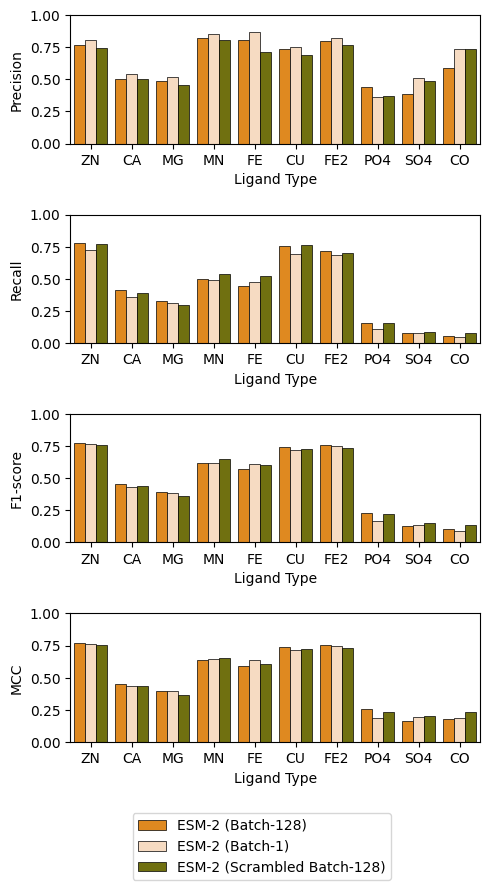

In [708]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', size=10)
matplotlib.rc('axes', titlesize=10)

unique = df_out["Method"].unique()
figure, axes = plt.subplots(4,1, figsize=(5,8))
#plt.figure(figsize=(6, 4))
order=['ZN','CA','MG','MN','FE','CU','FE2','PO4','SO4','CO']
#plum', 'seagreen','gold','darkorange','peachpuff'
sns.barplot(data=df_out, y='Precision', x='Ligand Type', hue='Method', palette=['darkorange','peachpuff','olive'], linewidth=0.5, edgecolor="0",ax=axes[0],order=order)
sns.barplot(data=df_out, y='Recall', x='Ligand Type',  hue='Method', palette=['darkorange','peachpuff','olive'], linewidth=0.5, edgecolor="0",ax=axes[1],order=order)
sns.barplot(data=df_out, y='F1-score', x='Ligand Type',  hue='Method',order=order, palette=['darkorange','peachpuff','olive'], linewidth=0.5, edgecolor="0",  ax=axes[2])
sns.barplot(data=df_out, y='MCC', x='Ligand Type',  hue='Method',order=order,palette=['darkorange','peachpuff','olive'], linewidth=0.5, edgecolor="0",  ax=axes[3])
#figure.tight_layout(pad=1.0)

figure.tight_layout(h_pad=2, w_pad=2)

axes[0].legend([],[], frameon=False)
axes[1].legend([],[], frameon=False)
axes[2].legend([],[], frameon=False)
axes[3].legend([],[], frameon=False)


axes[0].set_ylim([0, 1])
axes[1].set_ylim([0, 1])
axes[2].set_ylim([0, 1])
axes[3].set_ylim([0, 1])
plt.legend(bbox_to_anchor=(0.8,-0.5))
#plt.legend(bbox_to_anchor=(1,1.5))
#plt.legend(bbox_to_anchor=(0.5,-0.3), ncol=4)

plt.savefig('figures/scrambled_allmeasures.png',  bbox_inches='tight',  pad_inches=0.3,dpi=350)
plt.show()

In [ ]:
df_out.pivot(index=['Ligand Type','Method'], columns=['MCC'])#[['MCC']]

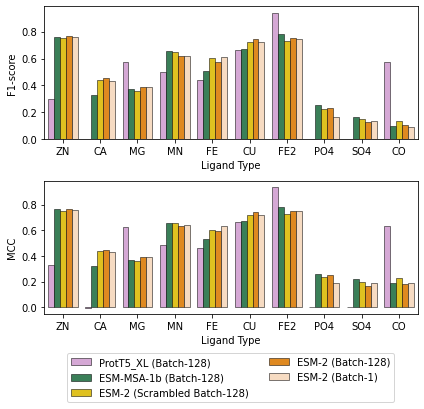

In [176]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
figure, axes = plt.subplots(2,1, figsize=(6,5))
order=['ZN','CA','MG','MN','FE','CU','FE2','PO4','SO4','CO']


sns.barplot(data=df_out, y='F1-score', x='Ligand Type',  hue='Method',order=order, palette=['plum', 'seagreen','gold','darkorange','peachpuff'], linewidth=0.5, edgecolor="0",  ax=axes[0])
sns.barplot(data=df_out, y='MCC', x='Ligand Type',  hue='Method',order=order,palette=['plum', 'seagreen','gold','darkorange','peachpuff'], linewidth=0.5, edgecolor="0",  ax=axes[1])

#sns.barplot(data=df_out, y='ROC-AUC Score', x='Ligand Type', hue='Method', ax=axes[2],order=order)
#sns.barplot(data=df_out, y='Average Precision', x='Ligand Type',  hue='Method', ax=axes[3],order=order)
figure.tight_layout()

#figure.tight_layout(h_pad=0, w_pad=2)

axes[0].legend([],[], frameon=False)
axes[1].legend([],[], frameon=False)
#axes[2].legend([],[], frameon=False)
#axes[3].legend([],[], frameon=False)
#plt.legend()
#plt.legend(bbox_to_anchor=(1,1.5))
#plt.legend(bbox_to_anchor=(0,-0.3), ncol=3)
plt.legend(loc='lower center',bbox_to_anchor=(0.5,-0.7),ncol=2)

plt.savefig('figures/comparison_f1_mcc_poster.png', bbox_inches='tight', dpi=350)
plt.show()

## Log Odds (Supplementary)

In [106]:
with open('/backup/MION_mpnn/data/multi_ion.pkl', 'rb') as handle:
    data = pickle.load(handle)

df = pd.read_csv('/backup/MION_mpnn/data/LigID_pdbchain_partitions.csv')
## Filter dictionary to only training set (29409)
your_keys= list(df['pdbchain'])
dataf = {key: data[key] for key in your_keys}
print (len(dataf.keys()))

29409


In [107]:
from collections import Counter

bind_sites = []
non_bsites = []
clist=[]

ilst = []
pdblst = []
seq_org = []
seq_new = []

fields = ['CA','CO','CU','FE','FE2','MG','MN','PO4','SO4','ZN']
bind_dict = {k: {} for k in fields}
nonbind_dict = {k: {} for k in fields}

#print (lab_dict)

for ion in fields:   
    #print (ion)
    
    for name in dataf.keys():
        
        if ion in dataf[name]['ions'].keys():
            
            pred = list(dataf[name]['ions'][ion])
            #print (name, ion, pred)
            pdblst.append(name)

            ilst.append(ion)
            seq =  dataf[name]['seq']
            seq_org.append(seq)

            ind_0 = ([i for i,val in enumerate(pred) if val=='0'])
            ind_1 = ([i for i,val in enumerate(pred) if val=='1'])
            
            bind_sites.extend([seq[x] for x in ind_1])
            non_bsites.extend([seq[x] for x in ind_0])

        else:
            #print (name, dataf[name])
            continue
            
        #c =c+1
        #if c >10:
        #    break
            
    bs = Counter(bind_sites)
    nbs = Counter(non_bsites)
    
    bind_dict[ion] = bs
    nonbind_dict[ion] = nbs           
#bind_dict, nonbind_dict

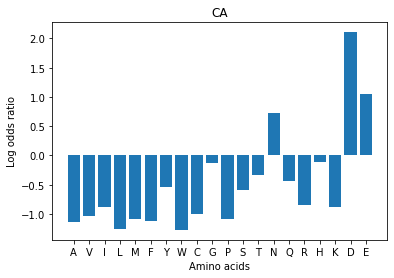

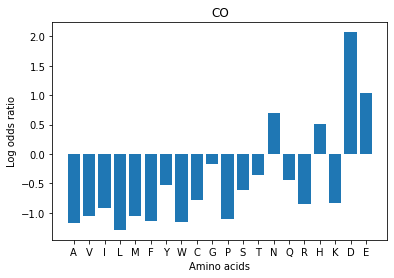

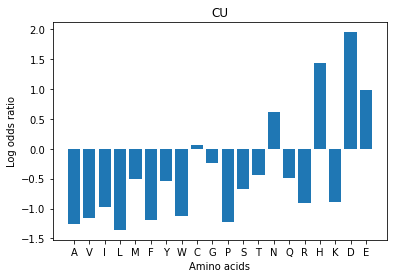

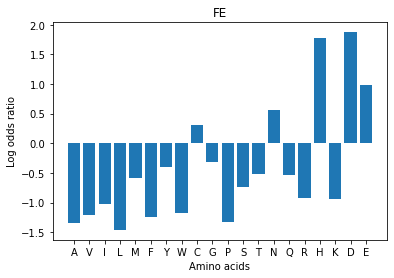

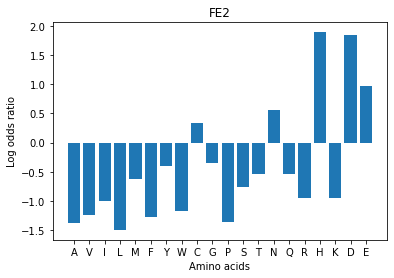

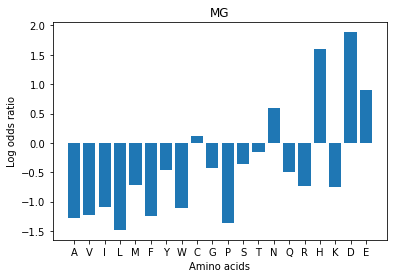

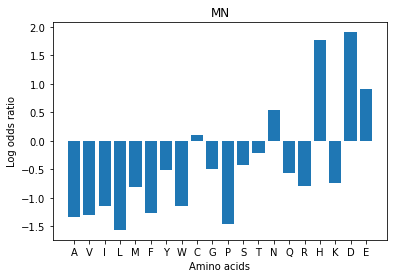

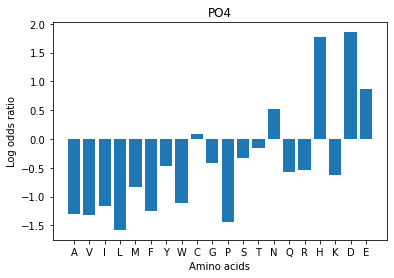

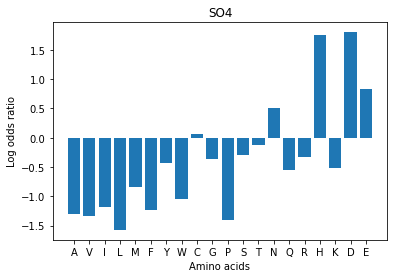

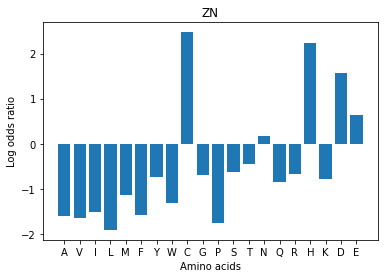

In [108]:
dd = {}
import math 

aa_list = ['A','V','I','L','M','F','Y','W','C','G','P','S','T','N','Q','R','H','K','D','E','X']

for ion in bind_dict.keys():
    #print (ion)
    #print (bind_dict[ion])
    for aa in aa_list:
        #print (aa)
        new_d = bind_dict[ion]
        #print (new_d)
        a = new_d[aa]
        new_d = {k: bind_dict[ion][k] for k in set(list(bind_dict[ion].keys())) - set(aa)}
        #print (new_d)
        b =sum(new_d.values())
        
        new_dd=nonbind_dict[ion]
        c = new_dd[aa]
        new_dd = {k: nonbind_dict[ion][k] for k in set(list(nonbind_dict[ion].keys())) - set(aa)}
        d =sum(new_dd.values())
        #print (aa, a, b,c,d)
    
        try:
            odd_ratio = ((a/c)/(b/d))
            lor = math.log(odd_ratio)
            dd[aa] = lor
            #print (lor)
        except:
            continue

    #print (dd)
    
    names = list(dd.keys())
    values = list(dd.values())

    plt.bar(range(len(dd)), values, tick_label=names)
    plt.title("{}".format(ion))
    plt.xlabel('Amino acids')
    plt.ylabel('Log odds ratio')
    plt.savefig('figures/LogOdds/logodds_{}.png'.format(ion), dpi=350)
    plt.show()

#plt.figure(figsize=(15,5))
#plt.bar(d3.keys(), d3.values(), width=0.5, color='g')



#d2  = Counter(clist)
#d3 = {x:round(float(d2[x])/d1[x],3) for x in d1}
#print (d1,d2,d3)



## PSSM

In [347]:
# Ionic (esm2 batch128) Fold 5
df_org = pd.read_csv('data/supp/pssm_results/pred_esm2_t33_650M_UR50D_batch128_CV_fold5.csv')
df_org.head(4)

df1=df_org[['target', 'predictions']]
columns=list(df1)
print (columns)

for i in columns:
    df_org[i] = df_org[i].apply(lambda x: [ (_.replace('[','').replace(']','')) for _ in x.split(', ')]).apply(lambda x: [float(x1) for x1 in x])#.apply(lambda x: _ for _ in x)
print (len(df_org))
df_org.head(4)

d_id=['CA','CO','CU','FE','FE2','MG','MN','PO4','SO4','ZN']

def flatten(l):
    return [(item) for sublist in l for item in sublist]


df_esm1 = df_org.groupby(['ions']).agg(list).reset_index()
df_esm1['true'] = df_esm1['target'].apply(flatten)
df_esm1['pred'] = df_esm1['predictions'].apply(flatten)

df_esm1=df_esm1.drop(['pdbid', 'target', 'predictions'], axis=1)
df_esm1

pid=[]
lid=[]
rocauc=[]
avgpr=[]
f1=[]
mcc=[]
pre = []
rec =[]

for i in df_esm1['ions']:
    
    prediction = df_esm1[df_esm1['ions']==i]['pred'].values[0]
    target = df_esm1[df_esm1['ions']==i]['true'].values[0]
    #print (i,prediction, target)
    #fpr, tpr, threshold = roc_curve(target, prediction)
    #precision, recall, thresholds = precision_recall_curve(target, prediction)
            
    precision = precision_score(target, prediction, zero_division=0)
    recall = recall_score(target, prediction, zero_division=0)
    roc_auc = roc_auc_score(target, prediction)
    avg_pr = average_precision_score(target, prediction)
    f1score = f1_score(target, prediction, average='binary')
    mcc_score = matthews_corrcoef(target, prediction)
    #print (i, roc_auc, avg_pr, f1score, mcc_score)
        
    lid.append(i)
    rocauc.append(roc_auc)
    avgpr.append(avg_pr)
    f1.append(f1score)
    mcc.append(mcc_score)
    pre.append(precision)
    rec.append(recall)

b = pd.Series(lid)
c = pd.Series(rocauc)
d = pd.Series(avgpr)
e = pd.Series(f1)
f = pd.Series(mcc)
g = pd.Series(pre)
h = pd.Series(rec)

out_df_esm2_b128_F5 = pd.DataFrame({'Ligand Type':b, 'ROC-AUC':c, 'Avg_P':d, 'F1':e, 'MCC':f, 'Precision':g, 'Recall':h})
out_df_esm2_b128_F5=out_df_esm2_b128_F5.rename(columns={"ROC-AUC": "ROC-AUC Score", "Avg_P": "Average Precision", "F1":"F1-score", "LIG":"Ligand Type"})
out_df_esm2_b128_F5['Method']='ESM-2'
out_df_esm2_b128_F5

['target', 'predictions']
3294


,Ligand Type,ROC-AUC Score,Average Precision,F1-score,MCC,Precision,Recall,Method
0,CA,0.703095,0.194693,0.429315,0.419795,0.444199,0.415397,ESM-2
1,CO,0.578903,0.134879,0.262774,0.344601,0.765957,0.158590,ESM-2
2,CU,0.902874,0.486838,0.687031,0.690032,0.593939,0.814727,ESM-2
3,FE,0.762983,0.394831,0.612680,0.613131,0.725111,0.530435,ESM-2
4,FE2,0.865571,0.582707,0.760331,0.757427,0.788571,0.734043,ESM-2
5,MG,0.665797,0.144174,0.367487,0.361810,0.402938,0.337770,ESM-2
6,MN,0.773439,0.430265,0.641882,0.647299,0.772367,0.549114,ESM-2
7,PO4,0.599506,0.105174,0.279195,0.291680,0.442553,0.203922,ESM-2
8,SO4,0.553640,0.065462,0.176292,0.214687,0.446154,0.109848,ESM-2
9,ZN,0.898732,0.578717,0.757611,0.754928,0.717671,0.802259,ESM-2


In [348]:
# PSSM Fold 5
df_org = pd.read_csv('data/supp/pssm_results/pred_PSSM_batch128_CV_fold5.csv')
df_org.head(4)

df1=df_org[['target', 'predictions']]
columns=list(df1)
print (columns)

for i in columns:
    df_org[i] = df_org[i].apply(lambda x: [ (_.replace('[','').replace(']','')) for _ in x.split(', ')]).apply(lambda x: [float(x1) for x1 in x])#.apply(lambda x: _ for _ in x)
print (len(df_org))
df_org.head(4)

d_id=['CA','CO','CU','FE','FE2','MG','MN','PO4','SO4','ZN']

def flatten(l):
    return [(item) for sublist in l for item in sublist]


df_esm1 = df_org.groupby(['ions']).agg(list).reset_index()
df_esm1['true'] = df_esm1['target'].apply(flatten)
df_esm1['pred'] = df_esm1['predictions'].apply(flatten)

df_esm1=df_esm1.drop(['pdbid', 'target', 'predictions'], axis=1)
df_esm1

pid=[]
lid=[]
rocauc=[]
avgpr=[]
f1=[]
mcc=[]
pre = []
rec =[]

for i in df_esm1['ions']:
    
    prediction = df_esm1[df_esm1['ions']==i]['pred'].values[0]
    target = df_esm1[df_esm1['ions']==i]['true'].values[0]
    #print (i,prediction, target)
    #fpr, tpr, threshold = roc_curve(target, prediction)
    #precision, recall, thresholds = precision_recall_curve(target, prediction)
            
    precision = precision_score(target, prediction, zero_division=0)
    recall = recall_score(target, prediction, zero_division=0)
    roc_auc = roc_auc_score(target, prediction)
    avg_pr = average_precision_score(target, prediction)
    f1score = f1_score(target, prediction, average='binary')
    mcc_score = matthews_corrcoef(target, prediction)
    #print (i, roc_auc, avg_pr, f1score, mcc_score)
        
    lid.append(i)
    rocauc.append(roc_auc)
    avgpr.append(avg_pr)
    f1.append(f1score)
    mcc.append(mcc_score)
    pre.append(precision)
    rec.append(recall)

b = pd.Series(lid)
c = pd.Series(rocauc)
d = pd.Series(avgpr)
e = pd.Series(f1)
f = pd.Series(mcc)
g = pd.Series(pre)
h = pd.Series(rec)

PSSM_F5 = pd.DataFrame({'Ligand Type':b, 'ROC-AUC':c, 'Avg_P':d, 'F1':e, 'MCC':f, 'Precision':g, 'Recall':h})
PSSM_F5=PSSM_F5.rename(columns={"ROC-AUC": "ROC-AUC Score", "Avg_P": "Average Precision", "F1":"F1-score", "LIG":"Ligand Type"})
PSSM_F5['Method']='PSSM'
PSSM_F5

['target', 'predictions']
3293


,Ligand Type,ROC-AUC Score,Average Precision,F1-score,MCC,Precision,Recall,Method
0,CA,0.548886,0.036294,0.137235,0.132996,0.196627,0.105399,PSSM
1,CO,0.500000,0.015932,0.000000,0.000000,0.000000,0.000000,PSSM
2,CU,0.627337,0.188827,0.374026,0.415606,0.690096,0.256532,PSSM
3,FE,0.533394,0.068298,0.123138,0.215033,0.712644,0.067391,PSSM
4,FE2,0.651125,0.260581,0.443580,0.496599,0.826087,0.303191,PSSM
5,MG,0.608457,0.058923,0.222440,0.212693,0.218100,0.226955,PSSM
6,MN,0.629016,0.156055,0.355848,0.376529,0.559585,0.260870,PSSM
7,PO4,0.500000,0.018752,0.000000,0.000000,0.000000,0.000000,PSSM
8,SO4,0.500000,0.018484,0.000000,0.000000,0.000000,0.000000,PSSM
9,ZN,0.812925,0.307841,0.544081,0.542086,0.475081,0.636532,PSSM


In [349]:
# PSSM+esm2 Fold 5
df_org = pd.read_csv('data/supp/pssm_results/pred_PSSM_esm2_t33_650M_UR50D_batch128_CV_fold5.csv')
df_org.head(4)

df1=df_org[['target', 'predictions']]
columns=list(df1)
print (columns)

for i in columns:
    df_org[i] = df_org[i].apply(lambda x: [ (_.replace('[','').replace(']','')) for _ in x.split(', ')]).apply(lambda x: [float(x1) for x1 in x])#.apply(lambda x: _ for _ in x)
print (len(df_org))
df_org.head(4)

d_id=['CA','CO','CU','FE','FE2','MG','MN','PO4','SO4','ZN']

def flatten(l):
    return [(item) for sublist in l for item in sublist]


df_esm1 = df_org.groupby(['ions']).agg(list).reset_index()
df_esm1['true'] = df_esm1['target'].apply(flatten)
df_esm1['pred'] = df_esm1['predictions'].apply(flatten)

df_esm1=df_esm1.drop(['pdbid', 'target', 'predictions'], axis=1)
df_esm1

pid=[]
lid=[]
rocauc=[]
avgpr=[]
f1=[]
mcc=[]
pre = []
rec =[]

for i in df_esm1['ions']:
    
    prediction = df_esm1[df_esm1['ions']==i]['pred'].values[0]
    target = df_esm1[df_esm1['ions']==i]['true'].values[0]
    #print (i,prediction, target)
    #fpr, tpr, threshold = roc_curve(target, prediction)
    #precision, recall, thresholds = precision_recall_curve(target, prediction)
            
    precision = precision_score(target, prediction, zero_division=0)
    recall = recall_score(target, prediction, zero_division=0)
    roc_auc = roc_auc_score(target, prediction)
    avg_pr = average_precision_score(target, prediction)
    f1score = f1_score(target, prediction, average='binary')
    mcc_score = matthews_corrcoef(target, prediction)
    #print (i, roc_auc, avg_pr, f1score, mcc_score)
        
    lid.append(i)
    rocauc.append(roc_auc)
    avgpr.append(avg_pr)
    f1.append(f1score)
    mcc.append(mcc_score)
    pre.append(precision)
    rec.append(recall)

b = pd.Series(lid)
c = pd.Series(rocauc)
d = pd.Series(avgpr)
e = pd.Series(f1)
f = pd.Series(mcc)
g = pd.Series(pre)
h = pd.Series(rec)

PSSM_esm_F5 = pd.DataFrame({'Ligand Type':b, 'ROC-AUC':c, 'Avg_P':d, 'F1':e, 'MCC':f, 'Precision':g, 'Recall':h})
PSSM_esm_F5=PSSM_esm_F5.rename(columns={"ROC-AUC": "ROC-AUC Score", "Avg_P": "Average Precision", "F1":"F1-score", "LIG":"Ligand Type"})
PSSM_esm_F5['Method']='ESM-2 + PSSM'
PSSM_esm_F5

['target', 'predictions']
3293


,Ligand Type,ROC-AUC Score,Average Precision,F1-score,MCC,Precision,Recall,Method
0,CA,0.707629,0.181351,0.413784,0.403272,0.401801,0.426505,ESM-2 + PSSM
1,CO,0.537302,0.075364,0.137097,0.243501,0.809524,0.074890,ESM-2 + PSSM
2,CU,0.901198,0.488557,0.688855,0.691271,0.598598,0.811164,ESM-2 + PSSM
3,FE,0.744674,0.369473,0.587702,0.591603,0.726400,0.493478,ESM-2 + PSSM
4,FE2,0.862481,0.543588,0.734584,0.730730,0.740541,0.728723,ESM-2 + PSSM
5,MG,0.672613,0.148469,0.374159,0.367698,0.399622,0.351747,ESM-2 + PSSM
6,MN,0.762766,0.394001,0.614232,0.618232,0.733781,0.528180,ESM-2 + PSSM
7,PO4,0.610516,0.125341,0.309140,0.324636,0.491453,0.225490,ESM-2 + PSSM
8,SO4,0.545530,0.047883,0.147059,0.168588,0.328947,0.094697,ESM-2 + PSSM
9,ZN,0.893787,0.553119,0.739981,0.737462,0.693690,0.792891,ESM-2 + PSSM


In [350]:
# esm2+esm_msa Fold 5
df_org = pd.read_csv('data/supp/pssm_results/pred_esm2_t33_650M_UR50D_esm_msa1b_t12_100M_UR50S_batch128_CV_fold5.csv')
df_org.head(4)

df1=df_org[['target', 'predictions']]
columns=list(df1)
print (columns)

for i in columns:
    df_org[i] = df_org[i].apply(lambda x: [ (_.replace('[','').replace(']','')) for _ in x.split(', ')]).apply(lambda x: [float(x1) for x1 in x])#.apply(lambda x: _ for _ in x)
print (len(df_org))
df_org.head(4)

d_id=['CA','CO','CU','FE','FE2','MG','MN','PO4','SO4','ZN']

def flatten(l):
    return [(item) for sublist in l for item in sublist]


df_esm1 = df_org.groupby(['ions']).agg(list).reset_index()
df_esm1['true'] = df_esm1['target'].apply(flatten)
df_esm1['pred'] = df_esm1['predictions'].apply(flatten)

df_esm1=df_esm1.drop(['pdbid', 'target', 'predictions'], axis=1)
df_esm1

pid=[]
lid=[]
rocauc=[]
avgpr=[]
f1=[]
mcc=[]
pre = []
rec =[]

for i in df_esm1['ions']:
    
    prediction = df_esm1[df_esm1['ions']==i]['pred'].values[0]
    target = df_esm1[df_esm1['ions']==i]['true'].values[0]
    #print (i,prediction, target)
    #fpr, tpr, threshold = roc_curve(target, prediction)
    #precision, recall, thresholds = precision_recall_curve(target, prediction)
            
    precision = precision_score(target, prediction, zero_division=0)
    recall = recall_score(target, prediction, zero_division=0)
    roc_auc = roc_auc_score(target, prediction)
    avg_pr = average_precision_score(target, prediction)
    f1score = f1_score(target, prediction, average='binary')
    mcc_score = matthews_corrcoef(target, prediction)
    #print (i, roc_auc, avg_pr, f1score, mcc_score)
        
    lid.append(i)
    rocauc.append(roc_auc)
    avgpr.append(avg_pr)
    f1.append(f1score)
    mcc.append(mcc_score)
    pre.append(precision)
    rec.append(recall)

b = pd.Series(lid)
c = pd.Series(rocauc)
d = pd.Series(avgpr)
e = pd.Series(f1)
f = pd.Series(mcc)
g = pd.Series(pre)
h = pd.Series(rec)

esmMSA_esm_F5= pd.DataFrame({'Ligand Type':b, 'ROC-AUC':c, 'Avg_P':d, 'F1':e, 'MCC':f, 'Precision':g, 'Recall':h})
esmMSA_esm_F5=esmMSA_esm_F5.rename(columns={"ROC-AUC": "ROC-AUC Score", "Avg_P": "Average Precision", "F1":"F1-score", "LIG":"Ligand Type"})
esmMSA_esm_F5['Method']='ESM-2 + ESM-MSA-1b'
esmMSA_esm_F5

['target', 'predictions']
3293


,Ligand Type,ROC-AUC Score,Average Precision,F1-score,MCC,Precision,Recall,Method
0,CA,0.719367,0.187045,0.420318,0.410327,0.393509,0.451046,ESM-2 + ESM-MSA-1b
1,CO,0.528456,0.056380,0.106122,0.200617,0.722222,0.057269,ESM-2 + ESM-MSA-1b
2,CU,0.912107,0.516399,0.708797,0.711594,0.617077,0.832542,ESM-2 + ESM-MSA-1b
3,FE,0.692548,0.302512,0.510365,0.530879,0.745303,0.388043,ESM-2 + ESM-MSA-1b
4,FE2,0.857240,0.539682,0.731707,0.727965,0.745856,0.718085,ESM-2 + ESM-MSA-1b
5,MG,0.668679,0.145001,0.369126,0.362933,0.398534,0.343760,ESM-2 + ESM-MSA-1b
6,MN,0.803393,0.466255,0.674989,0.674990,0.756244,0.609501,ESM-2 + ESM-MSA-1b
7,PO4,0.595922,0.107131,0.276625,0.295216,0.469484,0.196078,ESM-2 + ESM-MSA-1b
8,SO4,0.559429,0.075917,0.194529,0.237856,0.492308,0.121212,ESM-2 + ESM-MSA-1b
9,ZN,0.917927,0.638498,0.796493,0.794338,0.757318,0.839942,ESM-2 + ESM-MSA-1b


In [351]:
# Ionic (esm_msa batch128)
df_esm1b = pd.read_csv('data/supp/pred_esm_msa1b_t12_100M_UR50S_batch128_CV_fold1.csv')
df_esm1b.head(4)

df1=df_esm1b[['target', 'predictions']]
columns=list(df1)
print (columns)

for i in columns:
    df_esm1b[i] = df_esm1b[i].apply(lambda x: [ (_.replace('[','').replace(']','')) for _ in x.split(', ')]).apply(lambda x: [float(x1) for x1 in x])#.apply(lambda x: _ for _ in x)
print (len(df_esm1b))
df_esm1b.head(4)

d_id=['CA','CO','CU','FE','FE2','MG','MN','PO4','SO4','ZN']

def flatten(l):
    return [(item) for sublist in l for item in sublist]


df_esm1 = df_esm1b.groupby(['ions']).agg(list).reset_index()
df_esm1['true'] = df_esm1['target'].apply(flatten)
df_esm1['pred'] = df_esm1['predictions'].apply(flatten)

df_esm1=df_esm1.drop(['pdbid', 'target', 'predictions'], axis=1)
df_esm1

pid=[]
lid=[]
rocauc=[]
avgpr=[]
f1=[]
mcc=[]
pre = []
rec =[]

for i in df_esm1['ions']:
    
    prediction = df_esm1[df_esm1['ions']==i]['pred'].values[0]
    target = df_esm1[df_esm1['ions']==i]['true'].values[0]
    #print (i,prediction, target)
    #fpr, tpr, threshold = roc_curve(target, prediction)
    #precision, recall, thresholds = precision_recall_curve(target, prediction)
    precision = precision_score(target, prediction, zero_division=0)
    recall = recall_score(target, prediction, zero_division=0)
    roc_auc = roc_auc_score(target, prediction)
    avg_pr = average_precision_score(target, prediction)
    f1score = f1_score(target, prediction, average='binary')
    mcc_score = matthews_corrcoef(target, prediction)
    #print (i, roc_auc, avg_pr, f1score, mcc_score)
        
    lid.append(i)
    rocauc.append(roc_auc)
    avgpr.append(avg_pr)
    f1.append(f1score)
    mcc.append(mcc_score)
    pre.append(precision)
    rec.append(recall)

b = pd.Series(lid)
c = pd.Series(rocauc)
d = pd.Series(avgpr)
e = pd.Series(f1)
f = pd.Series(mcc)
g = pd.Series(pre)
h = pd.Series(rec)

out_df_esm_msa_b128 = pd.DataFrame({'Ligand Type':b, 'ROC-AUC':c, 'Avg_P':d, 'F1':e, 'MCC':f, 'Precision':g, 'Recall':h})
out_df_esm_msa_b128=out_df_esm_msa_b128.rename(columns={"ROC-AUC": "ROC-AUC Score", "Avg_P": "Average Precision", "F1":"F1-score", "LIG":"Ligand Type"})
out_df_esm_msa_b128['Method']='ESM-MSA-1b (Batch-128)'
out_df_esm_msa_b128

['target', 'predictions']
3293


,Ligand Type,ROC-AUC Score,Average Precision,F1-score,MCC,Precision,Recall,Method
0,CA,0.706922,0.125859,0.330682,0.325865,0.266709,0.435030,ESM-MSA-1b (Batch-128)
1,CO,0.526253,0.052405,0.098361,0.190448,0.705882,0.052863,ESM-MSA-1b (Batch-128)
2,CU,0.890308,0.462433,0.669688,0.671644,0.581294,0.789786,ESM-MSA-1b (Batch-128)
3,FE,0.690411,0.300355,0.507184,0.528820,0.747881,0.383696,ESM-MSA-1b (Batch-128)
4,FE2,0.897134,0.613552,0.781250,0.778133,0.765306,0.797872,ESM-MSA-1b (Batch-128)
5,MG,0.661088,0.150207,0.373151,0.370206,0.433671,0.327454,ESM-MSA-1b (Batch-128)
6,MN,0.795974,0.439161,0.655142,0.654297,0.728797,0.595008,ESM-MSA-1b (Batch-128)
7,PO4,0.590421,0.088993,0.253333,0.262295,0.395833,0.186275,ESM-MSA-1b (Batch-128)
8,SO4,0.548386,0.067875,0.165605,0.220689,0.520000,0.098485,ESM-MSA-1b (Batch-128)
9,ZN,0.910041,0.590169,0.764443,0.762733,0.712057,0.825149,ESM-MSA-1b (Batch-128)


In [354]:
result1 = [out_df_esm2_b128_F5, PSSM_esm_F5, PSSM_F5, esmMSA_esm_F5, out_df_esm_msa_b128]
df_out = pd.concat(result1, ignore_index=True)
df_out=df_out.sort_values(['Method','Ligand Type'], ascending=False)
df_out = df_out.reset_index(drop=True)
df_out.to_csv('evo.csv', index=False)

In [355]:
df_out

,Ligand Type,ROC-AUC Score,Average Precision,F1-score,MCC,Precision,Recall,Method
0,ZN,0.812925,0.307841,0.544081,0.542086,0.475081,0.636532,PSSM
1,SO4,0.500000,0.018484,0.000000,0.000000,0.000000,0.000000,PSSM
2,PO4,0.500000,0.018752,0.000000,0.000000,0.000000,0.000000,PSSM
3,MN,0.629016,0.156055,0.355848,0.376529,0.559585,0.260870,PSSM
4,MG,0.608457,0.058923,0.222440,0.212693,0.218100,0.226955,PSSM
5,FE2,0.651125,0.260581,0.443580,0.496599,0.826087,0.303191,PSSM
6,FE,0.533394,0.068298,0.123138,0.215033,0.712644,0.067391,PSSM
7,CU,0.627337,0.188827,0.374026,0.415606,0.690096,0.256532,PSSM
8,CO,0.500000,0.015932,0.000000,0.000000,0.000000,0.000000,PSSM
9,CA,0.548886,0.036294,0.137235,0.132996,0.196627,0.105399,PSSM


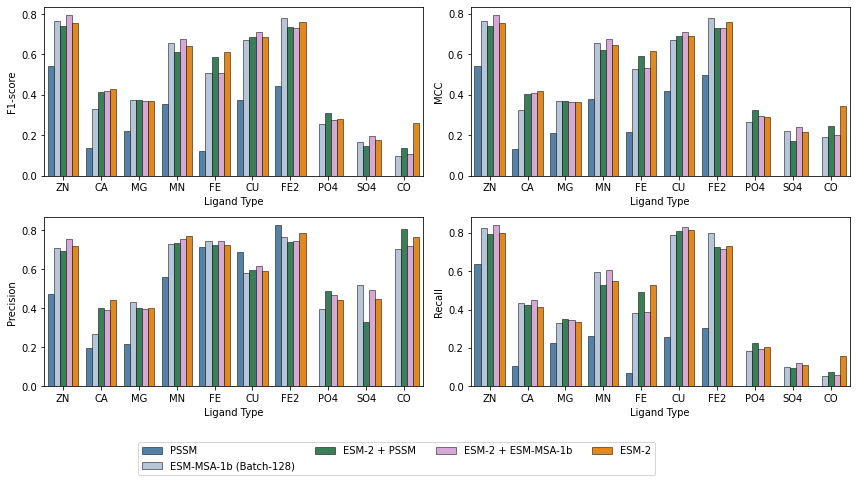

In [78]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(2,2, figsize=(12,6))
#plt.figure(figsize=(6, 4))
order=['ZN','CA','MG','MN','FE','CU','FE2','PO4','SO4','CO']


sns.barplot(data=df_out, y='F1-score', x='Ligand Type',  hue='Method',palette=['steelblue','lightsteelblue','seagreen','plum', 'darkorange'], linewidth=0.5, edgecolor="0",order=order, ax=axes[0,0])
sns.barplot(data=df_out, y='MCC', x='Ligand Type',  hue='Method',palette=['steelblue','lightsteelblue','seagreen','plum','darkorange'], linewidth=0.5, edgecolor="0",order=order, ax=axes[0,1])
sns.barplot(data=df_out, y='Precision', x='Ligand Type', hue='Method', palette=['steelblue','lightsteelblue','seagreen','plum','darkorange'], linewidth=0.5, edgecolor="0",ax=axes[1,0],order=order)
sns.barplot(data=df_out, y='Recall', x='Ligand Type',  hue='Method', palette=['steelblue','lightsteelblue','seagreen','plum','darkorange'], linewidth=0.5, edgecolor="0",ax=axes[1,1],order=order)
figure.tight_layout()

#figure.tight_layout(h_pad=0, w_pad=2)

axes[0,1].legend([],[], frameon=False)
axes[1,0].legend([],[], frameon=False)
axes[0,0].legend([],[], frameon=False)
axes[1,1].legend([],[], frameon=False)
#plt.legend()
#plt.legend(bbox_to_anchor=(1,1.5))
#plt.legend(bbox_to_anchor=(-0.5,-0.3))
plt.legend(bbox_to_anchor=(0.5,-0.3), ncol=4)
#plt.legend(loc='lower right',bbox_to_anchor=(0.1,-0.8))

#plt.savefig('figures/esm_pssm_msa_allmeasures_1x4.png',  bbox_inches='tight',  pad_inches=0.3,dpi=350)
plt.show()

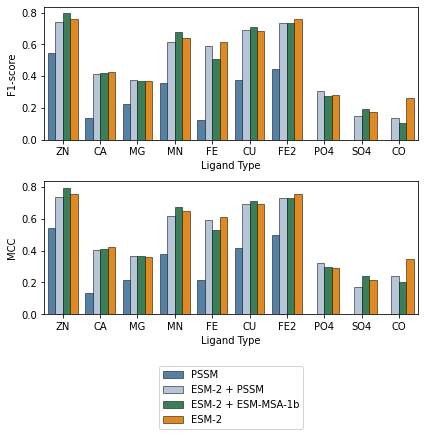

In [63]:
figure, axes = plt.subplots(2,1, figsize=(6,5))
#plt.figure(figsize=(6, 4))
order=['ZN','CA','MG','MN','FE','CU','FE2','PO4','SO4','CO']


sns.barplot(data=df_out, y='F1-score', x='Ligand Type',  hue='Method',palette=['steelblue','lightsteelblue','seagreen','darkorange'], linewidth=0.5, edgecolor="0",order=order, ax=axes[0])
sns.barplot(data=df_out, y='MCC', x='Ligand Type',  hue='Method',palette=['steelblue','lightsteelblue','seagreen','darkorange'], linewidth=0.5, edgecolor="0",order=order, ax=axes[1])
#sns.barplot(data=df_out, y='Precision', x='Ligand Type', hue='Method', palette=['royalblue','darkorange','seagreen'], linewidth=0.5, edgecolor="0",ax=axes[2],order=order)
#sns.barplot(data=df_out, y='Recall', x='Ligand Type',  hue='Method', palette=['royalblue','darkorange','seagreen'], linewidth=0.5, edgecolor="0",ax=axes[3],order=order)
figure.tight_layout()

axes[0].legend([],[], frameon=False)
axes[1].legend([],[], frameon=False)
#axes[2].legend([],[], frameon=False)
#axes[3].legend([],[], frameon=False)
#plt.legend()
#plt.legend(bbox_to_anchor=(1,1.5))
plt.legend(loc='lower center',bbox_to_anchor=(0.5,-0.9))
#plt.legend(loc='lower right',bbox_to_anchor=(0.3,-0.1))
plt.savefig('figures/esm_pssm_msa_allmeasures_2x1.png', bbox_inches='tight', dpi=350)


## Analysis on specific groups (Transmembrane, DNA-binding)

In [436]:
# Ionic (esm2)
df_esm1b = pd.read_csv('data/RecentProteins/fig1/pred_esm2_t33_650M_UR50D_batch128_CV_fold5.csv')
df_esm1b.head(4)

df1=df_esm1b[['target', 'predictions']]
columns=list(df1)
print (columns)

for i in columns:
    df_esm1b[i] = df_esm1b[i].apply(lambda x: [ (_.replace('[','').replace(']','')) for _ in x.split(', ')]).apply(lambda x: [float(x1) for x1 in x])#.apply(lambda x: _ for _ in x)
print (len(df_esm1b))
#print (df_esm1b.head(4))

d_id=['CA','CO','CU','FE','FE2','MG','MN','PO4','SO4','ZN']


pid=[]
lid=[]
rocauc=[]
avgpr=[]
f1=[]
mcc=[]
pre = []
rec =[]

for i in df_esm1b.pdbid:
    
    prediction = df_esm1b[df_esm1b['pdbid']==i]['predictions'].values[0]
    target = df_esm1b[df_esm1b['pdbid']==i]['target'].values[0]
    ion = df_esm1b[df_esm1b['pdbid']==i]['ions'].values[0]
            
    precision = precision_score(target, prediction, zero_division=0)
    recall = recall_score(target, prediction, zero_division=0)
    roc_auc = roc_auc_score(target, prediction)
    avg_pr = average_precision_score(target, prediction)
    f1score = f1_score(target, prediction, average='binary')
    mcc_score = matthews_corrcoef(target, prediction)
    #print (i, ion, precision, recall, roc_auc, avg_pr, f1score, mcc_score)
    
    pid.append(i)
    lid.append(ion)
    rocauc.append(roc_auc)
    avgpr.append(avg_pr)
    f1.append(f1score)
    mcc.append(mcc_score)
    pre.append(precision)
    rec.append(recall)

a = pd.Series(pid)
b = pd.Series(lid)
c = pd.Series(rocauc)
d = pd.Series(avgpr)
e = pd.Series(f1)
f = pd.Series(mcc)
g = pd.Series(pre)
h = pd.Series(rec)


out_df = pd.DataFrame({'pdbid':a, 'Ion':b, 'ROC-AUC':c, 'Avg_P':d, 'F1':e, 'MCC':f, 'Precision':g, 'Recall':h})
out_df=out_df.rename(columns={"ROC-AUC": "ROC-AUC Score", "Avg_P": "Average Precision", "F1":"F1-score", "Ion":"Ligand Type"})
out_df[['From','chain']] = out_df['pdbid'].str.split('_',expand=True)
out_df = out_df.drop(['pdbid', 'chain'], axis=1)
out_df

['target', 'predictions']
5673


,Ligand Type,ROC-AUC Score,Average Precision,F1-score,MCC,Precision,Recall,From
0,ZN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1a1t
1,ZN,0.971154,0.727273,0.842105,0.827837,0.727273,1.000000,1a7i
2,MG,0.660714,0.122807,0.333333,0.321429,0.333333,0.333333,1aa9
3,ZN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1aaf
4,SO4,0.494898,0.010101,0.000000,-0.010204,0.000000,0.000000,1aic
...,...,...,...,...,...,...,...,...
5668,MG,0.500000,0.010959,0.000000,0.000000,0.000000,0.000000,8sng
5669,MG,0.500000,0.018987,0.000000,0.000000,0.000000,0.000000,8sqo
5670,FE2,0.843243,0.563432,0.736842,0.721188,0.777778,0.700000,8sqr
5671,FE2,0.930921,0.686806,0.823529,0.815239,0.777778,0.875000,8sqt


In [437]:
df= pd.read_csv('data/supp/idmapping_230720_only_recent.tsv' ,delimiter='\t',)
df

,From,Entry,Entry Name,Taxonomic lineage,DNA binding,Gene Ontology IDs,Transmembrane,Length
0,1e4a,P0AB87,FUCA_ECOLI,"cellular organisms (no rank), Bacteria (superk...",NaN,GO:0005829; GO:0008270; GO:0008738; GO:0016832...,NaN,215
1,1a1t,Q75677,Q75677_9HIV1,"Viruses (superkingdom), Riboviria (no rank), P...",NaN,GO:0003676; GO:0008270,NaN,107
2,1e4b,P0AB87,FUCA_ECOLI,"cellular organisms (no rank), Bacteria (superk...",NaN,GO:0005829; GO:0008270; GO:0008738; GO:0016832...,NaN,215
3,1a7i,Q05158,CSRP2_COTJA,"cellular organisms (no rank), Eukaryota (super...",NaN,GO:0005634; GO:0008270; GO:0030154,NaN,194
4,1e4c,P0AB87,FUCA_ECOLI,"cellular organisms (no rank), Bacteria (superk...",NaN,GO:0005829; GO:0008270; GO:0008738; GO:0016832...,NaN,215
...,...,...,...,...,...,...,...,...
12433,8hfn,A0QZY0,MSHC_MYCS2,"cellular organisms (no rank), Bacteria (superk...",NaN,GO:0005524; GO:0008270; GO:0010125; GO:0035446,NaN,412
12434,9pcy,P00287,PLAS_PHAVU,"cellular organisms (no rank), Eukaryota (super...",NaN,GO:0005507; GO:0009055; GO:0009535,NaN,99
12435,8hmq,P14618,KPYM_HUMAN,"cellular organisms (no rank), Eukaryota (super...",NaN,GO:0000287; GO:0003713; GO:0003723; GO:0003729...,NaN,531
12436,8hmr,P14618,KPYM_HUMAN,"cellular organisms (no rank), Eukaryota (super...",NaN,GO:0000287; GO:0003713; GO:0003723; GO:0003729...,NaN,531


In [438]:
import math

dfm = out_df.merge(df, on='From')
out_dfm = dfm.drop_duplicates(subset=['From', 'Ligand Type'])
out_dfm1 = out_dfm.drop(['Entry Name', 'Entry'], axis=1)

#out_dfm1['split_tax'] = out_dfm1['Taxonomic lineage'].str.split()
out_dfm1["DNA binding"] = out_dfm1[['DNA binding']].applymap(lambda x: 0 if pd.isnull(x) else 1)
out_dfm1["Transmembrane"] = out_dfm1[['Transmembrane']].applymap(lambda x: 0 if pd.isnull(x) else 1)

out_dfm1

,Ligand Type,ROC-AUC Score,Average Precision,F1-score,MCC,Precision,Recall,From,Taxonomic lineage,DNA binding,Gene Ontology IDs,Transmembrane,Length
0,ZN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1a1t,"Viruses (superkingdom), Riboviria (no rank), P...",0,GO:0003676; GO:0008270,0,107
1,ZN,0.971154,0.727273,0.842105,0.827837,0.727273,1.000000,1a7i,"cellular organisms (no rank), Eukaryota (super...",0,GO:0005634; GO:0008270; GO:0030154,0,194
2,MG,0.660714,0.122807,0.333333,0.321429,0.333333,0.333333,1aa9,"cellular organisms (no rank), Eukaryota (super...",0,GO:0000139; GO:0000165; GO:0001934; GO:0003924...,0,189
3,ZN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1aaf,"Viruses (superkingdom), Riboviria (no rank), P...",0,GO:0000049; GO:0005198; GO:0008270; GO:0016020...,0,507
5,SO4,0.494898,0.010101,0.000000,-0.010204,0.000000,0.000000,1aic,"cellular organisms (no rank), Bacteria (superk...",0,GO:0004069; GO:0004838; GO:0005737; GO:0005829...,0,396
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30577,ZN,0.992806,0.900000,0.947368,0.941834,0.900000,1.000000,8hz2,"cellular organisms (no rank), Eukaryota (super...",0,GO:0000122; GO:0000209; GO:0001503; GO:0001701...,0,522
30578,MN,0.621711,0.144231,0.333333,0.342007,0.500000,0.250000,8i8s,"cellular organisms (no rank), Eukaryota (super...",0,GO:0001669; GO:0005615; GO:0005634; GO:0005737...,0,156
30579,ZN,0.993151,0.875000,0.933333,0.928985,0.875000,1.000000,8ifo,"cellular organisms (no rank), Eukaryota (super...",1,GO:0000785; GO:0000981; GO:0001228; GO:0003707...,0,458
30580,CA,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8ing,"cellular organisms (no rank), Eukaryota (super...",0,GO:0001580; GO:0004601; GO:0005509; GO:0005615...,0,712


In [407]:
tm1 = out_dfm1[out_dfm1["Transmembrane"]==1]
tm0 = out_dfm1[out_dfm1["Transmembrane"]==0]

In [408]:
def flatten(l):
    return [(item) for item in sublist for sublist in l]

from statistics import mean

a0 = tm0.groupby(['Ligand Type']).agg(list).reset_index()['F1-score'].values.tolist()
flat_list0 = [item for sublist in a0 for item in sublist]

a1 = tm1.groupby(['Ligand Type']).agg(list).reset_index()['F1-score'].values.tolist()
flat_list1 = [item for sublist in a1 for item in sublist]

len(flat_list0), len(flat_list1)

a0 = tm0.groupby(['Ligand Type']).agg(list).reset_index()[['Ligand Type', 'MCC']]

a1 = tm1.groupby(['Ligand Type']).agg(list).reset_index()[['Ligand Type', 'MCC']]
a0,a1

(  Ligand Type                                                MCC
 0          CA  [0.6177952416604785, 0.505803362690489, 0.6979...
 1          CO  [0.4971671388101983, 0.6083829962530759, 0.0, ...
 2          CU  [0.8631719350591076, 0.7, 0.7669649888473705, ...
 3          FE  [0.4961587139089216, 0.7024083452264136, 0.388...
 4         FE2  [1.0, 1.0, 0.0, 1.0, 0.4849715129995293, 0.864...
 5          MG  [0.32142857142857145, 0.20751171491761497, 0.8...
 6          MN  [1.0, 0.0, 0.8141126442165575, 0.0, 0.46818917...
 7         PO4  [0.5306686305052324, 0.0, -0.02503130871608794...
 8         SO4  [-0.01020408163265306, 0.6650195455894031, 0.0...
 9          ZN  [1.0, 0.8278373543847156, 1.0, 0.8179487179487...,
   Ligand Type                                                MCC
 0          CA  [0.938872452190116, 0.9128709291752768, 0.9121...
 1          CO                                    [0.0, 0.0, 0.0]
 2          CU  [0.0, -0.01898315991504998, 0.7024393586862705...
 3       

In [416]:
d_id=['CA','CO','FE2','MG','MN','PO4','SO4','ZN', 'FE', 'CU']

from scipy.stats import mannwhitneyu

for j in d_id:    
    j0 = a0[a0['Ligand Type']==j]['MCC'].values.tolist()
    j_0 = [item for sublist in j0 for item in sublist]
    
    j1 = a1[a1['Ligand Type']==j]['MCC'].values.tolist()
    j_1 = [item for sublist in j1 for item in sublist]
    #print (j_0, j_1)
    
    # Use scipy.stats.ttest_ind.
    U1, p = mannwhitneyu(j_0, j_1)
    print (j)
    print("ttest_ind: t = %g  p = %g" % (U1, p))

CA
ttest_ind: t = 32051  p = 0.2037
CO
ttest_ind: t = 102  p = 0.11805
FE2
ttest_ind: t = 107.5  p = 0.345901
MG
ttest_ind: t = 19360  p = 0.64281
MN
ttest_ind: t = 1051  p = 0.268357
PO4
ttest_ind: t = 2276  p = 0.356146
SO4
ttest_ind: t = 511  p = 0.302278
ZN
ttest_ind: t = 82916  p = 0.00545803
FE
ttest_ind: t = 641  p = 0.523594
CU
ttest_ind: t = 525  p = 0.0369299


In [412]:
da = out_dfm1[out_dfm1["Transmembrane"]==0]


da0 = da.groupby(['Ligand Type']).agg(list).reset_index()

def Average(lst):
    return sum(lst) / len(lst)

da0['Precision'] = da0['Precision'].apply(Average)
da0['ROC-AUC Score'] = da0['ROC-AUC Score'].apply(Average)
da0['Average Precision'] = da0['Average Precision'].apply(Average)
da0['F1-score'] = da0['F1-score'].apply(Average)
da0['MCC'] = da0['MCC'].apply(Average)
da0['Recall'] = da0['Recall'].apply(Average)
da0['Transmembrane'] = 0
da0 = da0.drop(['From','Taxonomic lineage','DNA binding','Gene Ontology IDs','Length'], axis=1)

,Ligand Type,ROC-AUC Score,Average Precision,F1-score,MCC,Precision,Recall,Transmembrane
0,CA,0.786286,0.380500,0.477994,0.483035,0.436471,0.605388,0
1,CO,0.706088,0.361093,0.408457,0.416472,0.442381,0.413007,0
2,CU,0.917582,0.585061,0.694536,0.707431,0.617348,0.845000,0
3,FE,0.792994,0.510125,0.571821,0.584431,0.623796,0.588840,0
4,FE2,0.910214,0.735055,0.806875,0.826980,0.883503,0.822988,0
5,MG,0.791317,0.330978,0.427868,0.446819,0.369365,0.594840,0
6,MN,0.828490,0.551480,0.630236,0.642888,0.665587,0.660307,0
7,PO4,0.595018,0.150733,0.200856,0.201792,0.243117,0.197205,0
8,SO4,0.553269,0.105550,0.115062,0.118162,0.158178,0.111146,0
9,ZN,0.952879,0.770941,0.835874,0.838871,0.791356,0.919377,0


In [413]:
da = out_dfm1[out_dfm1["Transmembrane"]==1]


da1 = da.groupby(['Ligand Type']).agg(list).reset_index()

def Average(lst):
    return sum(lst) / len(lst)

da1['Precision'] = da1['Precision'].apply(Average)
da1['ROC-AUC Score'] = da1['ROC-AUC Score'].apply(Average)
da1['Average Precision'] = da1['Average Precision'].apply(Average)
da1['F1-score'] = da1['F1-score'].apply(Average)
da1['MCC'] = da1['MCC'].apply(Average)
da1['Recall'] = da1['Recall'].apply(Average)
da1['Transmembrane'] =1
da1 = da1.drop(['From','Taxonomic lineage','DNA binding','Gene Ontology IDs','Length'], axis=1)
da1

,Ligand Type,ROC-AUC Score,Average Precision,F1-score,MCC,Precision,Recall,Transmembrane
0,CA,0.791171,0.424980,0.520820,0.525192,0.509917,0.604521,1
1,CO,0.500000,0.009890,0.000000,0.000000,0.000000,0.000000,1
2,CU,0.893331,0.691411,0.741276,0.746810,0.726190,0.789474,1
3,FE,0.827618,0.566696,0.632143,0.643268,0.656250,0.656250,1
4,FE2,0.812122,0.543903,0.616667,0.630327,0.666667,0.625000,1
5,MG,0.811111,0.329531,0.436485,0.462070,0.366247,0.628814,1
6,MN,0.749001,0.411304,0.513191,0.528373,0.597222,0.500000,1
7,PO4,0.540632,0.065556,0.101092,0.108770,0.190476,0.085326,1
8,SO4,0.526551,0.077430,0.078571,0.088589,0.150000,0.053333,1
9,ZN,0.919905,0.664267,0.740905,0.749567,0.692115,0.850786,1


In [415]:
result1 = [da0,da1]
dout = pd.concat(result1, ignore_index=True)
dout=dout.sort_values(['Ligand Type'], ascending=False)
dout = dout.reset_index(drop=True)
dout.to_csv('transmembrane.csv', index=False)

### DNA Binding

In [439]:
dna1 = out_dfm1[out_dfm1["DNA binding"]==1]
dna0 = out_dfm1[out_dfm1["DNA binding"]==0]

In [440]:
def flatten(l):
    return [(item) for item in sublist for sublist in l]

from statistics import mean

a0 = dna0.groupby(['Ligand Type']).agg(list).reset_index()['F1-score'].values.tolist()
flat_list0 = [item for sublist in a0 for item in sublist]

a1 = dna1.groupby(['Ligand Type']).agg(list).reset_index()['F1-score'].values.tolist()
flat_list1 = [item for sublist in a1 for item in sublist]

len(flat_list0), len(flat_list1)

(3630, 108)

In [441]:
a0 = dna0.groupby(['Ligand Type']).agg(list).reset_index()[['Ligand Type', 'MCC']]

a1 = dna1.groupby(['Ligand Type']).agg(list).reset_index()[['Ligand Type', 'MCC']]
a0,a1

(  Ligand Type                                                MCC
 0          CA  [0.6177952416604785, 0.505803362690489, 0.6979...
 1          CO  [0.0, 0.4971671388101983, 0.6083829962530759, ...
 2          CU  [0.8631719350591076, 0.7, 0.7669649888473705, ...
 3          FE  [0.4961587139089216, 0.7024083452264136, 0.388...
 4         FE2  [1.0, 0.0, 1.0, 1.0, 0.4849715129995293, 0.864...
 5          MG  [0.32142857142857145, 0.20751171491761497, 0.8...
 6          MN  [1.0, 0.0, 0.8141126442165575, 0.0, 0.0, 0.468...
 7         PO4  [0.5306686305052324, 0.0, -0.02503130871608794...
 8         SO4  [-0.01020408163265306, 0.6650195455894031, 0.0...
 9          ZN  [1.0, 0.8278373543847156, 1.0, 0.9098083293596...,
   Ligand Type                                                MCC
 0          CA         [0.8131975913519697, -0.00701845119730874]
 1          CO                                              [0.0]
 2         FE2                                              [1.0]
 3       

In [442]:
d_id=['CA','CO','FE2','MG','MN','PO4','SO4','ZN', 'FE', 'CU']

from scipy.stats import mannwhitneyu

for j in d_id:    
    j0 = a0[a0['Ligand Type']==j]['MCC'].values.tolist()
    j_0 = [item for sublist in j0 for item in sublist]
    
    j1 = a1[a1['Ligand Type']==j]['MCC'].values.tolist()
    j_1 = [item for sublist in j1 for item in sublist]
    #print (j_0, j_1)
    
    # Use scipy.stats.ttest_ind.
    U1, p = mannwhitneyu(j_0, j_1)
    print (j)
    print("ttest_ind: t = %g  p = %g" % (U1, p))

CA
ttest_ind: t = 740  p = 0.726369
CO
ttest_ind: t = 35  p = 0.391431
FE2
ttest_ind: t = 10  p = 0.34201
MG
ttest_ind: t = 8654  p = 0.685368
MN
ttest_ind: t = 79  p = 1
PO4
ttest_ind: t = 511  p = 0.643656
SO4
ttest_ind: t = 129  p = 0.0877909
ZN
ttest_ind: t = 42812.5  p = 0.00478229


ValueError: `x` and `y` must be of nonzero size.

In [429]:
da = out_dfm1[out_dfm1["DNA binding"]==1]


da0 = da.groupby(['Ligand Type']).agg(list).reset_index()

def Average(lst):
    return sum(lst) / len(lst)

da0['Precision'] = da0['Precision'].apply(Average)
da0['ROC-AUC Score'] = da0['ROC-AUC Score'].apply(Average)
da0['Average Precision'] = da0['Average Precision'].apply(Average)
da0['F1-score'] = da0['F1-score'].apply(Average)
da0['MCC'] = da0['MCC'].apply(Average)
da0['Recall'] = da0['Recall'].apply(Average)
da0['DNA'] = 1
da0 = da0.drop(['From','Taxonomic lineage','DNA binding','Gene Ontology IDs','Length'], axis=1)

In [430]:
da = out_dfm1[out_dfm1["DNA binding"]==0]


da1 = da.groupby(['Ligand Type']).agg(list).reset_index()

def Average(lst):
    return sum(lst) / len(lst)

da1['Precision'] = da1['Precision'].apply(Average)
da1['ROC-AUC Score'] = da1['ROC-AUC Score'].apply(Average)
da1['Average Precision'] = da1['Average Precision'].apply(Average)
da1['F1-score'] = da1['F1-score'].apply(Average)
da1['MCC'] = da1['MCC'].apply(Average)
da1['Recall'] = da1['Recall'].apply(Average)
da1['DNA'] = 0
da1 = da1.drop(['From','Taxonomic lineage','DNA binding','Gene Ontology IDs','Length'], axis=1)

In [431]:
result1 = [da0,da1]
dout = pd.concat(result1, ignore_index=True)
dout=dout.sort_values(['Ligand Type'], ascending=False)
dout = dout.reset_index(drop=True)
dout.to_csv('dna_bind.csv', index=False)

### Taxonomy

In [121]:
def replace(row):
    if 'Eukaryota' in row:
        row = 'Eukaryota'
    elif 'Viruses' in row:
        row = 'Viruses'
    elif 'Archaea' in row:
        row = 'Archaea'
    elif 'Bacteria' in row:
        row = 'Bacteria' 
    return row

out_dfm1['Taxonomy'] = out_dfm1['Taxonomic lineage'].apply(replace)

out_dfm1 = out_dfm1.drop(['Taxonomic lineage'], axis=1)
out_dfm1

,Ligand Type,ROC-AUC Score,Average Precision,F1-score,MCC,Precision,Recall,From,DNA binding,Gene Ontology IDs,Transmembrane,Length,Taxonomy
0,ZN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1a1t,0,GO:0003676; GO:0008270,0,107,Viruses
1,ZN,0.971154,0.727273,0.842105,0.827837,0.727273,1.000000,1a7i,0,GO:0005634; GO:0008270; GO:0030154,0,194,Eukaryota
2,MG,0.660714,0.122807,0.333333,0.321429,0.333333,0.333333,1aa9,0,GO:0000139; GO:0000165; GO:0001934; GO:0003924...,0,189,Eukaryota
3,ZN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1aaf,0,GO:0000049; GO:0005198; GO:0008270; GO:0016020...,0,507,Viruses
5,SO4,0.494898,0.010101,0.000000,-0.010204,0.000000,0.000000,1aic,0,GO:0004069; GO:0004838; GO:0005737; GO:0005829...,0,396,Bacteria
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30577,ZN,0.992806,0.900000,0.947368,0.941834,0.900000,1.000000,8hz2,0,GO:0000122; GO:0000209; GO:0001503; GO:0001701...,0,522,Eukaryota
30578,MN,0.621711,0.144231,0.333333,0.342007,0.500000,0.250000,8i8s,0,GO:0001669; GO:0005615; GO:0005634; GO:0005737...,0,156,Eukaryota
30579,ZN,0.993151,0.875000,0.933333,0.928985,0.875000,1.000000,8ifo,1,GO:0000785; GO:0000981; GO:0001228; GO:0003707...,0,458,Eukaryota
30580,CA,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8ing,0,GO:0001580; GO:0004601; GO:0005509; GO:0005615...,0,712,Eukaryota


In [188]:
set(out_dfm1.Taxonomy)

{'Archaea',
 'Bacteria',
 'Eukaryota',
 'Viruses',
 'unclassified entries (no rank), unclassified sequences (no rank), environmental samples (no rank)'}

In [210]:
euk_df = out_dfm1[out_dfm1.Taxonomy == 'Eukaryota']
bac_df = out_dfm1[out_dfm1.Taxonomy == 'Bacteria']
arc_df = out_dfm1[out_dfm1.Taxonomy == 'Archaea']
vir_df = out_dfm1[out_dfm1.Taxonomy == 'Viruses']

def Average(lst):
    return sum(lst) / len(lst)

euk_df1 = euk_df.groupby(['Ligand Type']).agg(list).reset_index()
euk_df1['Precision'] = euk_df1['Precision'].apply(Average)
euk_df1['ROC-AUC Score'] = euk_df1['ROC-AUC Score'].apply(Average)
euk_df1['Average Precision'] = euk_df1['Average Precision'].apply(Average)
euk_df1['F1-score'] = euk_df1['F1-score'].apply(Average)
euk_df1['MCC'] = euk_df1['MCC'].apply(Average)
euk_df1['Recall'] = euk_df1['Recall'].apply(Average)
euk_df1['Taxonomy'] = 'Eukaryota'
euk_df1 = euk_df1.drop(['From', 'DNA binding', 'Gene Ontology IDs', 'Transmembrane', 'Length'], axis=1)
euk_df1


bac_df1 = bac_df.groupby(['Ligand Type']).agg(list).reset_index()
bac_df1['Precision'] = bac_df1['Precision'].apply(Average)
bac_df1['ROC-AUC Score'] = bac_df1['ROC-AUC Score'].apply(Average)
bac_df1['Average Precision'] = bac_df1['Average Precision'].apply(Average)
bac_df1['F1-score'] = bac_df1['F1-score'].apply(Average)
bac_df1['MCC'] = bac_df1['MCC'].apply(Average)
bac_df1['Recall'] = bac_df1['Recall'].apply(Average)
bac_df1['Taxonomy'] = 'Bacteria'
bac_df1 = bac_df1.drop(['From', 'DNA binding', 'Gene Ontology IDs', 'Transmembrane', 'Length'], axis=1)
bac_df1


arc_df1 = arc_df.groupby(['Ligand Type']).agg(list).reset_index()
arc_df1['Precision'] = arc_df1['Precision'].apply(Average)
arc_df1['ROC-AUC Score'] = arc_df1['ROC-AUC Score'].apply(Average)
arc_df1['Average Precision'] = arc_df1['Average Precision'].apply(Average)
arc_df1['F1-score'] = arc_df1['F1-score'].apply(Average)
arc_df1['MCC'] = arc_df1['MCC'].apply(Average)
arc_df1['Recall'] = arc_df1['Recall'].apply(Average)
arc_df1['Taxonomy'] = 'Archaea'
arc_df1 = arc_df1.drop(['From', 'DNA binding', 'Gene Ontology IDs', 'Transmembrane', 'Length'], axis=1)
arc_df1


vir_df1 = vir_df.groupby(['Ligand Type']).agg(list).reset_index()
vir_df1['Precision'] = vir_df1['Precision'].apply(Average)
vir_df1['ROC-AUC Score'] = vir_df1['ROC-AUC Score'].apply(Average)
vir_df1['Average Precision'] = vir_df1['Average Precision'].apply(Average)
vir_df1['F1-score'] = vir_df1['F1-score'].apply(Average)
vir_df1['MCC'] = vir_df1['MCC'].apply(Average)
vir_df1['Recall'] = vir_df1['Recall'].apply(Average)
vir_df1['Taxonomy'] = 'Viruses'
vir_df1 = vir_df1.drop(['From', 'DNA binding', 'Gene Ontology IDs', 'Transmembrane', 'Length'], axis=1)
vir_df1

result1 = [euk_df1,bac_df1,arc_df1,vir_df1]
tax_out = pd.concat(result1, ignore_index=True)
tax_out=tax_out.sort_values(['Ligand Type'], ascending=False)
tax_out = tax_out.reset_index(drop=True)
tax_out.to_csv('taxonomy.csv', index=False)

In [211]:
tax_out

,Ligand Type,ROC-AUC Score,Average Precision,F1-score,MCC,Precision,Recall,Taxonomy
0,ZN,0.900671,0.605968,0.686810,0.695477,0.622708,0.815009,Viruses
1,ZN,0.978284,0.712937,0.814242,0.826903,0.733598,0.971989,Archaea
2,ZN,0.964481,0.811527,0.869836,0.871114,0.828901,0.942229,Eukaryota
3,ZN,0.909214,0.626759,0.715046,0.724557,0.664448,0.832269,Bacteria
4,SO4,0.512356,0.058688,0.035714,0.038939,0.062500,0.025000,Viruses
5,SO4,0.552327,0.080997,0.130952,0.134045,0.203704,0.122222,Archaea
6,SO4,0.555591,0.119468,0.113075,0.117793,0.156944,0.115037,Eukaryota
7,SO4,0.552643,0.099701,0.118760,0.121730,0.164612,0.109198,Bacteria
8,PO4,0.591069,0.144499,0.187170,0.187185,0.224293,0.190337,Bacteria
9,PO4,0.555100,0.101879,0.123810,0.119508,0.150000,0.116667,Viruses


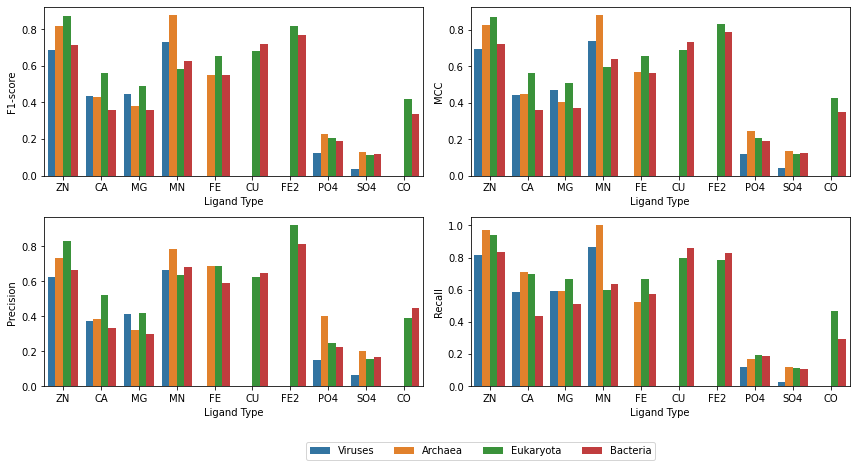

In [196]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(2,2, figsize=(12,6))
#plt.figure(figsize=(6, 4))
order=['ZN','CA','MG','MN','FE','CU','FE2','PO4','SO4','CO']


sns.barplot(data=tax_out, y='F1-score', hue='Taxonomy', x='Ligand Type',  order=order, ax=axes[0,0])
sns.barplot(data=tax_out, y='MCC', x='Ligand Type', hue='Taxonomy', order=order, ax=axes[0,1])
sns.barplot(data=tax_out, y='Precision', x='Ligand Type', hue='Taxonomy', ax=axes[1,0],order=order)
sns.barplot(data=tax_out, y='Recall', x='Ligand Type', hue='Taxonomy', ax=axes[1,1],order=order)
figure.tight_layout()

#figure.tight_layout(h_pad=0, w_pad=2)

axes[0,1].legend([],[], frameon=False)
axes[1,0].legend([],[], frameon=False)
axes[0,0].legend([],[], frameon=False)
axes[1,1].legend([],[], frameon=False)
#plt.legend()
#plt.legend(bbox_to_anchor=(1,1.5))
#plt.legend(bbox_to_anchor=(-0.5,-0.3))
plt.legend(bbox_to_anchor=(0.5,-0.3), ncol=4)
#plt.legend(loc='lower right',bbox_to_anchor=(0.1,-0.8))

#plt.savefig('figures/esm_pssm_msa_allmeasures_1x4.png',  bbox_inches='tight',  pad_inches=0.3,dpi=350)
plt.show()

## Panther

    index                                        activity  count     p1     p2
0       1               transporter activity (GO:0005215)    162   2.6%   2.1%
1       2  No PANTHER category is assigned (UNCLASSIFIED)   2629  42.7%  34.4%
2       3     translation regulator activity (GO:0045182)     15   0.2%   0.2%
3       4   transcription regulator activity (GO:0140110)    166   2.7%   2.2%
4       5                 catalytic activity (GO:0003824)   2320  37.7%  30.3%
5       6        cytoskeletal motor activity (GO:0003774)     22   0.4%   0.3%
6       7       molecular function regulator (GO:0098772)    165   2.7%   2.2%
7       8             ATP-dependent activity (GO:0140657)    123   2.0%   1.6%
8       9      molecular transducer activity (GO:0060089)    158   2.6%   2.1%
9      10         molecular adaptor activity (GO:0060090)     34   0.6%   0.4%
10     11       structural molecule activity (GO:0005198)    170   2.8%   2.2%
11     12                            binding (GO:000

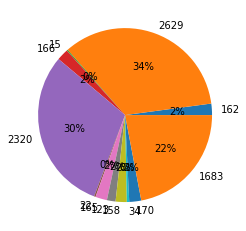

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

df_pie = pd.read_csv('data/supp/pantherChart.csv', delimiter='\t', names=['index', 'activity','count','p1','p2'])
print (df_pie)

data = df_pie['count']
labels = df_pie['count']
plt.pie(data, labels = labels, autopct='%.0f%%')
plt.show()

In [205]:
#Import libraries
from matplotlib_venn import venn3, venn2
%matplotlib inline

sns.set(style="white")
pd.set_option('display.max_columns', None)

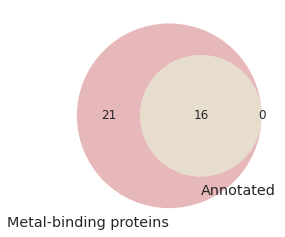

In [209]:
venn2(subsets = (21,0, 16), set_labels = ('Metal-binding proteins', 'Annotated'))